## load libraries

In [ ]:
import torch
torch.cuda.set_device(2)
torch.cuda.current_device()
import pandas as pd
import numpy as np
from langdetect import detect
import re

from medner import MedNER
from medlinker import MedLinker
from umls import umls_kb_st21pv as umls_kb
import json
from nltk.stem import WordNetLemmatizer 
import nltk
import yaml

## read  metadata

In [3]:
import pandas as pd
meta = pd.read_csv('/home/dhamzeia/Data/metadata.csv')
# meta = meta['abstract']


# calculate the number of empty documents
#empty = 0
# # from langdetect import detect

# for i, m in enumerate(meta):
#     if str(m)=='nan':
#         empty+=1
#         continue
# print(empty)
    
# 414020 of the abstracts are empty

/opt/anaconda3/2019-03/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## load medlinker models (NER + EL) for preprocessing

In [ ]:


# default models, best configuration from paper
# to experiment with different configurations, just comment/uncomment components

cx_ner_path = 'models/ContextualNER/mm_st21pv_SCIBERT_uncased/'
em_ner_path = 'models/ExactMatchNER/umls.2017AA.active.st21pv.nerfed_nlp_and_matcher.max3.p'
ngram_db_path = 'models/SimString/umls.2017AA.active.st21pv.aliases.3gram.5toks.db'
ngram_map_path = 'models/SimString/umls.2017AA.active.st21pv.aliases.5toks.map'
st_vsm_path = 'models/VSMs/mm_st21pv.sts_anns.scibert_scivocab_uncased.vecs'
cui_vsm_path = 'models/VSMs/mm_st21pv.cuis.scibert_scivocab_uncased.vecs'
cui_clf_path = 'models/Classifiers/softmax.cui.h5'
sty_clf_path = 'models/Classifiers/softmax.sty.h5'
cui_val_path = 'models/Validators/mm_st21pv.lr_clf_cui.dev.joblib'
sty_val_path = 'models/Validators/mm_st21pv.lr_clf_sty.dev.joblib'

print('Loading MedNER ...')
medner = MedNER(umls_kb)
medner.load_contextual_ner(cx_ner_path, 2)

print('Loading MedLinker ...')
medlinker = MedLinker(medner, umls_kb)

medlinker.load_string_matcher(ngram_db_path, ngram_map_path)  # simstring approximate string matching

# medlinker.load_st_VSM(st_vsm_path)
medlinker.load_sty_clf(sty_clf_path)
# medlinker.load_st_validator(sty_val_path, validator_thresh=0.45)

# medlinker.load_cui_VSM(cui_vsm_path)
medlinker.load_cui_clf(cui_clf_path)
# medlinker.load_cui_validator(cui_val_path, validator_thresh=0.70)



## An example of MedLinker's output

In [7]:
sent = '''The severe acute respiratory syndrome coronavirus-2 (SARS-CoV-2) pandemic was first reported in Wuhan, China in December 2019, moved across the globe at an unprecedented speed, and is having a profound and yet still unfolding health and socioeconomic impacts. SARS-CoV-2, a β-coronavirus, is a highly contagious respiratory pathogen that causes a disease that has been termed the 2019 coronavirus disease (COVID-19). Clinical experience thus far indicates that COVID-19 is highly heterogeneous, ranging from being asymptomatic and mild to severe and causing death. Host factors including age, sex, and comorbid conditions are key determinants of disease severity and progression. Aging itself is a prominent risk factor for severe disease and death from COVID-19. We hypothesize that age-related decline and dysregulation of immune function, i.e., immunosenescence and inflammaging play a major role in contributing to heightened vulnerability to severe COVID-19 outcomes in older adults. Much remains to be learned about the immune responses to SARS-CoV-2 infection. We need to begin partitioning all immunological outcome data by age to better understand disease heterogeneity and aging. Such knowledge is critical not only for understanding of covid-19 pathogenesis but also for COVID-19 vaccine development.'''
medlinker.predict(sent)


{'sentence': 'The severe acute respiratory syndrome coronavirus-2 (SARS-CoV-2) pandemic was first reported in Wuhan, China in December 2019, moved across the globe at an unprecedented speed, and is having a profound and yet still unfolding health and socioeconomic impacts. SARS-CoV-2, a β-coronavirus, is a highly contagious respiratory pathogen that causes a disease that has been termed the 2019 coronavirus disease (COVID-19). Clinical experience thus far indicates that COVID-19 is highly heterogeneous, ranging from being asymptomatic and mild to severe and causing death. Host factors including age, sex, and comorbid conditions are key determinants of disease severity and progression. Aging itself is a prominent risk factor for severe disease and death from COVID-19. We hypothesize that age-related decline and dysregulation of immune function, i.e., immunosenescence and inflammaging play a major role in contributing to heightened vulnerability to severe COVID-19 outcomes in older adult

In [44]:
### Do some preprocessing before medlinker: remove numbers/floats/ratio/all_capitals/Non_english& empty abstracts

In [ ]:
# t = re.findall('([A-Z]{4,})', text)
# elapsed time: 85s for 100 docs. for 400k would be >90h!
medlinked = []
non_english = 0
empty =0
predicted_index = []

for i, text in enumerate(meta['abstract']):
    if i <150000:
        continue
    print(i)
    print('medlinked is: {}'.format(len(medlinked)))
    if i in predicted_index:
        continue
    if text=='' or str(text)=='nan': 
        empty+=1
        print(text)
        continue
    try:
        lang= detect(text)
        if lang!= 'en':
            non_english +=1
            continue
    except Exception as e:
        print(text)
        print(e)
        empty+=1
        continue



    
    sent_text = nltk.sent_tokenize(text)
    for sent in sent_text:
        sent = re.sub(r'(PATIENTS|STATISTICAL|ANALYSIS|SETTING|REVIEWERS|QUESTIONS|PURPOSES|PURPOSE|EXPERIMENTAL|DESIGN|RELEVANCE|CLINICAL|ENHANCED|VERSION|REGISTRATION|MATERIALS|ELECTRONIC|MATERIAL|PRESENTATION|OBJECTIVE|METHODS|CONCLUSION|RESULTS|BACKGROUND|INTRODUCTION|DISCUSSION|SIGNIFICANCE|DESCRIPTION|ABSTRACT|METHODOLOGY|PRINCIPAL|FINDINGS|INFORMATION|SUPPLEMENTARY|SUMMARY)', ' ', sent)
        sent = re.sub(r"\d+\.\d+",' ', sent)
        sent = re.sub(r"\d+\.\d+%",' ', sent)
        sent = re.sub(r"\d+\,\d+",' ', sent)
        sent = re.sub(r"\.\d+",' ', sent)
        sent = re.sub(r"\,\d+",' ', sent)
        sent= re.sub(r' [0-9]+ ','  ',sent)
        sent = re.sub(r'\[.*?\]', '', sent)
        sent = re.sub(r'[0-9]+%',' ', sent)
        if len(sent)>10 and len(sent)< 1000:
            r = medlinker.predict(sent)
            r['index'] = i
            medlinked.append(r)
            predicted_index.append(i)

#     except Exception as e:
#         print(text)
#         print(e)
    
    
    

In [11]:
print('until i= {}, empty= {}, and non_english = {}, predicted = {}'.format(i, empty, non_english, len(set(predicted_index))))
#until i= 52309, empty= 17737, and non_english = 998
#until i= 56384, empty= 18726, and non_english = 1015, predicted = 36832
#from i = 150k until  i= 241807, empty= 31170, and non_english = 1732, predicted = 47241


until i= 241807, empty= 31170, and non_english = 1732, predicted = 47241


In [25]:
#save medlinked to csv
medlinked_df = pd.DataFrame(medlinked)   
medlinked_df.to_csv('medlinked_testset.csv')

In [27]:
# read medlinked. medlinked was applied on sentences. We need to combine them to form a abstract
import pandas as pd
import numpy as np
medlinked_df = pd.read_csv('medlinked_testset.csv' )
medlinked_df.head()

,Unnamed: 0,sentence,tokens,spans,index
0,0,Extreme prolonged drought over south-eastern A...,"['Extreme', 'prolonged', 'drought', 'over', 's...","[{'start': 4, 'end': 6, 'text': 'south-eastern...",150001
1,1,Whilst the significant release of metal-enrich...,"['Whilst', 'the', 'significant', 'release', 'o...","[{'start': 5, 'end': 6, 'text': 'metal-enriche...",150001
2,2,"Here we investigate the spatial distribution, ...","['Here', 'we', 'investigate', 'the', 'spatial'...","[{'start': 12, 'end': 14, 'text': 'S, Fe,', 's...",150001
3,3,The highest concentrations of all metals (Enri...,"['The', 'highest', 'concentrations', 'of', 'al...","[{'start': 5, 'end': 6, 'text': 'metals', 'st'...",150001
4,4,Localised enrichment indicates metals have not...,"['Localised', 'enrichment', 'indicates', 'meta...","[{'start': 3, 'end': 4, 'text': 'metals', 'st'...",150001


### Apply lemmatization, punctuation removal, and lowercase after medlinker

In [28]:
def clean(tok):
#     print("tok  " + tok)
    clean_tok = tok.lower()
    clean_chars = ''
    for ch in clean_tok:
        if ch in '0123456789abcdefghijklmnopqrstuvwxyz-':
            clean_chars+= ch
        else:
            clean_chars+=' '
    clean_tok = clean_chars
    clean_tok = clean_tok.strip()
    if clean_tok.lower() not in stopwords.words('english'):
        clean_tok = re.sub(r' [0-9]+ ','  ',clean_tok)
        clean_tok = re.sub(r'[0-9]+ ','  ',clean_tok)
        clean_tok = re.sub(r' [0-9]+','  ',clean_tok)
        clean_tok = re.sub(r'[0-9]+s','  ',clean_tok)
        clean_tok = re.sub(r'[0-9]+th','  ',clean_tok)
        clean_tok = clean_tok.strip()

        if clean_tok !='' and not clean_tok.isnumeric():

            if clean_tok!='eg' and clean_tok !='ie' and len(clean_tok)>1 and clean_tok not in stops:

                clean_tok = wordnet_lemmatizer.lemmatize(clean_tok, pos = 'n')
                clean_tok = wordnet_lemmatizer.lemmatize(clean_tok, pos = 'v')
                clean_tok = wordnet_lemmatizer.lemmatize(clean_tok, pos = 'a')
                if clean_tok[0] not in string.digits:
                    if clean_tok[0]=='-':
                        clean_tok = clean_tok[1:len(clean_tok)] 
                    return(clean_tok)
#                     updated_str+= ' '+clean_tok
    return ''
                

In [ ]:
#process medlinked
import string
from nltk.corpus import stopwords
exclude = set(string.punctuation)
# preprocessed = []
medlinked_df['preprocessed'] = ''
wordnet_lemmatizer = WordNetLemmatizer()
stops = stopwords.words('english')
for a in ['ii', 'iii', 'iv', 'vi', 'ix', 'vii', 'viii']:
    stops.append(a)
for row in range(len(medlinked_df)) :
    tokens, spans, sentence = medlinked_df['tokens'][row], medlinked_df['spans'][row], medlinked_df['sentence'][row]
    if medlinked_df['preprocessed'][row]!='':
        continue
    if row %100==0:
        print(row)
        
    last_end = 0
    updated_str = ''
    try:
        tokens = yaml.load(tokens)
        spans = yaml.load(spans)
    except Exception as e:
        print(e)
        print(row)
        continue
    if len(spans)>0:
        for sp in spans:
            start = sp['start']
            end = sp['end']
            cui = sp['cui']
            cui = cui[2:len(cui)-1]
    #         print(cui)
    #         print()
            for tok in tokens[last_end:start]:
#                 print(clean(tok))
                updated_str +=' ' + clean(tok)
            updated_str+=' '
            updated_str+= cui
            updated_str+=' '
            last_end = end

        if end < len(tokens):
            updated_str+= ' '
            for tok in tokens[end:len(tokens)]:
                updated_str+= ' '+clean(tok)
            
    else:
        for tok in tokens:
                updated_str +=' ' + clean(tok)
        
#             clean_tok = re.sub(re.compile('[!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~]'),' ', tok)
#             clean_tok = re.sub(r'•', ' ', clean_tok)
#             clean_tok = re.sub(r'’', ' ', clean_tok)
            
            
#     print(updated_str)

    medlinked_df['preprocessed'][row] = updated_str
#     preprocessed.append(updated_str)
# medlinked_df['preprocessed'] = preprocessed
#     print()
#     cov['tokens'][start:end] = reduce(cui)
#     print('----')
#     print(end)
#     print(cui)
#     print('---')

In [38]:
# save preprocessed& medlinked abstracts
medlinked_df.to_csv('medlinked_testset_prep.csv')

In [61]:
# aggregate the results of sentences to form abstracts again
agg_df = medlinked_df.groupby(['index'], as_index = False)['preprocessed'].agg({'prep_text': ' '.join})

# agg_df['original'] = meta['abstract'][agg_df['index']]
print(agg_df.head())
agg_df.to_csv('agg_df_testset.csv')

    index                                          prep_text
0  150001   extreme prolong drought  C0004340    decade a...
1  150002    recent C0546788   pandemic  cause unpreceden...
2  150004   C0078939   C0085401   currently represent  tw...
3  150007   C0001617  c C0021496   commonly use   C003313...
4  150013    early evidence indicate increase C0025353  b...


# read test and train documents (preprocessed) and add url, abstract and ID columns from meta dataframe

In [4]:
import pandas as pd
import numpy as np
agg_df = pd.read_csv('agg_df_56384.csv')
test_df = pd.read_csv('agg_df_testset.csv')
test_df = test_df.drop_duplicates(subset = ['prep_text']).reset_index(drop = True)
agg_df = agg_df.drop_duplicates(subset = ['prep_text']).reset_index(drop = True)
agg_df.loc[:, 'url'] = meta.loc[agg_df['index'].astype(int), 'url'].reset_index()
agg_df.loc[:, 'abstract'] = meta.loc[agg_df['index'].astype(int), 'abstract'].reset_index()
agg_df.loc[:, 'cord_uid'] = meta.loc[agg_df['index'].astype(int), 'cord_uid'].reset_index()
test_df= test_df.loc[test_df['prep_text'].astype(str)!='nan'].reset_index()
test_df.loc[:, 'url'] = meta.loc[test_df['index'].astype(int), 'url'].reset_index()
test_df.loc[:, 'abstract'] = meta.loc[test_df['index'].astype(int), 'abstract'].reset_index()
test_df.loc[:, 'cord_uid'] = meta.loc[test_df['index'].astype(int), 'cord_uid'].reset_index()
test_df.tail()

,level_0,Unnamed: 0,index,prep_text,url,abstract,cord_uid
43284,43285,47235,241800,association age high vulnerability C0546...,NaN,The association of age with a higher vulnerabi...,xet6b64x
43285,43286,47236,241801,outbreak C0010076 covid-19 C0008115 caus...,NaN,An outbreak of coronavirus disease (COVID-19) ...,7jakv2ge
43286,43287,47237,241802,increase C0038435 resilience C2936506 imp...,NaN,Increasing stress resilience of livestock is i...,vy8s51p9
43287,43288,47238,241803,context C0282574 pandemic highlight essen...,NaN,CONTEXT: The COVID-19 pandemic has highlighted...,fexdvnuj
43288,43289,47239,241804,C0031323 need effective communication skill ...,NaN,Pharmacists need effective communication skill...,djn6ltnu


## An example of a preprocessed document

In [34]:
print('original:')
print(test_df.loc[1, 'abstract'])
print()
print('preprocessed:')
print(test_df.loc[1, 'prep_text'])

original:
The recent COVID-19 pandemic has caused unprecedented impact across the globe. We have also witnessed millions of people with increased mental health issues, such as depression, stress, worry, fear, disgust, sadness, and anxiety, which have become one of the major public health concerns during this severe health crisis. For instance, depression is one of the most common mental health issues according to the findings made by the World Health Organisation (WHO). Depression can cause serious emotional, behavioural and physical health problems with significant consequences, both personal and social costs included. This paper studies community depression dynamics due to COVID-19 pandemic through user-generated content on Twitter. A new approach based on multi-modal features from tweets and Term Frequency-Inverse Document Frequency (TF-IDF) is proposed to build depression classification models. Multi-modal features capture depression cues from emotion, topic and domain-specific per

In [ ]:
# import spacy

# from scispacy.abbreviation import AbbreviationDetector

# nlp = spacy.load("en_core_web_sm")

# # Add the abbreviation pipe to the spacy pipeline.
# abbreviation_pipe = AbbreviationDetector(nlp)
# nlp.add_pipe(abbreviation_pipe)


abrvs = []
for i, text in enumerate(agg_df[ 'abstract']):
    doc = nlp(text)
    for abrv in doc._.abbreviations:
        abrvs.append(abrv)
    if i%100 ==0:
        print(i)
#         print(abrv)

In [23]:
abrvs_set = set([abrv.lower_ for abrv in abrvs])

In [28]:
import re
from sklearn.feature_extraction.text import CountVectorizer
def custom_tokenizer(txt):
    toks = []
    txt = str(txt)
    txt = txt.lower()
    for s in txt.split(' '):
        if len(s)<2:
            continue
        if s[0]=='-':
            if s[1]=='-':
                s= s[1:len(s)]
            s = s[1:len(s)]
        if len(s)<2:
            continue
        if s[len(s)-1]=='-':
            s= s[0:len(s)-1]
        if s.isnumeric():
            continue
        elif len(s)>2 and s not in abrvs_set:
            toks.append(s)
    return toks
count_vect = CountVectorizer(tokenizer=custom_tokenizer, stop_words='english', max_features=10000)
X_train_counts = count_vect.fit_transform(agg_df['prep_text'])

In [26]:
# check tokens of the dictionary (Vocabulary)
for v in sorted(count_vect.vocabulary_):
    if len(v)!= len("c0014507"):
        print(v)


a549
abandon
abbreviate
abdomen
abdominal
ability
abiotic
ablate
able
abnormality
abolish
above-mentioned
abroad
abrupt
abscess
absence
absent
absenteeism
absolutely
absorb
absorbable
absorbance
absorption
abstinence
abstraction
abundance
abundantly
accelerate
acceleration
accentuate
accept
acceptability
acceptable
acceptance
accessibility
accessible
accessory
accidental
accommodate
accompany
accomplish
accomplishment
accord
accordance
accordingly
account
accountability
accreditation
accumulate
accumulation
accurately
achievable
achieve
achievement
acidic
acknowledge
acquire
acquisition
actionable
activation
activator
active
actor
actual
acuity
acute
acutely
acyclic
ad-hoc
adaptability
adaptable
adaptation
addiction
additional
additionally
address
adenocarcinoma
adenovirus
adequately
adhere
adherence
adjunct
adjunctive
adjust
adjustment
adjuvanted
administer
administrate
administration
administrative
admission
admit
adolescence
adolescent
adrenal
adsorb
adsorbent
adsorption
adult
adult

lytic
macaque
machine
machinery
macro
macromolecule
macrophage
macroscopic
magnify
magnitude
mail
main
mainly
mainstream
maintenance
major
make
maker
maladaptive
malformation
malfunction
malicious
malignancy
malignant
maltreatment
mammal
man
manage
manageable
management
manager
managerial
mandate
mandatory
manifestation
manipulate
manipulation
mankind
mann-whitney
manner
manual
manufacture
manuscript
march
margin
marginalize
marginally
marine
marital
mark
marker
market
markov
marrow
mask
massive
massively
master
match
math
mathematical
mathematically
mathematics
maturation
mature
maximal
maximally
maybe
meal
mean-field
meaningful
measles
measurable
measure
measurement
mechanical
mechanically
mechanism
mechanistic
mechanistically
mediate
mediation
medically
medication
medicinal
medium
medium-sized
medium-term
meet
meier
melt
member
membership
meningitis
mental
mention
mentor
merck
mere
merely
merge
merit
message
meta-analyses
meta-analysis
metabolic
metabolism
metabolite
metal
metastasi

## tokenize the train and test documents

In [29]:
word_tokenizer = count_vect.build_tokenizer()
texts = [word_tokenizer(doc) for doc in agg_df['prep_text']]
test_texts = [word_tokenizer(doc) for doc in test_df['prep_text']]

# tokenized_test_20 = [word_tokenizer(doc.lower()) for doc in twenty_test.data]
# texts[1]

# build dataset and the topic model

In [30]:
from contextualized_topic_models.models.ctm import CTM
import os
import pickle
from contextualized_topic_models.utils.data_preparation import TextHandler
from contextualized_topic_models.datasets.dataset import CTMDataset, CTMNoBERTDataset
import time

tmp = {k: v for k, v in sorted(count_vect.vocabulary_.items(), key=lambda item: item[1])}
idx2token = dict((v,k) for k,v in tmp.items())
X_test_counts = count_vect.transform(test_df['prep_text'])
dataset = CTMNoBERTDataset(X_train_counts,  idx2token)
test_set = CTMNoBERTDataset(X_test_counts,  idx2token)
# # create the dataset

start = time.time()
ctm = CTM(input_size=len(count_vect.vocabulary_), bert_input_size=768, num_epochs=250, inference_type="noBERT", n_components=10, texts = texts, model_type='prodLDA')

ctm.fit(dataset, save_dir = 'saved_models/vocab_10k/', save_every = 25)
end = time.time()
print('elapsed time = {}'.format(end-start))

/home/dhamzeia/Thesis/BiomedicalTopicModelling/contextualized_topic_models/models/ctm.py:51: DeprecationWarning: Direct call to CTM is deprecated and will be removed in version 2, use CombinedTM or ZeroShotTM
  warnings.warn("Direct call to CTM is deprecated and will be removed in version 2, use CombinedTM or ZeroShotTM", DeprecationWarning)


Settings: 
                   N Components: 10
                   Topic Prior Mean: 0.0
                   Topic Prior Variance: 0.9
                   Model Type: prodLDA
                   Hidden Sizes: (100, 100)
                   Activation: softplus
                   Dropout: 0.2
                   Learn Priors: True
                   Learning Rate: 0.002
                   Momentum: 0.99
                   Reduce On Plateau: False
                   Save Dir: saved_models/vocab_10k/
Epoch: [1/250]	Samples: [36726/9181500]	Train Loss: 670.7034984369044	Time: 0:00:04.400834
Epoch: [2/250]	Samples: [73452/9181500]	Train Loss: 650.6053928075478	Time: 0:00:04.357050
Epoch: [3/250]	Samples: [110178/9181500]	Train Loss: 648.2454989738196	Time: 0:00:04.392791
Epoch: [4/250]	Samples: [146904/9181500]	Train Loss: 646.8304346503498	Time: 0:00:04.439948
Epoch: [5/250]	Samples: [183630/9181500]	Train Loss: 646.16915234609	Time: 0:00:04.439132
Epoch: [6/250]	Samples: [220356/9181500]	Train 

I0228 01:27:14.489248 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])


Epoch: [25/250]	Samples: [918150/9181500]	Train Loss: 642.7324733541973	Time: 0:00:04.690334


I0228 01:27:15.313133 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:27:15.996283 140370323834688 dictionary.py:209] adding document #20000 to Dictionary(69295 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:27:16.803380 140370323834688 dictionary.py:209] adding document #30000 to Dictionary(90493 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:27:17.336635 140370323834688 dictionary.py:216] built Dictionary(102477 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...) from 36726 documents (total 3132041 corpus positions)
I0228 01:27:17.337257 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I0228 01:27:18.084076 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affe

I0228 01:27:31.380962 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 18000 documents
I0228 01:27:31.394298 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 19000 documents
I0228 01:27:31.408857 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 20000 documents
I0228 01:27:31.424784 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 21000 documents
I0228 01:27:31.441360 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 22000 documents
I0228 01:27:31.459140 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 23000 documents
I0228 01:27:31.484410 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 24000 documents
I0228 01:27:31.501925 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 25000 documents
I0228 01:27:31.519025 140370323834688 text_analysis.py:124] Corp

I0228 01:27:32.756186 140370323834688 text_analysis.py:506] 44 batches submitted to accumulate stats from 2816 documents (244106 virtual)
I0228 01:27:32.778901 140370323834688 text_analysis.py:506] 45 batches submitted to accumulate stats from 2880 documents (249622 virtual)
I0228 01:27:32.805317 140370323834688 text_analysis.py:506] 46 batches submitted to accumulate stats from 2944 documents (254903 virtual)
I0228 01:27:32.818345 140370323834688 text_analysis.py:506] 47 batches submitted to accumulate stats from 3008 documents (260245 virtual)
I0228 01:27:32.823799 140370323834688 text_analysis.py:506] 48 batches submitted to accumulate stats from 3072 documents (265398 virtual)
I0228 01:27:32.830979 140370323834688 text_analysis.py:506] 49 batches submitted to accumulate stats from 3136 documents (270931 virtual)
I0228 01:27:32.851892 140370323834688 text_analysis.py:506] 50 batches submitted to accumulate stats from 3200 documents (276222 virtual)
I0228 01:27:32.872336 140370323834

I0228 01:27:33.542142 140370323834688 text_analysis.py:506] 104 batches submitted to accumulate stats from 6656 documents (537839 virtual)
I0228 01:27:33.557428 140370323834688 text_analysis.py:506] 105 batches submitted to accumulate stats from 6720 documents (541405 virtual)
I0228 01:27:33.562647 140370323834688 text_analysis.py:506] 106 batches submitted to accumulate stats from 6784 documents (545917 virtual)
I0228 01:27:33.578239 140370323834688 text_analysis.py:506] 107 batches submitted to accumulate stats from 6848 documents (550458 virtual)
I0228 01:27:33.600852 140370323834688 text_analysis.py:506] 108 batches submitted to accumulate stats from 6912 documents (554648 virtual)
I0228 01:27:33.605378 140370323834688 text_analysis.py:506] 109 batches submitted to accumulate stats from 6976 documents (559305 virtual)
I0228 01:27:33.615453 140370323834688 text_analysis.py:506] 110 batches submitted to accumulate stats from 7040 documents (563344 virtual)
I0228 01:27:33.619201 14037

I0228 01:27:34.271824 140370323834688 text_analysis.py:506] 163 batches submitted to accumulate stats from 10432 documents (835312 virtual)
I0228 01:27:34.286003 140370323834688 text_analysis.py:506] 164 batches submitted to accumulate stats from 10496 documents (840687 virtual)
I0228 01:27:34.294167 140370323834688 text_analysis.py:506] 165 batches submitted to accumulate stats from 10560 documents (846190 virtual)
I0228 01:27:34.301474 140370323834688 text_analysis.py:506] 166 batches submitted to accumulate stats from 10624 documents (852385 virtual)
I0228 01:27:34.332295 140370323834688 text_analysis.py:506] 167 batches submitted to accumulate stats from 10688 documents (858351 virtual)
I0228 01:27:34.340760 140370323834688 text_analysis.py:506] 168 batches submitted to accumulate stats from 10752 documents (864061 virtual)
I0228 01:27:34.353111 140370323834688 text_analysis.py:506] 169 batches submitted to accumulate stats from 10816 documents (869917 virtual)
I0228 01:27:34.36763

I0228 01:27:34.940293 140370323834688 text_analysis.py:506] 222 batches submitted to accumulate stats from 14208 documents (1092959 virtual)
I0228 01:27:34.946841 140370323834688 text_analysis.py:506] 223 batches submitted to accumulate stats from 14272 documents (1096911 virtual)
I0228 01:27:34.949478 140370323834688 text_analysis.py:506] 224 batches submitted to accumulate stats from 14336 documents (1100672 virtual)
I0228 01:27:34.978621 140370323834688 text_analysis.py:506] 225 batches submitted to accumulate stats from 14400 documents (1104139 virtual)
I0228 01:27:34.982822 140370323834688 text_analysis.py:506] 226 batches submitted to accumulate stats from 14464 documents (1108588 virtual)
I0228 01:27:34.986771 140370323834688 text_analysis.py:506] 227 batches submitted to accumulate stats from 14528 documents (1112463 virtual)
I0228 01:27:34.994330 140370323834688 text_analysis.py:506] 228 batches submitted to accumulate stats from 14592 documents (1116298 virtual)
I0228 01:27:3

I0228 01:27:35.518428 140370323834688 text_analysis.py:506] 281 batches submitted to accumulate stats from 17984 documents (1336490 virtual)
I0228 01:27:35.522144 140370323834688 text_analysis.py:506] 282 batches submitted to accumulate stats from 18048 documents (1340041 virtual)
I0228 01:27:35.531788 140370323834688 text_analysis.py:506] 283 batches submitted to accumulate stats from 18112 documents (1343597 virtual)
I0228 01:27:35.537418 140370323834688 text_analysis.py:506] 284 batches submitted to accumulate stats from 18176 documents (1347501 virtual)
I0228 01:27:35.547448 140370323834688 text_analysis.py:506] 285 batches submitted to accumulate stats from 18240 documents (1351792 virtual)
I0228 01:27:35.556704 140370323834688 text_analysis.py:506] 286 batches submitted to accumulate stats from 18304 documents (1356046 virtual)
I0228 01:27:35.575832 140370323834688 text_analysis.py:506] 287 batches submitted to accumulate stats from 18368 documents (1360462 virtual)
I0228 01:27:3

I0228 01:27:36.181315 140370323834688 text_analysis.py:506] 340 batches submitted to accumulate stats from 21760 documents (1627139 virtual)
I0228 01:27:36.186585 140370323834688 text_analysis.py:506] 341 batches submitted to accumulate stats from 21824 documents (1632635 virtual)
I0228 01:27:36.189360 140370323834688 text_analysis.py:506] 342 batches submitted to accumulate stats from 21888 documents (1636757 virtual)
I0228 01:27:36.196030 140370323834688 text_analysis.py:506] 343 batches submitted to accumulate stats from 21952 documents (1642288 virtual)
I0228 01:27:36.238261 140370323834688 text_analysis.py:506] 344 batches submitted to accumulate stats from 22016 documents (1647184 virtual)
I0228 01:27:36.253458 140370323834688 text_analysis.py:506] 345 batches submitted to accumulate stats from 22080 documents (1652434 virtual)
I0228 01:27:36.258471 140370323834688 text_analysis.py:506] 346 batches submitted to accumulate stats from 22144 documents (1658210 virtual)
I0228 01:27:3

I0228 01:27:36.989110 140370323834688 text_analysis.py:506] 399 batches submitted to accumulate stats from 25536 documents (1945769 virtual)
I0228 01:27:36.998570 140370323834688 text_analysis.py:506] 400 batches submitted to accumulate stats from 25600 documents (1950572 virtual)
I0228 01:27:37.003220 140370323834688 text_analysis.py:506] 401 batches submitted to accumulate stats from 25664 documents (1955629 virtual)
I0228 01:27:37.007896 140370323834688 text_analysis.py:506] 402 batches submitted to accumulate stats from 25728 documents (1960731 virtual)
I0228 01:27:37.023083 140370323834688 text_analysis.py:506] 403 batches submitted to accumulate stats from 25792 documents (1965723 virtual)
I0228 01:27:37.052964 140370323834688 text_analysis.py:506] 404 batches submitted to accumulate stats from 25856 documents (1970860 virtual)
I0228 01:27:37.057985 140370323834688 text_analysis.py:506] 405 batches submitted to accumulate stats from 25920 documents (1975467 virtual)
I0228 01:27:3

I0228 01:27:37.739174 140370323834688 text_analysis.py:506] 458 batches submitted to accumulate stats from 29312 documents (2244032 virtual)
I0228 01:27:37.743761 140370323834688 text_analysis.py:506] 459 batches submitted to accumulate stats from 29376 documents (2248772 virtual)
I0228 01:27:37.763776 140370323834688 text_analysis.py:506] 460 batches submitted to accumulate stats from 29440 documents (2253791 virtual)
I0228 01:27:37.768854 140370323834688 text_analysis.py:506] 461 batches submitted to accumulate stats from 29504 documents (2259114 virtual)
I0228 01:27:37.801606 140370323834688 text_analysis.py:506] 462 batches submitted to accumulate stats from 29568 documents (2264057 virtual)
I0228 01:27:37.805762 140370323834688 text_analysis.py:506] 463 batches submitted to accumulate stats from 29632 documents (2269298 virtual)
I0228 01:27:37.809864 140370323834688 text_analysis.py:506] 464 batches submitted to accumulate stats from 29696 documents (2273997 virtual)
I0228 01:27:3

I0228 01:27:38.506716 140370323834688 text_analysis.py:506] 517 batches submitted to accumulate stats from 33088 documents (2542458 virtual)
I0228 01:27:38.519267 140370323834688 text_analysis.py:506] 518 batches submitted to accumulate stats from 33152 documents (2547273 virtual)
I0228 01:27:38.525751 140370323834688 text_analysis.py:506] 519 batches submitted to accumulate stats from 33216 documents (2552776 virtual)
I0228 01:27:38.530946 140370323834688 text_analysis.py:506] 520 batches submitted to accumulate stats from 33280 documents (2557593 virtual)
I0228 01:27:38.544528 140370323834688 text_analysis.py:506] 521 batches submitted to accumulate stats from 33344 documents (2562282 virtual)
I0228 01:27:38.562261 140370323834688 text_analysis.py:506] 522 batches submitted to accumulate stats from 33408 documents (2567323 virtual)
I0228 01:27:38.578169 140370323834688 text_analysis.py:506] 523 batches submitted to accumulate stats from 33472 documents (2572279 virtual)
I0228 01:27:3

I0228 01:27:39.696004 140370323834688 text_analysis.py:552] accumulated word occurrence stats for 2796164 virtual documents
I0228 01:27:39.779548 140370323834688 probability_estimation.py:155] using ParallelWordOccurrenceAccumulator(processes=5, batch_size=64) to estimate probabilities from sliding windows
I0228 01:27:40.145944 140370323834688 text_analysis.py:506] 1 batches submitted to accumulate stats from 64 documents (4980 virtual)
I0228 01:27:40.150787 140370323834688 text_analysis.py:506] 2 batches submitted to accumulate stats from 128 documents (10307 virtual)
I0228 01:27:40.154548 140370323834688 text_analysis.py:506] 3 batches submitted to accumulate stats from 192 documents (16328 virtual)
I0228 01:27:40.157735 140370323834688 text_analysis.py:506] 4 batches submitted to accumulate stats from 256 documents (21117 virtual)
I0228 01:27:40.161345 140370323834688 text_analysis.py:506] 5 batches submitted to accumulate stats from 320 documents (26828 virtual)
I0228 01:27:40.1761

I0228 01:27:40.901595 140370323834688 text_analysis.py:506] 59 batches submitted to accumulate stats from 3776 documents (325400 virtual)
I0228 01:27:40.908173 140370323834688 text_analysis.py:506] 60 batches submitted to accumulate stats from 3840 documents (331723 virtual)
I0228 01:27:40.929718 140370323834688 text_analysis.py:506] 61 batches submitted to accumulate stats from 3904 documents (337477 virtual)
I0228 01:27:40.943598 140370323834688 text_analysis.py:506] 62 batches submitted to accumulate stats from 3968 documents (343319 virtual)
I0228 01:27:40.958209 140370323834688 text_analysis.py:506] 63 batches submitted to accumulate stats from 4032 documents (348781 virtual)
I0228 01:27:40.977086 140370323834688 text_analysis.py:506] 64 batches submitted to accumulate stats from 4096 documents (354833 virtual)
I0228 01:27:40.990280 140370323834688 text_analysis.py:506] 65 batches submitted to accumulate stats from 4160 documents (360556 virtual)
I0228 01:27:41.005983 140370323834

I0228 01:27:41.628530 140370323834688 text_analysis.py:506] 119 batches submitted to accumulate stats from 7616 documents (603152 virtual)
I0228 01:27:41.632786 140370323834688 text_analysis.py:506] 120 batches submitted to accumulate stats from 7680 documents (607954 virtual)
I0228 01:27:41.654260 140370323834688 text_analysis.py:506] 121 batches submitted to accumulate stats from 7744 documents (613534 virtual)
I0228 01:27:41.658529 140370323834688 text_analysis.py:506] 122 batches submitted to accumulate stats from 7808 documents (618623 virtual)
I0228 01:27:41.662486 140370323834688 text_analysis.py:506] 123 batches submitted to accumulate stats from 7872 documents (623726 virtual)
I0228 01:27:41.675611 140370323834688 text_analysis.py:506] 124 batches submitted to accumulate stats from 7936 documents (628169 virtual)
I0228 01:27:41.679460 140370323834688 text_analysis.py:506] 125 batches submitted to accumulate stats from 8000 documents (632508 virtual)
I0228 01:27:41.708598 14037

I0228 01:27:42.400215 140370323834688 text_analysis.py:506] 178 batches submitted to accumulate stats from 11392 documents (921381 virtual)
I0228 01:27:42.403680 140370323834688 text_analysis.py:506] 179 batches submitted to accumulate stats from 11456 documents (924286 virtual)
I0228 01:27:42.407390 140370323834688 text_analysis.py:506] 180 batches submitted to accumulate stats from 11520 documents (927536 virtual)
I0228 01:27:42.452231 140370323834688 text_analysis.py:506] 181 batches submitted to accumulate stats from 11584 documents (934378 virtual)
I0228 01:27:42.465454 140370323834688 text_analysis.py:506] 182 batches submitted to accumulate stats from 11648 documents (937976 virtual)
I0228 01:27:42.470547 140370323834688 text_analysis.py:506] 183 batches submitted to accumulate stats from 11712 documents (941791 virtual)
I0228 01:27:42.474187 140370323834688 text_analysis.py:506] 184 batches submitted to accumulate stats from 11776 documents (945255 virtual)
I0228 01:27:42.47709

I0228 01:27:42.997717 140370323834688 text_analysis.py:506] 237 batches submitted to accumulate stats from 15168 documents (1156277 virtual)
I0228 01:27:43.001889 140370323834688 text_analysis.py:506] 238 batches submitted to accumulate stats from 15232 documents (1159852 virtual)
I0228 01:27:43.017083 140370323834688 text_analysis.py:506] 239 batches submitted to accumulate stats from 15296 documents (1163833 virtual)
I0228 01:27:43.034153 140370323834688 text_analysis.py:506] 240 batches submitted to accumulate stats from 15360 documents (1168105 virtual)
I0228 01:27:43.038084 140370323834688 text_analysis.py:506] 241 batches submitted to accumulate stats from 15424 documents (1171751 virtual)
I0228 01:27:43.055869 140370323834688 text_analysis.py:506] 242 batches submitted to accumulate stats from 15488 documents (1176640 virtual)
I0228 01:27:43.059758 140370323834688 text_analysis.py:506] 243 batches submitted to accumulate stats from 15552 documents (1181252 virtual)
I0228 01:27:4

I0228 01:27:43.576115 140370323834688 text_analysis.py:506] 296 batches submitted to accumulate stats from 18944 documents (1397912 virtual)
I0228 01:27:43.580337 140370323834688 text_analysis.py:506] 297 batches submitted to accumulate stats from 19008 documents (1403013 virtual)
I0228 01:27:43.583344 140370323834688 text_analysis.py:506] 298 batches submitted to accumulate stats from 19072 documents (1406999 virtual)
I0228 01:27:43.598009 140370323834688 text_analysis.py:506] 299 batches submitted to accumulate stats from 19136 documents (1411617 virtual)
I0228 01:27:43.601493 140370323834688 text_analysis.py:506] 300 batches submitted to accumulate stats from 19200 documents (1416530 virtual)
I0228 01:27:43.617179 140370323834688 text_analysis.py:506] 301 batches submitted to accumulate stats from 19264 documents (1420976 virtual)
I0228 01:27:43.643844 140370323834688 text_analysis.py:506] 302 batches submitted to accumulate stats from 19328 documents (1425009 virtual)
I0228 01:27:4

I0228 01:27:44.290410 140370323834688 text_analysis.py:506] 355 batches submitted to accumulate stats from 22720 documents (1718825 virtual)
I0228 01:27:44.298052 140370323834688 text_analysis.py:506] 356 batches submitted to accumulate stats from 22784 documents (1723914 virtual)
I0228 01:27:44.302970 140370323834688 text_analysis.py:506] 357 batches submitted to accumulate stats from 22848 documents (1729364 virtual)
I0228 01:27:44.306318 140370323834688 text_analysis.py:506] 358 batches submitted to accumulate stats from 22912 documents (1735342 virtual)
I0228 01:27:44.349212 140370323834688 text_analysis.py:506] 359 batches submitted to accumulate stats from 22976 documents (1740928 virtual)
I0228 01:27:44.353687 140370323834688 text_analysis.py:506] 360 batches submitted to accumulate stats from 23040 documents (1747155 virtual)
I0228 01:27:44.388381 140370323834688 text_analysis.py:506] 361 batches submitted to accumulate stats from 23104 documents (1752977 virtual)
I0228 01:27:4

I0228 01:27:45.099742 140370323834688 text_analysis.py:506] 414 batches submitted to accumulate stats from 26496 documents (2022056 virtual)
I0228 01:27:45.104253 140370323834688 text_analysis.py:506] 415 batches submitted to accumulate stats from 26560 documents (2027295 virtual)
I0228 01:27:45.107209 140370323834688 text_analysis.py:506] 416 batches submitted to accumulate stats from 26624 documents (2032389 virtual)
I0228 01:27:45.110275 140370323834688 text_analysis.py:506] 417 batches submitted to accumulate stats from 26688 documents (2037707 virtual)
I0228 01:27:45.123879 140370323834688 text_analysis.py:506] 418 batches submitted to accumulate stats from 26752 documents (2042909 virtual)
I0228 01:27:45.154603 140370323834688 text_analysis.py:506] 419 batches submitted to accumulate stats from 26816 documents (2048014 virtual)
I0228 01:27:45.158896 140370323834688 text_analysis.py:506] 420 batches submitted to accumulate stats from 26880 documents (2052827 virtual)
I0228 01:27:4

I0228 01:27:45.833493 140370323834688 text_analysis.py:506] 473 batches submitted to accumulate stats from 30272 documents (2319150 virtual)
I0228 01:27:45.846105 140370323834688 text_analysis.py:506] 474 batches submitted to accumulate stats from 30336 documents (2324289 virtual)
I0228 01:27:45.873632 140370323834688 text_analysis.py:506] 475 batches submitted to accumulate stats from 30400 documents (2329350 virtual)
I0228 01:27:45.878266 140370323834688 text_analysis.py:506] 476 batches submitted to accumulate stats from 30464 documents (2334643 virtual)
I0228 01:27:45.890186 140370323834688 text_analysis.py:506] 477 batches submitted to accumulate stats from 30528 documents (2339692 virtual)
I0228 01:27:45.901132 140370323834688 text_analysis.py:506] 478 batches submitted to accumulate stats from 30592 documents (2344877 virtual)
I0228 01:27:45.906301 140370323834688 text_analysis.py:506] 479 batches submitted to accumulate stats from 30656 documents (2350029 virtual)
I0228 01:27:4

I0228 01:27:46.611358 140370323834688 text_analysis.py:506] 532 batches submitted to accumulate stats from 34048 documents (2618745 virtual)
I0228 01:27:46.622722 140370323834688 text_analysis.py:506] 533 batches submitted to accumulate stats from 34112 documents (2623848 virtual)
I0228 01:27:46.638567 140370323834688 text_analysis.py:506] 534 batches submitted to accumulate stats from 34176 documents (2629193 virtual)
I0228 01:27:46.650912 140370323834688 text_analysis.py:506] 535 batches submitted to accumulate stats from 34240 documents (2634622 virtual)
I0228 01:27:46.662535 140370323834688 text_analysis.py:506] 536 batches submitted to accumulate stats from 34304 documents (2639955 virtual)
I0228 01:27:46.677885 140370323834688 text_analysis.py:506] 537 batches submitted to accumulate stats from 34368 documents (2644614 virtual)
I0228 01:27:46.689487 140370323834688 text_analysis.py:506] 538 batches submitted to accumulate stats from 34432 documents (2649815 virtual)
I0228 01:27:4

train_scores
{'epoch': 24, 'cv': 0.6580009225959259, 'umass': -3.6947330977349706, 'uci': -0.1328511390185115, 'npmi': 0.061833517570755, 'rbo': 1.0, 'td': 0.976, 'train_loss': 642.7324733541973, 'topics': [['c0117438', 'c0605290', 'salivary', 'c0001275', 'c0536858', 'ref', 'c0861880', 'northern', 'c0020933', 'c0851891', 'aeruginosa', 'c1641393', 'c0015024', 'goat', 'c1446219', 'c0026231', 'cow', 'preform', 'disable', 'c0076080', 'c0063355', 'booster', 'insufficiently', 'c0595939', 'c0318483', 'cessation'], ['c0012634', 'c0011900', 'child', 'c1457887', 'clinical', 'c0546788', 'cause', 'c3714514', 'common', 'c0010076', 'c1446409', 'c0019994', 'c0032285', 'c0019993', 'confirm', 'c1306577', 'sars-cov-2', 'c0809949', 'c0015967', 'c0221423', 'associate', 'early', 'present', 'infant', 'c0035648', 'c0021708'], ['c0025080', 'c0543467', 'undergo', 'perform', 'c0009566', 'c0229962', 'postoperative', 'c0005898', 'c0728940', 'technique', 'c0031150', 'procedure', 'complication', 'c1522577', 'c00871

I0228 01:29:46.588713 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])


Epoch: [50/250]	Samples: [1836300/9181500]	Train Loss: 642.4195572661398	Time: 0:00:04.745931


I0228 01:29:47.422953 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:29:48.106961 140370323834688 dictionary.py:209] adding document #20000 to Dictionary(69295 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:29:48.920309 140370323834688 dictionary.py:209] adding document #30000 to Dictionary(90493 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:29:49.452473 140370323834688 dictionary.py:216] built Dictionary(102477 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...) from 36726 documents (total 3132041 corpus positions)
I0228 01:29:49.459046 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I0228 01:29:50.213418 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affe

I0228 01:30:02.908136 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 18000 documents
I0228 01:30:02.920975 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 19000 documents
I0228 01:30:02.935132 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 20000 documents
I0228 01:30:02.951447 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 21000 documents
I0228 01:30:02.968854 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 22000 documents
I0228 01:30:02.987164 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 23000 documents
I0228 01:30:03.005268 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 24000 documents
I0228 01:30:03.022264 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 25000 documents
I0228 01:30:03.045391 140370323834688 text_analysis.py:124] Corp

I0228 01:30:04.289703 140370323834688 text_analysis.py:506] 44 batches submitted to accumulate stats from 2816 documents (244392 virtual)
I0228 01:30:04.296139 140370323834688 text_analysis.py:506] 45 batches submitted to accumulate stats from 2880 documents (249922 virtual)
I0228 01:30:04.334915 140370323834688 text_analysis.py:506] 46 batches submitted to accumulate stats from 2944 documents (255158 virtual)
I0228 01:30:04.347411 140370323834688 text_analysis.py:506] 47 batches submitted to accumulate stats from 3008 documents (260438 virtual)
I0228 01:30:04.352932 140370323834688 text_analysis.py:506] 48 batches submitted to accumulate stats from 3072 documents (265773 virtual)
I0228 01:30:04.363639 140370323834688 text_analysis.py:506] 49 batches submitted to accumulate stats from 3136 documents (271299 virtual)
I0228 01:30:04.368277 140370323834688 text_analysis.py:506] 50 batches submitted to accumulate stats from 3200 documents (276453 virtual)
I0228 01:30:04.399444 140370323834

I0228 01:30:05.032039 140370323834688 text_analysis.py:506] 104 batches submitted to accumulate stats from 6656 documents (538376 virtual)
I0228 01:30:05.046002 140370323834688 text_analysis.py:506] 105 batches submitted to accumulate stats from 6720 documents (542205 virtual)
I0228 01:30:05.049399 140370323834688 text_analysis.py:506] 106 batches submitted to accumulate stats from 6784 documents (546723 virtual)
I0228 01:30:05.065053 140370323834688 text_analysis.py:506] 107 batches submitted to accumulate stats from 6848 documents (551110 virtual)
I0228 01:30:05.090400 140370323834688 text_analysis.py:506] 108 batches submitted to accumulate stats from 6912 documents (555327 virtual)
I0228 01:30:05.093018 140370323834688 text_analysis.py:506] 109 batches submitted to accumulate stats from 6976 documents (560014 virtual)
I0228 01:30:05.103744 140370323834688 text_analysis.py:506] 110 batches submitted to accumulate stats from 7040 documents (563839 virtual)
I0228 01:30:05.107988 14037

I0228 01:30:05.732578 140370323834688 text_analysis.py:506] 163 batches submitted to accumulate stats from 10432 documents (837013 virtual)
I0228 01:30:05.737037 140370323834688 text_analysis.py:506] 164 batches submitted to accumulate stats from 10496 documents (842318 virtual)
I0228 01:30:05.748929 140370323834688 text_analysis.py:506] 165 batches submitted to accumulate stats from 10560 documents (848419 virtual)
I0228 01:30:05.755610 140370323834688 text_analysis.py:506] 166 batches submitted to accumulate stats from 10624 documents (854272 virtual)
I0228 01:30:05.794163 140370323834688 text_analysis.py:506] 167 batches submitted to accumulate stats from 10688 documents (860177 virtual)
I0228 01:30:05.798457 140370323834688 text_analysis.py:506] 168 batches submitted to accumulate stats from 10752 documents (866041 virtual)
I0228 01:30:05.803396 140370323834688 text_analysis.py:506] 169 batches submitted to accumulate stats from 10816 documents (871592 virtual)
I0228 01:30:05.81463

I0228 01:30:06.354431 140370323834688 text_analysis.py:506] 222 batches submitted to accumulate stats from 14208 documents (1096025 virtual)
I0228 01:30:06.357236 140370323834688 text_analysis.py:506] 223 batches submitted to accumulate stats from 14272 documents (1099826 virtual)
I0228 01:30:06.369854 140370323834688 text_analysis.py:506] 224 batches submitted to accumulate stats from 14336 documents (1103227 virtual)
I0228 01:30:06.381479 140370323834688 text_analysis.py:506] 225 batches submitted to accumulate stats from 14400 documents (1107670 virtual)
I0228 01:30:06.389878 140370323834688 text_analysis.py:506] 226 batches submitted to accumulate stats from 14464 documents (1111416 virtual)
I0228 01:30:06.398128 140370323834688 text_analysis.py:506] 227 batches submitted to accumulate stats from 14528 documents (1115816 virtual)
I0228 01:30:06.406523 140370323834688 text_analysis.py:506] 228 batches submitted to accumulate stats from 14592 documents (1120030 virtual)
I0228 01:30:0

I0228 01:30:06.890689 140370323834688 text_analysis.py:506] 281 batches submitted to accumulate stats from 17984 documents (1341636 virtual)
I0228 01:30:06.896770 140370323834688 text_analysis.py:506] 282 batches submitted to accumulate stats from 18048 documents (1345864 virtual)
I0228 01:30:06.899436 140370323834688 text_analysis.py:506] 283 batches submitted to accumulate stats from 18112 documents (1349929 virtual)
I0228 01:30:06.914962 140370323834688 text_analysis.py:506] 284 batches submitted to accumulate stats from 18176 documents (1354621 virtual)
I0228 01:30:06.940164 140370323834688 text_analysis.py:506] 285 batches submitted to accumulate stats from 18240 documents (1358886 virtual)
I0228 01:30:06.945990 140370323834688 text_analysis.py:506] 286 batches submitted to accumulate stats from 18304 documents (1363625 virtual)
I0228 01:30:06.964234 140370323834688 text_analysis.py:506] 287 batches submitted to accumulate stats from 18368 documents (1368179 virtual)
I0228 01:30:0

I0228 01:30:07.511225 140370323834688 text_analysis.py:506] 340 batches submitted to accumulate stats from 21760 documents (1638925 virtual)
I0228 01:30:07.540942 140370323834688 text_analysis.py:506] 341 batches submitted to accumulate stats from 21824 documents (1644194 virtual)
I0228 01:30:07.562645 140370323834688 text_analysis.py:506] 342 batches submitted to accumulate stats from 21888 documents (1649422 virtual)
I0228 01:30:07.567214 140370323834688 text_analysis.py:506] 343 batches submitted to accumulate stats from 21952 documents (1654806 virtual)
I0228 01:30:07.571286 140370323834688 text_analysis.py:506] 344 batches submitted to accumulate stats from 22016 documents (1659925 virtual)
I0228 01:30:07.574753 140370323834688 text_analysis.py:506] 345 batches submitted to accumulate stats from 22080 documents (1665648 virtual)
I0228 01:30:07.605969 140370323834688 text_analysis.py:506] 346 batches submitted to accumulate stats from 22144 documents (1670544 virtual)
I0228 01:30:0

I0228 01:30:08.286251 140370323834688 text_analysis.py:506] 399 batches submitted to accumulate stats from 25536 documents (1958406 virtual)
I0228 01:30:08.295210 140370323834688 text_analysis.py:506] 400 batches submitted to accumulate stats from 25600 documents (1963559 virtual)
I0228 01:30:08.301277 140370323834688 text_analysis.py:506] 401 batches submitted to accumulate stats from 25664 documents (1968280 virtual)
I0228 01:30:08.309589 140370323834688 text_analysis.py:506] 402 batches submitted to accumulate stats from 25728 documents (1973534 virtual)
I0228 01:30:08.320418 140370323834688 text_analysis.py:506] 403 batches submitted to accumulate stats from 25792 documents (1978800 virtual)
I0228 01:30:08.347133 140370323834688 text_analysis.py:506] 404 batches submitted to accumulate stats from 25856 documents (1983747 virtual)
I0228 01:30:08.351997 140370323834688 text_analysis.py:506] 405 batches submitted to accumulate stats from 25920 documents (1988637 virtual)
I0228 01:30:0

I0228 01:30:08.995310 140370323834688 text_analysis.py:506] 458 batches submitted to accumulate stats from 29312 documents (2257475 virtual)
I0228 01:30:09.020287 140370323834688 text_analysis.py:506] 459 batches submitted to accumulate stats from 29376 documents (2262741 virtual)
I0228 01:30:09.024459 140370323834688 text_analysis.py:506] 460 batches submitted to accumulate stats from 29440 documents (2267514 virtual)
I0228 01:30:09.038104 140370323834688 text_analysis.py:506] 461 batches submitted to accumulate stats from 29504 documents (2272843 virtual)
I0228 01:30:09.045449 140370323834688 text_analysis.py:506] 462 batches submitted to accumulate stats from 29568 documents (2277657 virtual)
I0228 01:30:09.057223 140370323834688 text_analysis.py:506] 463 batches submitted to accumulate stats from 29632 documents (2282653 virtual)
I0228 01:30:09.079804 140370323834688 text_analysis.py:506] 464 batches submitted to accumulate stats from 29696 documents (2287597 virtual)
I0228 01:30:0

I0228 01:30:09.712129 140370323834688 text_analysis.py:506] 517 batches submitted to accumulate stats from 33088 documents (2556324 virtual)
I0228 01:30:09.725913 140370323834688 text_analysis.py:506] 518 batches submitted to accumulate stats from 33152 documents (2561317 virtual)
I0228 01:30:09.743002 140370323834688 text_analysis.py:506] 519 batches submitted to accumulate stats from 33216 documents (2566393 virtual)
I0228 01:30:09.761075 140370323834688 text_analysis.py:506] 520 batches submitted to accumulate stats from 33280 documents (2571530 virtual)
I0228 01:30:09.766400 140370323834688 text_analysis.py:506] 521 batches submitted to accumulate stats from 33344 documents (2576675 virtual)
I0228 01:30:09.772233 140370323834688 text_analysis.py:506] 522 batches submitted to accumulate stats from 33408 documents (2581593 virtual)
I0228 01:30:09.782235 140370323834688 text_analysis.py:506] 523 batches submitted to accumulate stats from 33472 documents (2586883 virtual)
I0228 01:30:0

I0228 01:30:11.277727 140370323834688 text_analysis.py:506] 3 batches submitted to accumulate stats from 192 documents (16414 virtual)
I0228 01:30:11.281486 140370323834688 text_analysis.py:506] 4 batches submitted to accumulate stats from 256 documents (21215 virtual)
I0228 01:30:11.285392 140370323834688 text_analysis.py:506] 5 batches submitted to accumulate stats from 320 documents (27004 virtual)
I0228 01:30:11.289526 140370323834688 text_analysis.py:506] 6 batches submitted to accumulate stats from 384 documents (32207 virtual)
I0228 01:30:11.292249 140370323834688 text_analysis.py:506] 7 batches submitted to accumulate stats from 448 documents (37655 virtual)
I0228 01:30:11.294708 140370323834688 text_analysis.py:506] 8 batches submitted to accumulate stats from 512 documents (43431 virtual)
I0228 01:30:11.296990 140370323834688 text_analysis.py:506] 9 batches submitted to accumulate stats from 576 documents (48712 virtual)
I0228 01:30:11.299371 140370323834688 text_analysis.py:

I0228 01:30:12.044023 140370323834688 text_analysis.py:506] 63 batches submitted to accumulate stats from 4032 documents (349304 virtual)
I0228 01:30:12.054699 140370323834688 text_analysis.py:506] 64 batches submitted to accumulate stats from 4096 documents (355163 virtual)
I0228 01:30:12.057478 140370323834688 text_analysis.py:506] 65 batches submitted to accumulate stats from 4160 documents (361024 virtual)
I0228 01:30:12.072274 140370323834688 text_analysis.py:506] 66 batches submitted to accumulate stats from 4224 documents (366537 virtual)
I0228 01:30:12.105950 140370323834688 text_analysis.py:506] 67 batches submitted to accumulate stats from 4288 documents (372157 virtual)
I0228 01:30:12.110270 140370323834688 text_analysis.py:506] 68 batches submitted to accumulate stats from 4352 documents (378118 virtual)
I0228 01:30:12.124477 140370323834688 text_analysis.py:506] 69 batches submitted to accumulate stats from 4416 documents (383990 virtual)
I0228 01:30:12.135055 140370323834

I0228 01:30:12.720683 140370323834688 text_analysis.py:506] 123 batches submitted to accumulate stats from 7872 documents (624419 virtual)
I0228 01:30:12.731336 140370323834688 text_analysis.py:506] 124 batches submitted to accumulate stats from 7936 documents (629283 virtual)
I0228 01:30:12.738733 140370323834688 text_analysis.py:506] 125 batches submitted to accumulate stats from 8000 documents (633200 virtual)
I0228 01:30:12.768075 140370323834688 text_analysis.py:506] 126 batches submitted to accumulate stats from 8064 documents (638223 virtual)
I0228 01:30:12.781438 140370323834688 text_analysis.py:506] 127 batches submitted to accumulate stats from 8128 documents (643508 virtual)
I0228 01:30:12.786194 140370323834688 text_analysis.py:506] 128 batches submitted to accumulate stats from 8192 documents (648945 virtual)
I0228 01:30:12.790816 140370323834688 text_analysis.py:506] 129 batches submitted to accumulate stats from 8256 documents (654536 virtual)
I0228 01:30:12.799685 14037

I0228 01:30:13.486581 140370323834688 text_analysis.py:506] 182 batches submitted to accumulate stats from 11648 documents (939328 virtual)
I0228 01:30:13.491883 140370323834688 text_analysis.py:506] 183 batches submitted to accumulate stats from 11712 documents (943039 virtual)
I0228 01:30:13.495931 140370323834688 text_analysis.py:506] 184 batches submitted to accumulate stats from 11776 documents (946820 virtual)
I0228 01:30:13.519581 140370323834688 text_analysis.py:506] 185 batches submitted to accumulate stats from 11840 documents (950303 virtual)
I0228 01:30:13.523806 140370323834688 text_analysis.py:506] 186 batches submitted to accumulate stats from 11904 documents (954050 virtual)
I0228 01:30:13.534822 140370323834688 text_analysis.py:506] 187 batches submitted to accumulate stats from 11968 documents (957734 virtual)
I0228 01:30:13.538193 140370323834688 text_analysis.py:506] 188 batches submitted to accumulate stats from 12032 documents (961475 virtual)
I0228 01:30:13.55749

I0228 01:30:14.029319 140370323834688 text_analysis.py:506] 241 batches submitted to accumulate stats from 15424 documents (1176768 virtual)
I0228 01:30:14.041030 140370323834688 text_analysis.py:506] 242 batches submitted to accumulate stats from 15488 documents (1181005 virtual)
I0228 01:30:14.047316 140370323834688 text_analysis.py:506] 243 batches submitted to accumulate stats from 15552 documents (1185014 virtual)
I0228 01:30:14.072478 140370323834688 text_analysis.py:506] 244 batches submitted to accumulate stats from 15616 documents (1190004 virtual)
I0228 01:30:14.076811 140370323834688 text_analysis.py:506] 245 batches submitted to accumulate stats from 15680 documents (1194714 virtual)
I0228 01:30:14.081868 140370323834688 text_analysis.py:506] 246 batches submitted to accumulate stats from 15744 documents (1198450 virtual)
I0228 01:30:14.085902 140370323834688 text_analysis.py:506] 247 batches submitted to accumulate stats from 15808 documents (1202746 virtual)
I0228 01:30:1

I0228 01:30:14.581938 140370323834688 text_analysis.py:506] 300 batches submitted to accumulate stats from 19200 documents (1425342 virtual)
I0228 01:30:14.586024 140370323834688 text_analysis.py:506] 301 batches submitted to accumulate stats from 19264 documents (1430021 virtual)
I0228 01:30:14.590013 140370323834688 text_analysis.py:506] 302 batches submitted to accumulate stats from 19328 documents (1434038 virtual)
I0228 01:30:14.598924 140370323834688 text_analysis.py:506] 303 batches submitted to accumulate stats from 19392 documents (1438896 virtual)
I0228 01:30:14.620484 140370323834688 text_analysis.py:506] 304 batches submitted to accumulate stats from 19456 documents (1443280 virtual)
I0228 01:30:14.632944 140370323834688 text_analysis.py:506] 305 batches submitted to accumulate stats from 19520 documents (1447579 virtual)
I0228 01:30:14.637985 140370323834688 text_analysis.py:506] 306 batches submitted to accumulate stats from 19584 documents (1453029 virtual)
I0228 01:30:1

I0228 01:30:15.299292 140370323834688 text_analysis.py:506] 359 batches submitted to accumulate stats from 22976 documents (1755693 virtual)
I0228 01:30:15.304128 140370323834688 text_analysis.py:506] 360 batches submitted to accumulate stats from 23040 documents (1760692 virtual)
I0228 01:30:15.340689 140370323834688 text_analysis.py:506] 361 batches submitted to accumulate stats from 23104 documents (1765856 virtual)
I0228 01:30:15.354131 140370323834688 text_analysis.py:506] 362 batches submitted to accumulate stats from 23168 documents (1771270 virtual)
I0228 01:30:15.359180 140370323834688 text_analysis.py:506] 363 batches submitted to accumulate stats from 23232 documents (1776128 virtual)
I0228 01:30:15.365747 140370323834688 text_analysis.py:506] 364 batches submitted to accumulate stats from 23296 documents (1781039 virtual)
I0228 01:30:15.372795 140370323834688 text_analysis.py:506] 365 batches submitted to accumulate stats from 23360 documents (1786505 virtual)
I0228 01:30:1

I0228 01:30:16.036769 140370323834688 text_analysis.py:506] 418 batches submitted to accumulate stats from 26752 documents (2055627 virtual)
I0228 01:30:16.041165 140370323834688 text_analysis.py:506] 419 batches submitted to accumulate stats from 26816 documents (2060247 virtual)
I0228 01:30:16.062612 140370323834688 text_analysis.py:506] 420 batches submitted to accumulate stats from 26880 documents (2064859 virtual)
I0228 01:30:16.067007 140370323834688 text_analysis.py:506] 421 batches submitted to accumulate stats from 26944 documents (2069475 virtual)
I0228 01:30:16.097753 140370323834688 text_analysis.py:506] 422 batches submitted to accumulate stats from 27008 documents (2074430 virtual)
I0228 01:30:16.101878 140370323834688 text_analysis.py:506] 423 batches submitted to accumulate stats from 27072 documents (2079785 virtual)
I0228 01:30:16.106052 140370323834688 text_analysis.py:506] 424 batches submitted to accumulate stats from 27136 documents (2084623 virtual)
I0228 01:30:1

I0228 01:30:16.760594 140370323834688 text_analysis.py:506] 477 batches submitted to accumulate stats from 30528 documents (2353911 virtual)
I0228 01:30:16.775304 140370323834688 text_analysis.py:506] 478 batches submitted to accumulate stats from 30592 documents (2359314 virtual)
I0228 01:30:16.789945 140370323834688 text_analysis.py:506] 479 batches submitted to accumulate stats from 30656 documents (2364358 virtual)
I0228 01:30:16.795019 140370323834688 text_analysis.py:506] 480 batches submitted to accumulate stats from 30720 documents (2369383 virtual)
I0228 01:30:16.810590 140370323834688 text_analysis.py:506] 481 batches submitted to accumulate stats from 30784 documents (2374083 virtual)
I0228 01:30:16.825170 140370323834688 text_analysis.py:506] 482 batches submitted to accumulate stats from 30848 documents (2378907 virtual)
I0228 01:30:16.836346 140370323834688 text_analysis.py:506] 483 batches submitted to accumulate stats from 30912 documents (2384427 virtual)
I0228 01:30:1

I0228 01:30:17.490570 140370323834688 text_analysis.py:506] 536 batches submitted to accumulate stats from 34304 documents (2653857 virtual)
I0228 01:30:17.495086 140370323834688 text_analysis.py:506] 537 batches submitted to accumulate stats from 34368 documents (2658910 virtual)
I0228 01:30:17.522387 140370323834688 text_analysis.py:506] 538 batches submitted to accumulate stats from 34432 documents (2663926 virtual)
I0228 01:30:17.527207 140370323834688 text_analysis.py:506] 539 batches submitted to accumulate stats from 34496 documents (2668586 virtual)
I0228 01:30:17.547981 140370323834688 text_analysis.py:506] 540 batches submitted to accumulate stats from 34560 documents (2673721 virtual)
I0228 01:30:17.554450 140370323834688 text_analysis.py:506] 541 batches submitted to accumulate stats from 34624 documents (2678864 virtual)
I0228 01:30:17.558451 140370323834688 text_analysis.py:506] 542 batches submitted to accumulate stats from 34688 documents (2684491 virtual)
I0228 01:30:1

train_scores
{'epoch': 49, 'cv': 0.6819299428265957, 'umass': -3.7720260326194, 'uci': -0.0032725985977276164, 'npmi': 0.07511567224891204, 'rbo': 1.0, 'td': 0.992, 'train_loss': 642.4195572661398, 'topics': [['c0117438', 'c0267454', 'salivary', 'c0605290', 'c0020933', 'ref', 'c0536858', 'c0026231', 'c0036323', 'postpartum', 'c1446219', 'cessation', 'dyad', 'c0851891', 'c0521990', 'discordant', 'c1260298', 'c0007789', 'c0949907', 'shareholder', 'c0042313', 'cow', 'appreciable', 'c0444584', 'thirty-three', 'c0032821'], ['c0012634', 'c0011900', 'child', 'c1457887', 'c0546788', 'clinical', 'common', 'c0015967', 'cause', 'c3714514', 'c0019993', 'c1446409', 'c0032285', 'c0809949', 'c0019994', 'c0035236', 'c0010076', 'confirm', 'c0221423', 'sars-cov-2', 'c0035648', 'c1306577', 'c0021400', 'c0003232', 'c0231221', 'c0010200'], ['c0025080', 'c0543467', 'undergo', 'postoperative', 'perform', 'c0005898', 'c0009566', 'c0031150', 'c0229962', 'c0728940', 'procedure', 'c1522577', 'c0038930', 'techniq

I0228 01:32:18.198294 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])


Epoch: [75/250]	Samples: [2754450/9181500]	Train Loss: 642.1155406974963	Time: 0:00:04.730334


I0228 01:32:19.028046 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:32:19.717820 140370323834688 dictionary.py:209] adding document #20000 to Dictionary(69295 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:32:20.537864 140370323834688 dictionary.py:209] adding document #30000 to Dictionary(90493 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:32:21.077032 140370323834688 dictionary.py:216] built Dictionary(102477 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...) from 36726 documents (total 3132041 corpus positions)
I0228 01:32:21.083471 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I0228 01:32:21.830096 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affe

I0228 01:32:34.411105 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 19000 documents
I0228 01:32:34.424779 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 20000 documents
I0228 01:32:34.440173 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 21000 documents
I0228 01:32:34.456107 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 22000 documents
I0228 01:32:34.473236 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 23000 documents
I0228 01:32:34.490183 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 24000 documents
I0228 01:32:34.505811 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 25000 documents
I0228 01:32:34.521028 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 26000 documents
I0228 01:32:34.536715 140370323834688 text_analysis.py:124] Corp

I0228 01:32:35.757421 140370323834688 text_analysis.py:506] 45 batches submitted to accumulate stats from 2880 documents (249921 virtual)
I0228 01:32:35.780827 140370323834688 text_analysis.py:506] 46 batches submitted to accumulate stats from 2944 documents (255218 virtual)
I0228 01:32:35.785983 140370323834688 text_analysis.py:506] 47 batches submitted to accumulate stats from 3008 documents (260411 virtual)
I0228 01:32:35.798281 140370323834688 text_analysis.py:506] 48 batches submitted to accumulate stats from 3072 documents (265819 virtual)
I0228 01:32:35.805897 140370323834688 text_analysis.py:506] 49 batches submitted to accumulate stats from 3136 documents (271275 virtual)
I0228 01:32:35.821547 140370323834688 text_analysis.py:506] 50 batches submitted to accumulate stats from 3200 documents (276497 virtual)
I0228 01:32:35.845777 140370323834688 text_analysis.py:506] 51 batches submitted to accumulate stats from 3264 documents (282001 virtual)
I0228 01:32:35.865017 140370323834

I0228 01:32:36.487833 140370323834688 text_analysis.py:506] 105 batches submitted to accumulate stats from 6720 documents (542005 virtual)
I0228 01:32:36.491816 140370323834688 text_analysis.py:506] 106 batches submitted to accumulate stats from 6784 documents (546437 virtual)
I0228 01:32:36.495815 140370323834688 text_analysis.py:506] 107 batches submitted to accumulate stats from 6848 documents (550919 virtual)
I0228 01:32:36.524885 140370323834688 text_analysis.py:506] 108 batches submitted to accumulate stats from 6912 documents (555121 virtual)
I0228 01:32:36.530659 140370323834688 text_analysis.py:506] 109 batches submitted to accumulate stats from 6976 documents (559797 virtual)
I0228 01:32:36.540097 140370323834688 text_analysis.py:506] 110 batches submitted to accumulate stats from 7040 documents (563687 virtual)
I0228 01:32:36.543001 140370323834688 text_analysis.py:506] 111 batches submitted to accumulate stats from 7104 documents (568402 virtual)
I0228 01:32:36.549136 14037

I0228 01:32:37.178484 140370323834688 text_analysis.py:506] 164 batches submitted to accumulate stats from 10496 documents (841732 virtual)
I0228 01:32:37.182796 140370323834688 text_analysis.py:506] 165 batches submitted to accumulate stats from 10560 documents (847513 virtual)
I0228 01:32:37.186705 140370323834688 text_analysis.py:506] 166 batches submitted to accumulate stats from 10624 documents (853533 virtual)
I0228 01:32:37.199165 140370323834688 text_analysis.py:506] 167 batches submitted to accumulate stats from 10688 documents (859602 virtual)
I0228 01:32:37.220360 140370323834688 text_analysis.py:506] 168 batches submitted to accumulate stats from 10752 documents (865413 virtual)
I0228 01:32:37.242256 140370323834688 text_analysis.py:506] 169 batches submitted to accumulate stats from 10816 documents (870999 virtual)
I0228 01:32:37.250751 140370323834688 text_analysis.py:506] 170 batches submitted to accumulate stats from 10880 documents (876958 virtual)
I0228 01:32:37.25589

I0228 01:32:37.778151 140370323834688 text_analysis.py:506] 223 batches submitted to accumulate stats from 14272 documents (1099741 virtual)
I0228 01:32:37.790576 140370323834688 text_analysis.py:506] 224 batches submitted to accumulate stats from 14336 documents (1103237 virtual)
I0228 01:32:37.804766 140370323834688 text_analysis.py:506] 225 batches submitted to accumulate stats from 14400 documents (1107623 virtual)
I0228 01:32:37.809735 140370323834688 text_analysis.py:506] 226 batches submitted to accumulate stats from 14464 documents (1111400 virtual)
I0228 01:32:37.816642 140370323834688 text_analysis.py:506] 227 batches submitted to accumulate stats from 14528 documents (1115760 virtual)
I0228 01:32:37.830014 140370323834688 text_analysis.py:506] 228 batches submitted to accumulate stats from 14592 documents (1119926 virtual)
I0228 01:32:37.836033 140370323834688 text_analysis.py:506] 229 batches submitted to accumulate stats from 14656 documents (1124571 virtual)
I0228 01:32:3

I0228 01:32:38.317343 140370323834688 text_analysis.py:506] 282 batches submitted to accumulate stats from 18048 documents (1345864 virtual)
I0228 01:32:38.321974 140370323834688 text_analysis.py:506] 283 batches submitted to accumulate stats from 18112 documents (1350014 virtual)
I0228 01:32:38.326606 140370323834688 text_analysis.py:506] 284 batches submitted to accumulate stats from 18176 documents (1354691 virtual)
I0228 01:32:38.353484 140370323834688 text_analysis.py:506] 285 batches submitted to accumulate stats from 18240 documents (1358766 virtual)
I0228 01:32:38.357293 140370323834688 text_analysis.py:506] 286 batches submitted to accumulate stats from 18304 documents (1363405 virtual)
I0228 01:32:38.362279 140370323834688 text_analysis.py:506] 287 batches submitted to accumulate stats from 18368 documents (1368510 virtual)
I0228 01:32:38.366064 140370323834688 text_analysis.py:506] 288 batches submitted to accumulate stats from 18432 documents (1369912 virtual)
I0228 01:32:3

I0228 01:32:38.957091 140370323834688 text_analysis.py:506] 341 batches submitted to accumulate stats from 21824 documents (1645077 virtual)
I0228 01:32:38.979782 140370323834688 text_analysis.py:506] 342 batches submitted to accumulate stats from 21888 documents (1650241 virtual)
I0228 01:32:38.985536 140370323834688 text_analysis.py:506] 343 batches submitted to accumulate stats from 21952 documents (1655827 virtual)
I0228 01:32:38.991781 140370323834688 text_analysis.py:506] 344 batches submitted to accumulate stats from 22016 documents (1660852 virtual)
I0228 01:32:38.994765 140370323834688 text_analysis.py:506] 345 batches submitted to accumulate stats from 22080 documents (1666499 virtual)
I0228 01:32:39.021370 140370323834688 text_analysis.py:506] 346 batches submitted to accumulate stats from 22144 documents (1671463 virtual)
I0228 01:32:39.031388 140370323834688 text_analysis.py:506] 347 batches submitted to accumulate stats from 22208 documents (1677663 virtual)
I0228 01:32:3

I0228 01:32:39.706398 140370323834688 text_analysis.py:506] 400 batches submitted to accumulate stats from 25600 documents (1964353 virtual)
I0228 01:32:39.710973 140370323834688 text_analysis.py:506] 401 batches submitted to accumulate stats from 25664 documents (1969013 virtual)
I0228 01:32:39.723305 140370323834688 text_analysis.py:506] 402 batches submitted to accumulate stats from 25728 documents (1974526 virtual)
I0228 01:32:39.739066 140370323834688 text_analysis.py:506] 403 batches submitted to accumulate stats from 25792 documents (1979570 virtual)
I0228 01:32:39.761643 140370323834688 text_analysis.py:506] 404 batches submitted to accumulate stats from 25856 documents (1984708 virtual)
I0228 01:32:39.764382 140370323834688 text_analysis.py:506] 405 batches submitted to accumulate stats from 25920 documents (1989462 virtual)
I0228 01:32:39.767964 140370323834688 text_analysis.py:506] 406 batches submitted to accumulate stats from 25984 documents (1994624 virtual)
I0228 01:32:3

I0228 01:32:40.424822 140370323834688 text_analysis.py:506] 459 batches submitted to accumulate stats from 29376 documents (2263684 virtual)
I0228 01:32:40.429785 140370323834688 text_analysis.py:506] 460 batches submitted to accumulate stats from 29440 documents (2268495 virtual)
I0228 01:32:40.449980 140370323834688 text_analysis.py:506] 461 batches submitted to accumulate stats from 29504 documents (2273783 virtual)
I0228 01:32:40.463791 140370323834688 text_analysis.py:506] 462 batches submitted to accumulate stats from 29568 documents (2278605 virtual)
I0228 01:32:40.478744 140370323834688 text_analysis.py:506] 463 batches submitted to accumulate stats from 29632 documents (2283494 virtual)
I0228 01:32:40.483705 140370323834688 text_analysis.py:506] 464 batches submitted to accumulate stats from 29696 documents (2288625 virtual)
I0228 01:32:40.488689 140370323834688 text_analysis.py:506] 465 batches submitted to accumulate stats from 29760 documents (2293675 virtual)
I0228 01:32:4

I0228 01:32:41.145556 140370323834688 text_analysis.py:506] 518 batches submitted to accumulate stats from 33152 documents (2562244 virtual)
I0228 01:32:41.149413 140370323834688 text_analysis.py:506] 519 batches submitted to accumulate stats from 33216 documents (2567279 virtual)
I0228 01:32:41.163898 140370323834688 text_analysis.py:506] 520 batches submitted to accumulate stats from 33280 documents (2572674 virtual)
I0228 01:32:41.182561 140370323834688 text_analysis.py:506] 521 batches submitted to accumulate stats from 33344 documents (2577596 virtual)
I0228 01:32:41.186389 140370323834688 text_analysis.py:506] 522 batches submitted to accumulate stats from 33408 documents (2582573 virtual)
I0228 01:32:41.203142 140370323834688 text_analysis.py:506] 523 batches submitted to accumulate stats from 33472 documents (2588109 virtual)
I0228 01:32:41.212477 140370323834688 text_analysis.py:506] 524 batches submitted to accumulate stats from 33536 documents (2592969 virtual)
I0228 01:32:4

I0228 01:32:42.744645 140370323834688 text_analysis.py:506] 5 batches submitted to accumulate stats from 320 documents (27004 virtual)
I0228 01:32:42.748736 140370323834688 text_analysis.py:506] 6 batches submitted to accumulate stats from 384 documents (32207 virtual)
I0228 01:32:42.751196 140370323834688 text_analysis.py:506] 7 batches submitted to accumulate stats from 448 documents (37655 virtual)
I0228 01:32:42.753917 140370323834688 text_analysis.py:506] 8 batches submitted to accumulate stats from 512 documents (43431 virtual)
I0228 01:32:42.759974 140370323834688 text_analysis.py:506] 9 batches submitted to accumulate stats from 576 documents (48712 virtual)
I0228 01:32:42.761861 140370323834688 text_analysis.py:506] 10 batches submitted to accumulate stats from 640 documents (54392 virtual)
I0228 01:32:42.793033 140370323834688 text_analysis.py:506] 11 batches submitted to accumulate stats from 704 documents (60169 virtual)
I0228 01:32:42.799196 140370323834688 text_analysis.p

I0228 01:32:43.499249 140370323834688 text_analysis.py:506] 65 batches submitted to accumulate stats from 4160 documents (360893 virtual)
I0228 01:32:43.516319 140370323834688 text_analysis.py:506] 66 batches submitted to accumulate stats from 4224 documents (366440 virtual)
I0228 01:32:43.541652 140370323834688 text_analysis.py:506] 67 batches submitted to accumulate stats from 4288 documents (372033 virtual)
I0228 01:32:43.549865 140370323834688 text_analysis.py:506] 68 batches submitted to accumulate stats from 4352 documents (377969 virtual)
I0228 01:32:43.554883 140370323834688 text_analysis.py:506] 69 batches submitted to accumulate stats from 4416 documents (383863 virtual)
I0228 01:32:43.587372 140370323834688 text_analysis.py:506] 70 batches submitted to accumulate stats from 4480 documents (388936 virtual)
I0228 01:32:43.589299 140370323834688 text_analysis.py:506] 71 batches submitted to accumulate stats from 4544 documents (393764 virtual)
I0228 01:32:43.610317 140370323834

I0228 01:32:44.157833 140370323834688 text_analysis.py:506] 125 batches submitted to accumulate stats from 8000 documents (632947 virtual)
I0228 01:32:44.185964 140370323834688 text_analysis.py:506] 126 batches submitted to accumulate stats from 8064 documents (637698 virtual)
I0228 01:32:44.192187 140370323834688 text_analysis.py:506] 127 batches submitted to accumulate stats from 8128 documents (642958 virtual)
I0228 01:32:44.211811 140370323834688 text_analysis.py:506] 128 batches submitted to accumulate stats from 8192 documents (648420 virtual)
I0228 01:32:44.216515 140370323834688 text_analysis.py:506] 129 batches submitted to accumulate stats from 8256 documents (653994 virtual)
I0228 01:32:44.221130 140370323834688 text_analysis.py:506] 130 batches submitted to accumulate stats from 8320 documents (659226 virtual)
I0228 01:32:44.250793 140370323834688 text_analysis.py:506] 131 batches submitted to accumulate stats from 8384 documents (663650 virtual)
I0228 01:32:44.255712 14037

I0228 01:32:44.902750 140370323834688 text_analysis.py:506] 184 batches submitted to accumulate stats from 11776 documents (946332 virtual)
I0228 01:32:44.908488 140370323834688 text_analysis.py:506] 185 batches submitted to accumulate stats from 11840 documents (949822 virtual)
I0228 01:32:44.929445 140370323834688 text_analysis.py:506] 186 batches submitted to accumulate stats from 11904 documents (953642 virtual)
I0228 01:32:44.938580 140370323834688 text_analysis.py:506] 187 batches submitted to accumulate stats from 11968 documents (957363 virtual)
I0228 01:32:44.943565 140370323834688 text_analysis.py:506] 188 batches submitted to accumulate stats from 12032 documents (960935 virtual)
I0228 01:32:44.955047 140370323834688 text_analysis.py:506] 189 batches submitted to accumulate stats from 12096 documents (964170 virtual)
I0228 01:32:44.972979 140370323834688 text_analysis.py:506] 190 batches submitted to accumulate stats from 12160 documents (968506 virtual)
I0228 01:32:44.98400

I0228 01:32:45.442167 140370323834688 text_analysis.py:506] 243 batches submitted to accumulate stats from 15552 documents (1185041 virtual)
I0228 01:32:45.462465 140370323834688 text_analysis.py:506] 244 batches submitted to accumulate stats from 15616 documents (1190147 virtual)
I0228 01:32:45.467440 140370323834688 text_analysis.py:506] 245 batches submitted to accumulate stats from 15680 documents (1194817 virtual)
I0228 01:32:45.471891 140370323834688 text_analysis.py:506] 246 batches submitted to accumulate stats from 15744 documents (1198457 virtual)
I0228 01:32:45.476742 140370323834688 text_analysis.py:506] 247 batches submitted to accumulate stats from 15808 documents (1202756 virtual)
I0228 01:32:45.491272 140370323834688 text_analysis.py:506] 248 batches submitted to accumulate stats from 15872 documents (1207350 virtual)
I0228 01:32:45.506111 140370323834688 text_analysis.py:506] 249 batches submitted to accumulate stats from 15936 documents (1211582 virtual)
I0228 01:32:4

I0228 01:32:45.960781 140370323834688 text_analysis.py:506] 302 batches submitted to accumulate stats from 19328 documents (1434524 virtual)
I0228 01:32:45.980121 140370323834688 text_analysis.py:506] 303 batches submitted to accumulate stats from 19392 documents (1439161 virtual)
I0228 01:32:45.990771 140370323834688 text_analysis.py:506] 304 batches submitted to accumulate stats from 19456 documents (1443448 virtual)
I0228 01:32:46.003556 140370323834688 text_analysis.py:506] 305 batches submitted to accumulate stats from 19520 documents (1448075 virtual)
I0228 01:32:46.009209 140370323834688 text_analysis.py:506] 306 batches submitted to accumulate stats from 19584 documents (1453726 virtual)
I0228 01:32:46.018009 140370323834688 text_analysis.py:506] 307 batches submitted to accumulate stats from 19648 documents (1458374 virtual)
I0228 01:32:46.028182 140370323834688 text_analysis.py:506] 308 batches submitted to accumulate stats from 19712 documents (1464296 virtual)
I0228 01:32:4

I0228 01:32:46.691409 140370323834688 text_analysis.py:506] 361 batches submitted to accumulate stats from 23104 documents (1766829 virtual)
I0228 01:32:46.698737 140370323834688 text_analysis.py:506] 362 batches submitted to accumulate stats from 23168 documents (1772209 virtual)
I0228 01:32:46.712168 140370323834688 text_analysis.py:506] 363 batches submitted to accumulate stats from 23232 documents (1777070 virtual)
I0228 01:32:46.724003 140370323834688 text_analysis.py:506] 364 batches submitted to accumulate stats from 23296 documents (1782137 virtual)
I0228 01:32:46.739883 140370323834688 text_analysis.py:506] 365 batches submitted to accumulate stats from 23360 documents (1787472 virtual)
I0228 01:32:46.755760 140370323834688 text_analysis.py:506] 366 batches submitted to accumulate stats from 23424 documents (1793075 virtual)
I0228 01:32:46.767074 140370323834688 text_analysis.py:506] 367 batches submitted to accumulate stats from 23488 documents (1797569 virtual)
I0228 01:32:4

I0228 01:32:47.410530 140370323834688 text_analysis.py:506] 420 batches submitted to accumulate stats from 26880 documents (2065603 virtual)
I0228 01:32:47.414829 140370323834688 text_analysis.py:506] 421 batches submitted to accumulate stats from 26944 documents (2070349 virtual)
I0228 01:32:47.435997 140370323834688 text_analysis.py:506] 422 batches submitted to accumulate stats from 27008 documents (2075206 virtual)
I0228 01:32:47.461930 140370323834688 text_analysis.py:506] 423 batches submitted to accumulate stats from 27072 documents (2080656 virtual)
I0228 01:32:47.464964 140370323834688 text_analysis.py:506] 424 batches submitted to accumulate stats from 27136 documents (2085587 virtual)
I0228 01:32:47.472417 140370323834688 text_analysis.py:506] 425 batches submitted to accumulate stats from 27200 documents (2090826 virtual)
I0228 01:32:47.475900 140370323834688 text_analysis.py:506] 426 batches submitted to accumulate stats from 27264 documents (2096058 virtual)
I0228 01:32:4

I0228 01:32:48.128520 140370323834688 text_analysis.py:506] 479 batches submitted to accumulate stats from 30656 documents (2365115 virtual)
I0228 01:32:48.146900 140370323834688 text_analysis.py:506] 480 batches submitted to accumulate stats from 30720 documents (2370166 virtual)
I0228 01:32:48.151143 140370323834688 text_analysis.py:506] 481 batches submitted to accumulate stats from 30784 documents (2374738 virtual)
I0228 01:32:48.159066 140370323834688 text_analysis.py:506] 482 batches submitted to accumulate stats from 30848 documents (2379632 virtual)
I0228 01:32:48.176113 140370323834688 text_analysis.py:506] 483 batches submitted to accumulate stats from 30912 documents (2385157 virtual)
I0228 01:32:48.193027 140370323834688 text_analysis.py:506] 484 batches submitted to accumulate stats from 30976 documents (2390022 virtual)
I0228 01:32:48.208518 140370323834688 text_analysis.py:506] 485 batches submitted to accumulate stats from 31040 documents (2394944 virtual)
I0228 01:32:4

I0228 01:32:48.867961 140370323834688 text_analysis.py:506] 538 batches submitted to accumulate stats from 34432 documents (2664939 virtual)
I0228 01:32:48.872718 140370323834688 text_analysis.py:506] 539 batches submitted to accumulate stats from 34496 documents (2669728 virtual)
I0228 01:32:48.878309 140370323834688 text_analysis.py:506] 540 batches submitted to accumulate stats from 34560 documents (2674876 virtual)
I0228 01:32:48.882298 140370323834688 text_analysis.py:506] 541 batches submitted to accumulate stats from 34624 documents (2680041 virtual)
I0228 01:32:48.885241 140370323834688 text_analysis.py:506] 542 batches submitted to accumulate stats from 34688 documents (2685469 virtual)
I0228 01:32:48.923765 140370323834688 text_analysis.py:506] 543 batches submitted to accumulate stats from 34752 documents (2690866 virtual)
I0228 01:32:48.929190 140370323834688 text_analysis.py:506] 544 batches submitted to accumulate stats from 34816 documents (2696139 virtual)
I0228 01:32:4

train_scores
{'epoch': 74, 'cv': 0.6882101963397178, 'umass': -3.7817298788627562, 'uci': 0.02498273431171612, 'npmi': 0.07723182077800385, 'rbo': 1.0, 'td': 0.992, 'train_loss': 642.1155406974963, 'topics': [['c0267454', 'salivary', 'c0020933', 'ref', 'heparin', 'c0536858', 'c0117438', 'c0605290', 'cow', 'c1446219', 'c0851891', 'c0521990', 'c0444584', 'c0026231', 'c0042313', 'horse', 'excretion', 'c0036323', 'c0245109', 'shareholder', 'goat', 'thirty-three', 'candida', 'c0042610', 'c0014346', 'c1819716'], ['c0011900', 'c0012634', 'child', 'common', 'c0546788', 'clinical', 'c0032285', 'c1457887', 'c0015967', 'cause', 'c0019993', 'c3714514', 'sars-cov-2', 'c0809949', 'confirm', 'c0010076', 'manifestation', 'c0035236', 'c0035648', 'c0019994', 'presentation', 'c1446409', 'hospitalize', 'c0035235', 'c0021708', 'c0003232'], ['c0025080', 'c0543467', 'undergo', 'postoperative', 'c0005898', 'c0031150', 'perform', 'c0229962', 'c0009566', 'procedure', 'c0002940', 'c0728940', 'operative', 'c00389

I0228 01:34:50.025277 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])


Epoch: [100/250]	Samples: [3672600/9181500]	Train Loss: 641.9431243150289	Time: 0:00:04.733976


I0228 01:34:50.858185 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:34:51.548513 140370323834688 dictionary.py:209] adding document #20000 to Dictionary(69295 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:34:52.365399 140370323834688 dictionary.py:209] adding document #30000 to Dictionary(90493 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:34:52.896368 140370323834688 dictionary.py:216] built Dictionary(102477 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...) from 36726 documents (total 3132041 corpus positions)
I0228 01:34:52.902707 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I0228 01:34:53.656712 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affe

I0228 01:35:06.154812 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 19000 documents
I0228 01:35:06.168990 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 20000 documents
I0228 01:35:06.185153 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 21000 documents
I0228 01:35:06.201119 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 22000 documents
I0228 01:35:06.218025 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 23000 documents
I0228 01:35:06.235174 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 24000 documents
I0228 01:35:06.250635 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 25000 documents
I0228 01:35:06.265751 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 26000 documents
I0228 01:35:06.281530 140370323834688 text_analysis.py:124] Corp

I0228 01:35:07.483613 140370323834688 text_analysis.py:506] 45 batches submitted to accumulate stats from 2880 documents (250113 virtual)
I0228 01:35:07.512657 140370323834688 text_analysis.py:506] 46 batches submitted to accumulate stats from 2944 documents (255391 virtual)
I0228 01:35:07.517347 140370323834688 text_analysis.py:506] 47 batches submitted to accumulate stats from 3008 documents (260604 virtual)
I0228 01:35:07.533846 140370323834688 text_analysis.py:506] 48 batches submitted to accumulate stats from 3072 documents (266002 virtual)
I0228 01:35:07.538402 140370323834688 text_analysis.py:506] 49 batches submitted to accumulate stats from 3136 documents (271447 virtual)
I0228 01:35:07.547541 140370323834688 text_analysis.py:506] 50 batches submitted to accumulate stats from 3200 documents (276707 virtual)
I0228 01:35:07.576648 140370323834688 text_analysis.py:506] 51 batches submitted to accumulate stats from 3264 documents (282221 virtual)
I0228 01:35:07.588730 140370323834

I0228 01:35:08.190191 140370323834688 text_analysis.py:506] 105 batches submitted to accumulate stats from 6720 documents (542721 virtual)
I0228 01:35:08.195978 140370323834688 text_analysis.py:506] 106 batches submitted to accumulate stats from 6784 documents (547173 virtual)
I0228 01:35:08.212650 140370323834688 text_analysis.py:506] 107 batches submitted to accumulate stats from 6848 documents (551474 virtual)
I0228 01:35:08.239163 140370323834688 text_analysis.py:506] 108 batches submitted to accumulate stats from 6912 documents (555643 virtual)
I0228 01:35:08.244274 140370323834688 text_analysis.py:506] 109 batches submitted to accumulate stats from 6976 documents (560391 virtual)
I0228 01:35:08.249227 140370323834688 text_analysis.py:506] 110 batches submitted to accumulate stats from 7040 documents (564295 virtual)
I0228 01:35:08.254397 140370323834688 text_analysis.py:506] 111 batches submitted to accumulate stats from 7104 documents (569007 virtual)
I0228 01:35:08.271886 14037

I0228 01:35:08.856851 140370323834688 text_analysis.py:506] 164 batches submitted to accumulate stats from 10496 documents (842736 virtual)
I0228 01:35:08.876407 140370323834688 text_analysis.py:506] 165 batches submitted to accumulate stats from 10560 documents (848818 virtual)
I0228 01:35:08.886327 140370323834688 text_analysis.py:506] 166 batches submitted to accumulate stats from 10624 documents (854765 virtual)
I0228 01:35:08.899874 140370323834688 text_analysis.py:506] 167 batches submitted to accumulate stats from 10688 documents (860640 virtual)
I0228 01:35:08.913700 140370323834688 text_analysis.py:506] 168 batches submitted to accumulate stats from 10752 documents (866484 virtual)
I0228 01:35:08.921266 140370323834688 text_analysis.py:506] 169 batches submitted to accumulate stats from 10816 documents (872030 virtual)
I0228 01:35:08.937875 140370323834688 text_analysis.py:506] 170 batches submitted to accumulate stats from 10880 documents (878282 virtual)
I0228 01:35:08.95744

I0228 01:35:09.451222 140370323834688 text_analysis.py:506] 223 batches submitted to accumulate stats from 14272 documents (1100768 virtual)
I0228 01:35:09.473351 140370323834688 text_analysis.py:506] 224 batches submitted to accumulate stats from 14336 documents (1105180 virtual)
I0228 01:35:09.481164 140370323834688 text_analysis.py:506] 225 batches submitted to accumulate stats from 14400 documents (1109286 virtual)
I0228 01:35:09.484916 140370323834688 text_analysis.py:506] 226 batches submitted to accumulate stats from 14464 documents (1112952 virtual)
I0228 01:35:09.492073 140370323834688 text_analysis.py:506] 227 batches submitted to accumulate stats from 14528 documents (1117305 virtual)
I0228 01:35:09.497313 140370323834688 text_analysis.py:506] 228 batches submitted to accumulate stats from 14592 documents (1121435 virtual)
I0228 01:35:09.525977 140370323834688 text_analysis.py:506] 229 batches submitted to accumulate stats from 14656 documents (1126568 virtual)
I0228 01:35:0

I0228 01:35:09.973269 140370323834688 text_analysis.py:506] 282 batches submitted to accumulate stats from 18048 documents (1348573 virtual)
I0228 01:35:09.992733 140370323834688 text_analysis.py:506] 283 batches submitted to accumulate stats from 18112 documents (1353287 virtual)
I0228 01:35:10.004225 140370323834688 text_analysis.py:506] 284 batches submitted to accumulate stats from 18176 documents (1357538 virtual)
I0228 01:35:10.008621 140370323834688 text_analysis.py:506] 285 batches submitted to accumulate stats from 18240 documents (1362380 virtual)
I0228 01:35:10.013285 140370323834688 text_analysis.py:506] 286 batches submitted to accumulate stats from 18304 documents (1366531 virtual)
I0228 01:35:10.019593 140370323834688 text_analysis.py:506] 287 batches submitted to accumulate stats from 18368 documents (1368981 virtual)
I0228 01:35:10.030880 140370323834688 text_analysis.py:506] 288 batches submitted to accumulate stats from 18432 documents (1374219 virtual)
I0228 01:35:1

I0228 01:35:10.613532 140370323834688 text_analysis.py:506] 341 batches submitted to accumulate stats from 21824 documents (1648719 virtual)
I0228 01:35:10.618687 140370323834688 text_analysis.py:506] 342 batches submitted to accumulate stats from 21888 documents (1654273 virtual)
I0228 01:35:10.623647 140370323834688 text_analysis.py:506] 343 batches submitted to accumulate stats from 21952 documents (1659341 virtual)
I0228 01:35:10.627688 140370323834688 text_analysis.py:506] 344 batches submitted to accumulate stats from 22016 documents (1665105 virtual)
I0228 01:35:10.663274 140370323834688 text_analysis.py:506] 345 batches submitted to accumulate stats from 22080 documents (1669953 virtual)
I0228 01:35:10.668217 140370323834688 text_analysis.py:506] 346 batches submitted to accumulate stats from 22144 documents (1676306 virtual)
I0228 01:35:10.675338 140370323834688 text_analysis.py:506] 347 batches submitted to accumulate stats from 22208 documents (1684416 virtual)
I0228 01:35:1

I0228 01:35:11.341032 140370323834688 text_analysis.py:506] 400 batches submitted to accumulate stats from 25600 documents (1967665 virtual)
I0228 01:35:11.346500 140370323834688 text_analysis.py:506] 401 batches submitted to accumulate stats from 25664 documents (1973140 virtual)
I0228 01:35:11.353190 140370323834688 text_analysis.py:506] 402 batches submitted to accumulate stats from 25728 documents (1978281 virtual)
I0228 01:35:11.374883 140370323834688 text_analysis.py:506] 403 batches submitted to accumulate stats from 25792 documents (1983431 virtual)
I0228 01:35:11.383983 140370323834688 text_analysis.py:506] 404 batches submitted to accumulate stats from 25856 documents (1988126 virtual)
I0228 01:35:11.397233 140370323834688 text_analysis.py:506] 405 batches submitted to accumulate stats from 25920 documents (1993234 virtual)
I0228 01:35:11.406818 140370323834688 text_analysis.py:506] 406 batches submitted to accumulate stats from 25984 documents (1998822 virtual)
I0228 01:35:1

I0228 01:35:12.039947 140370323834688 text_analysis.py:506] 459 batches submitted to accumulate stats from 29376 documents (2267455 virtual)
I0228 01:35:12.066318 140370323834688 text_analysis.py:506] 460 batches submitted to accumulate stats from 29440 documents (2272541 virtual)
I0228 01:35:12.073626 140370323834688 text_analysis.py:506] 461 batches submitted to accumulate stats from 29504 documents (2277475 virtual)
I0228 01:35:12.079702 140370323834688 text_analysis.py:506] 462 batches submitted to accumulate stats from 29568 documents (2282439 virtual)
I0228 01:35:12.092618 140370323834688 text_analysis.py:506] 463 batches submitted to accumulate stats from 29632 documents (2287400 virtual)
I0228 01:35:12.096749 140370323834688 text_analysis.py:506] 464 batches submitted to accumulate stats from 29696 documents (2292484 virtual)
I0228 01:35:12.126712 140370323834688 text_analysis.py:506] 465 batches submitted to accumulate stats from 29760 documents (2297564 virtual)
I0228 01:35:1

I0228 01:35:12.755226 140370323834688 text_analysis.py:506] 518 batches submitted to accumulate stats from 33152 documents (2566839 virtual)
I0228 01:35:12.758135 140370323834688 text_analysis.py:506] 519 batches submitted to accumulate stats from 33216 documents (2572067 virtual)
I0228 01:35:12.774997 140370323834688 text_analysis.py:506] 520 batches submitted to accumulate stats from 33280 documents (2576930 virtual)
I0228 01:35:12.779965 140370323834688 text_analysis.py:506] 521 batches submitted to accumulate stats from 33344 documents (2582320 virtual)
I0228 01:35:12.799716 140370323834688 text_analysis.py:506] 522 batches submitted to accumulate stats from 33408 documents (2587676 virtual)
I0228 01:35:12.813606 140370323834688 text_analysis.py:506] 523 batches submitted to accumulate stats from 33472 documents (2592438 virtual)
I0228 01:35:12.818413 140370323834688 text_analysis.py:506] 524 batches submitted to accumulate stats from 33536 documents (2597486 virtual)
I0228 01:35:1

I0228 01:35:14.287493 140370323834688 text_analysis.py:506] 6 batches submitted to accumulate stats from 384 documents (32205 virtual)
I0228 01:35:14.290079 140370323834688 text_analysis.py:506] 7 batches submitted to accumulate stats from 448 documents (37609 virtual)
I0228 01:35:14.292083 140370323834688 text_analysis.py:506] 8 batches submitted to accumulate stats from 512 documents (43423 virtual)
I0228 01:35:14.297228 140370323834688 text_analysis.py:506] 9 batches submitted to accumulate stats from 576 documents (48656 virtual)
I0228 01:35:14.300293 140370323834688 text_analysis.py:506] 10 batches submitted to accumulate stats from 640 documents (54346 virtual)
I0228 01:35:14.336194 140370323834688 text_analysis.py:506] 11 batches submitted to accumulate stats from 704 documents (60210 virtual)
I0228 01:35:14.344290 140370323834688 text_analysis.py:506] 12 batches submitted to accumulate stats from 768 documents (65483 virtual)
I0228 01:35:14.356343 140370323834688 text_analysis.

I0228 01:35:15.041411 140370323834688 text_analysis.py:506] 66 batches submitted to accumulate stats from 4224 documents (366803 virtual)
I0228 01:35:15.069698 140370323834688 text_analysis.py:506] 67 batches submitted to accumulate stats from 4288 documents (372383 virtual)
I0228 01:35:15.074759 140370323834688 text_analysis.py:506] 68 batches submitted to accumulate stats from 4352 documents (378274 virtual)
I0228 01:35:15.079825 140370323834688 text_analysis.py:506] 69 batches submitted to accumulate stats from 4416 documents (384175 virtual)
I0228 01:35:15.088910 140370323834688 text_analysis.py:506] 70 batches submitted to accumulate stats from 4480 documents (389207 virtual)
I0228 01:35:15.104452 140370323834688 text_analysis.py:506] 71 batches submitted to accumulate stats from 4544 documents (394147 virtual)
I0228 01:35:15.136377 140370323834688 text_analysis.py:506] 72 batches submitted to accumulate stats from 4608 documents (398334 virtual)
I0228 01:35:15.141298 140370323834

I0228 01:35:15.686926 140370323834688 text_analysis.py:506] 126 batches submitted to accumulate stats from 8064 documents (638708 virtual)
I0228 01:35:15.706543 140370323834688 text_analysis.py:506] 127 batches submitted to accumulate stats from 8128 documents (643955 virtual)
I0228 01:35:15.716900 140370323834688 text_analysis.py:506] 128 batches submitted to accumulate stats from 8192 documents (649300 virtual)
I0228 01:35:15.722042 140370323834688 text_analysis.py:506] 129 batches submitted to accumulate stats from 8256 documents (654966 virtual)
I0228 01:35:15.727196 140370323834688 text_analysis.py:506] 130 batches submitted to accumulate stats from 8320 documents (659939 virtual)
I0228 01:35:15.754696 140370323834688 text_analysis.py:506] 131 batches submitted to accumulate stats from 8384 documents (664420 virtual)
I0228 01:35:15.766542 140370323834688 text_analysis.py:506] 132 batches submitted to accumulate stats from 8448 documents (669693 virtual)
I0228 01:35:15.771691 14037

I0228 01:35:16.427616 140370323834688 text_analysis.py:506] 185 batches submitted to accumulate stats from 11840 documents (950776 virtual)
I0228 01:35:16.438748 140370323834688 text_analysis.py:506] 186 batches submitted to accumulate stats from 11904 documents (954357 virtual)
I0228 01:35:16.447668 140370323834688 text_analysis.py:506] 187 batches submitted to accumulate stats from 11968 documents (958073 virtual)
I0228 01:35:16.451507 140370323834688 text_analysis.py:506] 188 batches submitted to accumulate stats from 12032 documents (961981 virtual)
I0228 01:35:16.454450 140370323834688 text_analysis.py:506] 189 batches submitted to accumulate stats from 12096 documents (965286 virtual)
I0228 01:35:16.486578 140370323834688 text_analysis.py:506] 190 batches submitted to accumulate stats from 12160 documents (969567 virtual)
I0228 01:35:16.490865 140370323834688 text_analysis.py:506] 191 batches submitted to accumulate stats from 12224 documents (973194 virtual)
I0228 01:35:16.49468

I0228 01:35:16.958623 140370323834688 text_analysis.py:506] 244 batches submitted to accumulate stats from 15616 documents (1192274 virtual)
I0228 01:35:16.962632 140370323834688 text_analysis.py:506] 245 batches submitted to accumulate stats from 15680 documents (1196088 virtual)
I0228 01:35:16.967135 140370323834688 text_analysis.py:506] 246 batches submitted to accumulate stats from 15744 documents (1200724 virtual)
I0228 01:35:16.970813 140370323834688 text_analysis.py:506] 247 batches submitted to accumulate stats from 15808 documents (1205063 virtual)
I0228 01:35:16.981000 140370323834688 text_analysis.py:506] 248 batches submitted to accumulate stats from 15872 documents (1209463 virtual)
I0228 01:35:16.998987 140370323834688 text_analysis.py:506] 249 batches submitted to accumulate stats from 15936 documents (1213500 virtual)
I0228 01:35:17.008655 140370323834688 text_analysis.py:506] 250 batches submitted to accumulate stats from 16000 documents (1217729 virtual)
I0228 01:35:1

I0228 01:35:17.478962 140370323834688 text_analysis.py:506] 303 batches submitted to accumulate stats from 19392 documents (1442108 virtual)
I0228 01:35:17.493417 140370323834688 text_analysis.py:506] 304 batches submitted to accumulate stats from 19456 documents (1446769 virtual)
I0228 01:35:17.498103 140370323834688 text_analysis.py:506] 305 batches submitted to accumulate stats from 19520 documents (1452479 virtual)
I0228 01:35:17.502572 140370323834688 text_analysis.py:506] 306 batches submitted to accumulate stats from 19584 documents (1457229 virtual)
I0228 01:35:17.507421 140370323834688 text_analysis.py:506] 307 batches submitted to accumulate stats from 19648 documents (1462982 virtual)
I0228 01:35:17.527523 140370323834688 text_analysis.py:506] 308 batches submitted to accumulate stats from 19712 documents (1467890 virtual)
I0228 01:35:17.544029 140370323834688 text_analysis.py:506] 309 batches submitted to accumulate stats from 19776 documents (1473200 virtual)
I0228 01:35:1

I0228 01:35:18.189391 140370323834688 text_analysis.py:506] 362 batches submitted to accumulate stats from 23168 documents (1775586 virtual)
I0228 01:35:18.207414 140370323834688 text_analysis.py:506] 363 batches submitted to accumulate stats from 23232 documents (1780666 virtual)
I0228 01:35:18.221145 140370323834688 text_analysis.py:506] 364 batches submitted to accumulate stats from 23296 documents (1786068 virtual)
I0228 01:35:18.227627 140370323834688 text_analysis.py:506] 365 batches submitted to accumulate stats from 23360 documents (1791515 virtual)
I0228 01:35:18.251316 140370323834688 text_analysis.py:506] 366 batches submitted to accumulate stats from 23424 documents (1796181 virtual)
I0228 01:35:18.255407 140370323834688 text_analysis.py:506] 367 batches submitted to accumulate stats from 23488 documents (1801024 virtual)
I0228 01:35:18.262478 140370323834688 text_analysis.py:506] 368 batches submitted to accumulate stats from 23552 documents (1805906 virtual)
I0228 01:35:1

I0228 01:35:18.900893 140370323834688 text_analysis.py:506] 421 batches submitted to accumulate stats from 26944 documents (2073976 virtual)
I0228 01:35:18.909005 140370323834688 text_analysis.py:506] 422 batches submitted to accumulate stats from 27008 documents (2079340 virtual)
I0228 01:35:18.933618 140370323834688 text_analysis.py:506] 423 batches submitted to accumulate stats from 27072 documents (2084278 virtual)
I0228 01:35:18.947632 140370323834688 text_analysis.py:506] 424 batches submitted to accumulate stats from 27136 documents (2089762 virtual)
I0228 01:35:18.957237 140370323834688 text_analysis.py:506] 425 batches submitted to accumulate stats from 27200 documents (2094816 virtual)
I0228 01:35:18.961160 140370323834688 text_analysis.py:506] 426 batches submitted to accumulate stats from 27264 documents (2100033 virtual)
I0228 01:35:18.966529 140370323834688 text_analysis.py:506] 427 batches submitted to accumulate stats from 27328 documents (2105335 virtual)
I0228 01:35:1

I0228 01:35:19.622038 140370323834688 text_analysis.py:506] 480 batches submitted to accumulate stats from 30720 documents (2373954 virtual)
I0228 01:35:19.626134 140370323834688 text_analysis.py:506] 481 batches submitted to accumulate stats from 30784 documents (2379004 virtual)
I0228 01:35:19.630264 140370323834688 text_analysis.py:506] 482 batches submitted to accumulate stats from 30848 documents (2384242 virtual)
I0228 01:35:19.646430 140370323834688 text_analysis.py:506] 483 batches submitted to accumulate stats from 30912 documents (2389122 virtual)
I0228 01:35:19.658113 140370323834688 text_analysis.py:506] 484 batches submitted to accumulate stats from 30976 documents (2394295 virtual)
I0228 01:35:19.678280 140370323834688 text_analysis.py:506] 485 batches submitted to accumulate stats from 31040 documents (2399746 virtual)
I0228 01:35:19.692494 140370323834688 text_analysis.py:506] 486 batches submitted to accumulate stats from 31104 documents (2404645 virtual)
I0228 01:35:1

I0228 01:35:20.323760 140370323834688 text_analysis.py:506] 539 batches submitted to accumulate stats from 34496 documents (2674614 virtual)
I0228 01:35:20.343813 140370323834688 text_analysis.py:506] 540 batches submitted to accumulate stats from 34560 documents (2679748 virtual)
I0228 01:35:20.348940 140370323834688 text_analysis.py:506] 541 batches submitted to accumulate stats from 34624 documents (2685317 virtual)
I0228 01:35:20.353977 140370323834688 text_analysis.py:506] 542 batches submitted to accumulate stats from 34688 documents (2690438 virtual)
I0228 01:35:20.360716 140370323834688 text_analysis.py:506] 543 batches submitted to accumulate stats from 34752 documents (2696001 virtual)
I0228 01:35:20.394859 140370323834688 text_analysis.py:506] 544 batches submitted to accumulate stats from 34816 documents (2700857 virtual)
I0228 01:35:20.400571 140370323834688 text_analysis.py:506] 545 batches submitted to accumulate stats from 34880 documents (2706306 virtual)
I0228 01:35:2

train_scores
{'epoch': 99, 'cv': 0.68469537247964, 'umass': -3.9175606751005545, 'uci': -0.03296035184366751, 'npmi': 0.07209367144151291, 'rbo': 1.0, 'td': 0.996, 'train_loss': 641.9431243150289, 'topics': [['c0267454', 'salivary', 'ref', 'c0605290', 'heparin', 'c0536858', 'c0521990', 'c1446219', 'c0020933', 'c0026231', 'c0851891', 'c0949907', 'c0032821', 'c0751651', 'excretion', 'cessation', 'c0444584', 'c0245109', 'cow', 'c1443650', 'c0117438', 'horse', 'somatic', 'c0205112', 'shareholder', 'thirty-three'], ['c0011900', 'c0012634', 'child', 'c0015967', 'c0032285', 'clinical', 'common', 'c1457887', 'c0546788', 'c0003232', 'presentation', 'cause', 'c0809949', 'c0010076', 'manifestation', 'c0221423', 'c0019993', 'c3714514', 'sars-cov-2', 'c0035236', 'c0019994', 'disclosure', 'c1446409', 'c0039082', 'c0035648', 'confirm'], ['c0543467', 'c0025080', 'c0031150', 'postoperative', 'undergo', 'perform', 'c0002940', 'c0005898', 'c0728940', 'c0038930', 'c0009566', 'operative', 'procedure', 'c02

I0228 01:37:19.406069 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])


Epoch: [125/250]	Samples: [4590750/9181500]	Train Loss: 642.0540743231975	Time: 0:00:04.772433


I0228 01:37:20.229146 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:37:20.909868 140370323834688 dictionary.py:209] adding document #20000 to Dictionary(69295 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:37:21.729547 140370323834688 dictionary.py:209] adding document #30000 to Dictionary(90493 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:37:22.268353 140370323834688 dictionary.py:216] built Dictionary(102477 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...) from 36726 documents (total 3132041 corpus positions)
I0228 01:37:22.273981 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I0228 01:37:23.020609 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affe

I0228 01:37:35.330198 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 19000 documents
I0228 01:37:35.345365 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 20000 documents
I0228 01:37:35.362001 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 21000 documents
I0228 01:37:35.379122 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 22000 documents
I0228 01:37:35.397468 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 23000 documents
I0228 01:37:35.415516 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 24000 documents
I0228 01:37:35.432174 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 25000 documents
I0228 01:37:35.448111 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 26000 documents
I0228 01:37:35.463620 140370323834688 text_analysis.py:124] Corp

I0228 01:37:36.575023 140370323834688 text_analysis.py:506] 45 batches submitted to accumulate stats from 2880 documents (250318 virtual)
I0228 01:37:36.591480 140370323834688 text_analysis.py:506] 46 batches submitted to accumulate stats from 2944 documents (255802 virtual)
I0228 01:37:36.607815 140370323834688 text_analysis.py:506] 47 batches submitted to accumulate stats from 3008 documents (260970 virtual)
I0228 01:37:36.626166 140370323834688 text_analysis.py:506] 48 batches submitted to accumulate stats from 3072 documents (266221 virtual)
I0228 01:37:36.630156 140370323834688 text_analysis.py:506] 49 batches submitted to accumulate stats from 3136 documents (271704 virtual)
I0228 01:37:36.634893 140370323834688 text_analysis.py:506] 50 batches submitted to accumulate stats from 3200 documents (277096 virtual)
I0228 01:37:36.653397 140370323834688 text_analysis.py:506] 51 batches submitted to accumulate stats from 3264 documents (282511 virtual)
I0228 01:37:36.678292 140370323834

I0228 01:37:37.242237 140370323834688 text_analysis.py:506] 105 batches submitted to accumulate stats from 6720 documents (543724 virtual)
I0228 01:37:37.245019 140370323834688 text_analysis.py:506] 106 batches submitted to accumulate stats from 6784 documents (547971 virtual)
I0228 01:37:37.272017 140370323834688 text_analysis.py:506] 107 batches submitted to accumulate stats from 6848 documents (552427 virtual)
I0228 01:37:37.288953 140370323834688 text_analysis.py:506] 108 batches submitted to accumulate stats from 6912 documents (556930 virtual)
I0228 01:37:37.292023 140370323834688 text_analysis.py:506] 109 batches submitted to accumulate stats from 6976 documents (561261 virtual)
I0228 01:37:37.295179 140370323834688 text_analysis.py:506] 110 batches submitted to accumulate stats from 7040 documents (565560 virtual)
I0228 01:37:37.298320 140370323834688 text_analysis.py:506] 111 batches submitted to accumulate stats from 7104 documents (569767 virtual)
I0228 01:37:37.319966 14037

I0228 01:37:37.873858 140370323834688 text_analysis.py:506] 164 batches submitted to accumulate stats from 10496 documents (844590 virtual)
I0228 01:37:37.884078 140370323834688 text_analysis.py:506] 165 batches submitted to accumulate stats from 10560 documents (850814 virtual)
I0228 01:37:37.910205 140370323834688 text_analysis.py:506] 166 batches submitted to accumulate stats from 10624 documents (856896 virtual)
I0228 01:37:37.924858 140370323834688 text_analysis.py:506] 167 batches submitted to accumulate stats from 10688 documents (862544 virtual)
I0228 01:37:37.931130 140370323834688 text_analysis.py:506] 168 batches submitted to accumulate stats from 10752 documents (868440 virtual)
I0228 01:37:37.938005 140370323834688 text_analysis.py:506] 169 batches submitted to accumulate stats from 10816 documents (874269 virtual)
I0228 01:37:37.944737 140370323834688 text_analysis.py:506] 170 batches submitted to accumulate stats from 10880 documents (880118 virtual)
I0228 01:37:37.97825

I0228 01:37:38.445939 140370323834688 text_analysis.py:506] 223 batches submitted to accumulate stats from 14272 documents (1102997 virtual)
I0228 01:37:38.463447 140370323834688 text_analysis.py:506] 224 batches submitted to accumulate stats from 14336 documents (1107220 virtual)
I0228 01:37:38.468268 140370323834688 text_analysis.py:506] 225 batches submitted to accumulate stats from 14400 documents (1110815 virtual)
I0228 01:37:38.475932 140370323834688 text_analysis.py:506] 226 batches submitted to accumulate stats from 14464 documents (1115236 virtual)
I0228 01:37:38.480169 140370323834688 text_analysis.py:506] 227 batches submitted to accumulate stats from 14528 documents (1119242 virtual)
I0228 01:37:38.497853 140370323834688 text_analysis.py:506] 228 batches submitted to accumulate stats from 14592 documents (1124435 virtual)
I0228 01:37:38.506686 140370323834688 text_analysis.py:506] 229 batches submitted to accumulate stats from 14656 documents (1128247 virtual)
I0228 01:37:3

I0228 01:37:38.950683 140370323834688 text_analysis.py:506] 282 batches submitted to accumulate stats from 18048 documents (1352112 virtual)
I0228 01:37:38.965878 140370323834688 text_analysis.py:506] 283 batches submitted to accumulate stats from 18112 documents (1356521 virtual)
I0228 01:37:38.970863 140370323834688 text_analysis.py:506] 284 batches submitted to accumulate stats from 18176 documents (1361608 virtual)
I0228 01:37:38.974311 140370323834688 text_analysis.py:506] 285 batches submitted to accumulate stats from 18240 documents (1363077 virtual)
I0228 01:37:38.977619 140370323834688 text_analysis.py:506] 286 batches submitted to accumulate stats from 18304 documents (1367726 virtual)
I0228 01:37:38.985110 140370323834688 text_analysis.py:506] 287 batches submitted to accumulate stats from 18368 documents (1373464 virtual)
I0228 01:37:39.002874 140370323834688 text_analysis.py:506] 288 batches submitted to accumulate stats from 18432 documents (1377770 virtual)
I0228 01:37:3

I0228 01:37:39.552402 140370323834688 text_analysis.py:506] 341 batches submitted to accumulate stats from 21824 documents (1654902 virtual)
I0228 01:37:39.557406 140370323834688 text_analysis.py:506] 342 batches submitted to accumulate stats from 21888 documents (1660455 virtual)
I0228 01:37:39.585240 140370323834688 text_analysis.py:506] 343 batches submitted to accumulate stats from 21952 documents (1665620 virtual)
I0228 01:37:39.593405 140370323834688 text_analysis.py:506] 344 batches submitted to accumulate stats from 22016 documents (1672188 virtual)
I0228 01:37:39.600892 140370323834688 text_analysis.py:506] 345 batches submitted to accumulate stats from 22080 documents (1680376 virtual)
I0228 01:37:39.605698 140370323834688 text_analysis.py:506] 346 batches submitted to accumulate stats from 22144 documents (1689080 virtual)
I0228 01:37:39.610162 140370323834688 text_analysis.py:506] 347 batches submitted to accumulate stats from 22208 documents (1697030 virtual)
I0228 01:37:3

I0228 01:37:40.255937 140370323834688 text_analysis.py:506] 400 batches submitted to accumulate stats from 25600 documents (1973895 virtual)
I0228 01:37:40.273750 140370323834688 text_analysis.py:506] 401 batches submitted to accumulate stats from 25664 documents (1979130 virtual)
I0228 01:37:40.282075 140370323834688 text_analysis.py:506] 402 batches submitted to accumulate stats from 25728 documents (1984053 virtual)
I0228 01:37:40.286528 140370323834688 text_analysis.py:506] 403 batches submitted to accumulate stats from 25792 documents (1989361 virtual)
I0228 01:37:40.303818 140370323834688 text_analysis.py:506] 404 batches submitted to accumulate stats from 25856 documents (1994785 virtual)
I0228 01:37:40.307927 140370323834688 text_analysis.py:506] 405 batches submitted to accumulate stats from 25920 documents (1999774 virtual)
I0228 01:37:40.328019 140370323834688 text_analysis.py:506] 406 batches submitted to accumulate stats from 25984 documents (2005063 virtual)
I0228 01:37:4

I0228 01:37:40.950344 140370323834688 text_analysis.py:506] 459 batches submitted to accumulate stats from 29376 documents (2273916 virtual)
I0228 01:37:40.953446 140370323834688 text_analysis.py:506] 460 batches submitted to accumulate stats from 29440 documents (2278843 virtual)
I0228 01:37:40.956415 140370323834688 text_analysis.py:506] 461 batches submitted to accumulate stats from 29504 documents (2283831 virtual)
I0228 01:37:40.965255 140370323834688 text_analysis.py:506] 462 batches submitted to accumulate stats from 29568 documents (2288762 virtual)
I0228 01:37:40.974663 140370323834688 text_analysis.py:506] 463 batches submitted to accumulate stats from 29632 documents (2293654 virtual)
I0228 01:37:40.978735 140370323834688 text_analysis.py:506] 464 batches submitted to accumulate stats from 29696 documents (2298538 virtual)
I0228 01:37:40.996046 140370323834688 text_analysis.py:506] 465 batches submitted to accumulate stats from 29760 documents (2303904 virtual)
I0228 01:37:4

I0228 01:37:41.589037 140370323834688 text_analysis.py:506] 518 batches submitted to accumulate stats from 33152 documents (2573752 virtual)
I0228 01:37:41.610309 140370323834688 text_analysis.py:506] 519 batches submitted to accumulate stats from 33216 documents (2579217 virtual)
I0228 01:37:41.618061 140370323834688 text_analysis.py:506] 520 batches submitted to accumulate stats from 33280 documents (2584111 virtual)
I0228 01:37:41.637202 140370323834688 text_analysis.py:506] 521 batches submitted to accumulate stats from 33344 documents (2589146 virtual)
I0228 01:37:41.641635 140370323834688 text_analysis.py:506] 522 batches submitted to accumulate stats from 33408 documents (2594463 virtual)
I0228 01:37:41.646246 140370323834688 text_analysis.py:506] 523 batches submitted to accumulate stats from 33472 documents (2599877 virtual)
I0228 01:37:41.665749 140370323834688 text_analysis.py:506] 524 batches submitted to accumulate stats from 33536 documents (2605286 virtual)
I0228 01:37:4

I0228 01:37:43.072300 140370323834688 text_analysis.py:506] 9 batches submitted to accumulate stats from 576 documents (48771 virtual)
I0228 01:37:43.074959 140370323834688 text_analysis.py:506] 10 batches submitted to accumulate stats from 640 documents (54492 virtual)
I0228 01:37:43.104065 140370323834688 text_analysis.py:506] 11 batches submitted to accumulate stats from 704 documents (60355 virtual)
I0228 01:37:43.108066 140370323834688 text_analysis.py:506] 12 batches submitted to accumulate stats from 768 documents (65625 virtual)
I0228 01:37:43.112285 140370323834688 text_analysis.py:506] 13 batches submitted to accumulate stats from 832 documents (70729 virtual)
I0228 01:37:43.116885 140370323834688 text_analysis.py:506] 14 batches submitted to accumulate stats from 896 documents (76010 virtual)
I0228 01:37:43.130467 140370323834688 text_analysis.py:506] 15 batches submitted to accumulate stats from 960 documents (81592 virtual)
I0228 01:37:43.164868 140370323834688 text_analys

I0228 01:37:43.800518 140370323834688 text_analysis.py:506] 69 batches submitted to accumulate stats from 4416 documents (384563 virtual)
I0228 01:37:43.832744 140370323834688 text_analysis.py:506] 70 batches submitted to accumulate stats from 4480 documents (389449 virtual)
I0228 01:37:43.838766 140370323834688 text_analysis.py:506] 71 batches submitted to accumulate stats from 4544 documents (394800 virtual)
I0228 01:37:43.847808 140370323834688 text_analysis.py:506] 72 batches submitted to accumulate stats from 4608 documents (398563 virtual)
I0228 01:37:43.856929 140370323834688 text_analysis.py:506] 73 batches submitted to accumulate stats from 4672 documents (401968 virtual)
I0228 01:37:43.864599 140370323834688 text_analysis.py:506] 74 batches submitted to accumulate stats from 4736 documents (406250 virtual)
I0228 01:37:43.897691 140370323834688 text_analysis.py:506] 75 batches submitted to accumulate stats from 4800 documents (410476 virtual)
I0228 01:37:43.901504 140370323834

I0228 01:37:44.428894 140370323834688 text_analysis.py:506] 129 batches submitted to accumulate stats from 8256 documents (656251 virtual)
I0228 01:37:44.439193 140370323834688 text_analysis.py:506] 130 batches submitted to accumulate stats from 8320 documents (660895 virtual)
I0228 01:37:44.456931 140370323834688 text_analysis.py:506] 131 batches submitted to accumulate stats from 8384 documents (665703 virtual)
I0228 01:37:44.462369 140370323834688 text_analysis.py:506] 132 batches submitted to accumulate stats from 8448 documents (671020 virtual)
I0228 01:37:44.466812 140370323834688 text_analysis.py:506] 133 batches submitted to accumulate stats from 8512 documents (676441 virtual)
I0228 01:37:44.481986 140370323834688 text_analysis.py:506] 134 batches submitted to accumulate stats from 8576 documents (681432 virtual)
I0228 01:37:44.485552 140370323834688 text_analysis.py:506] 135 batches submitted to accumulate stats from 8640 documents (686386 virtual)
I0228 01:37:44.513921 14037

I0228 01:37:45.114488 140370323834688 text_analysis.py:506] 188 batches submitted to accumulate stats from 12032 documents (962701 virtual)
I0228 01:37:45.122458 140370323834688 text_analysis.py:506] 189 batches submitted to accumulate stats from 12096 documents (967050 virtual)
I0228 01:37:45.136705 140370323834688 text_analysis.py:506] 190 batches submitted to accumulate stats from 12160 documents (970975 virtual)
I0228 01:37:45.145407 140370323834688 text_analysis.py:506] 191 batches submitted to accumulate stats from 12224 documents (974707 virtual)
I0228 01:37:45.149467 140370323834688 text_analysis.py:506] 192 batches submitted to accumulate stats from 12288 documents (978303 virtual)
I0228 01:37:45.154743 140370323834688 text_analysis.py:506] 193 batches submitted to accumulate stats from 12352 documents (982022 virtual)
I0228 01:37:45.158920 140370323834688 text_analysis.py:506] 194 batches submitted to accumulate stats from 12416 documents (985776 virtual)
I0228 01:37:45.17671

I0228 01:37:45.621332 140370323834688 text_analysis.py:506] 247 batches submitted to accumulate stats from 15808 documents (1207846 virtual)
I0228 01:37:45.641552 140370323834688 text_analysis.py:506] 248 batches submitted to accumulate stats from 15872 documents (1211879 virtual)
I0228 01:37:45.645026 140370323834688 text_analysis.py:506] 249 batches submitted to accumulate stats from 15936 documents (1216321 virtual)
I0228 01:37:45.649020 140370323834688 text_analysis.py:506] 250 batches submitted to accumulate stats from 16000 documents (1219984 virtual)
I0228 01:37:45.656446 140370323834688 text_analysis.py:506] 251 batches submitted to accumulate stats from 16064 documents (1224535 virtual)
I0228 01:37:45.668637 140370323834688 text_analysis.py:506] 252 batches submitted to accumulate stats from 16128 documents (1228761 virtual)
I0228 01:37:45.679769 140370323834688 text_analysis.py:506] 253 batches submitted to accumulate stats from 16192 documents (1232549 virtual)
I0228 01:37:4

I0228 01:37:46.131481 140370323834688 text_analysis.py:506] 306 batches submitted to accumulate stats from 19584 documents (1462255 virtual)
I0228 01:37:46.136615 140370323834688 text_analysis.py:506] 307 batches submitted to accumulate stats from 19648 documents (1468104 virtual)
I0228 01:37:46.148173 140370323834688 text_analysis.py:506] 308 batches submitted to accumulate stats from 19712 documents (1473274 virtual)
I0228 01:37:46.152649 140370323834688 text_analysis.py:506] 309 batches submitted to accumulate stats from 19776 documents (1480972 virtual)
I0228 01:37:46.161821 140370323834688 text_analysis.py:506] 310 batches submitted to accumulate stats from 19840 documents (1487804 virtual)
I0228 01:37:46.179517 140370323834688 text_analysis.py:506] 311 batches submitted to accumulate stats from 19904 documents (1492869 virtual)
I0228 01:37:46.182002 140370323834688 text_analysis.py:506] 312 batches submitted to accumulate stats from 19968 documents (1497683 virtual)
I0228 01:37:4

I0228 01:37:46.846830 140370323834688 text_analysis.py:506] 365 batches submitted to accumulate stats from 23360 documents (1796442 virtual)
I0228 01:37:46.851910 140370323834688 text_analysis.py:506] 366 batches submitted to accumulate stats from 23424 documents (1801679 virtual)
I0228 01:37:46.866303 140370323834688 text_analysis.py:506] 367 batches submitted to accumulate stats from 23488 documents (1806645 virtual)
I0228 01:37:46.873577 140370323834688 text_analysis.py:506] 368 batches submitted to accumulate stats from 23552 documents (1811736 virtual)
I0228 01:37:46.894491 140370323834688 text_analysis.py:506] 369 batches submitted to accumulate stats from 23616 documents (1817240 virtual)
I0228 01:37:46.899451 140370323834688 text_analysis.py:506] 370 batches submitted to accumulate stats from 23680 documents (1822134 virtual)
I0228 01:37:46.913272 140370323834688 text_analysis.py:506] 371 batches submitted to accumulate stats from 23744 documents (1827367 virtual)
I0228 01:37:4

I0228 01:37:47.538607 140370323834688 text_analysis.py:506] 424 batches submitted to accumulate stats from 27136 documents (2096181 virtual)
I0228 01:37:47.543247 140370323834688 text_analysis.py:506] 425 batches submitted to accumulate stats from 27200 documents (2101312 virtual)
I0228 01:37:47.548096 140370323834688 text_analysis.py:506] 426 batches submitted to accumulate stats from 27264 documents (2106904 virtual)
I0228 01:37:47.552551 140370323834688 text_analysis.py:506] 427 batches submitted to accumulate stats from 27328 documents (2111891 virtual)
I0228 01:37:47.560491 140370323834688 text_analysis.py:506] 428 batches submitted to accumulate stats from 27392 documents (2116664 virtual)
I0228 01:37:47.595525 140370323834688 text_analysis.py:506] 429 batches submitted to accumulate stats from 27456 documents (2121520 virtual)
I0228 01:37:47.600283 140370323834688 text_analysis.py:506] 430 batches submitted to accumulate stats from 27520 documents (2126597 virtual)
I0228 01:37:4

I0228 01:37:48.199167 140370323834688 text_analysis.py:506] 483 batches submitted to accumulate stats from 30912 documents (2396339 virtual)
I0228 01:37:48.217220 140370323834688 text_analysis.py:506] 484 batches submitted to accumulate stats from 30976 documents (2401262 virtual)
I0228 01:37:48.223138 140370323834688 text_analysis.py:506] 485 batches submitted to accumulate stats from 31040 documents (2406297 virtual)
I0228 01:37:48.227715 140370323834688 text_analysis.py:506] 486 batches submitted to accumulate stats from 31104 documents (2411243 virtual)
I0228 01:37:48.247730 140370323834688 text_analysis.py:506] 487 batches submitted to accumulate stats from 31168 documents (2416225 virtual)
I0228 01:37:48.255048 140370323834688 text_analysis.py:506] 488 batches submitted to accumulate stats from 31232 documents (2421275 virtual)
I0228 01:37:48.278739 140370323834688 text_analysis.py:506] 489 batches submitted to accumulate stats from 31296 documents (2426576 virtual)
I0228 01:37:4

I0228 01:37:48.889252 140370323834688 text_analysis.py:506] 542 batches submitted to accumulate stats from 34688 documents (2698065 virtual)
I0228 01:37:48.894204 140370323834688 text_analysis.py:506] 543 batches submitted to accumulate stats from 34752 documents (2703418 virtual)
I0228 01:37:48.898886 140370323834688 text_analysis.py:506] 544 batches submitted to accumulate stats from 34816 documents (2708266 virtual)
I0228 01:37:48.920536 140370323834688 text_analysis.py:506] 545 batches submitted to accumulate stats from 34880 documents (2713714 virtual)
I0228 01:37:48.933198 140370323834688 text_analysis.py:506] 546 batches submitted to accumulate stats from 34944 documents (2718428 virtual)
I0228 01:37:48.947988 140370323834688 text_analysis.py:506] 547 batches submitted to accumulate stats from 35008 documents (2723877 virtual)
I0228 01:37:48.952966 140370323834688 text_analysis.py:506] 548 batches submitted to accumulate stats from 35072 documents (2729395 virtual)
I0228 01:37:4

train_scores
{'epoch': 124, 'cv': 0.6861849666603685, 'umass': -4.128048406783079, 'uci': -0.043299170003908295, 'npmi': 0.07543832728056998, 'rbo': 1.0, 'td': 1.0, 'train_loss': 642.0540743231975, 'topics': [['c0267454', 'salivary', 'ref', 'c0605290', 'heparin', 'c0521990', 'c0020933', 'c1446219', 'c0851891', 'shareholder', 'c0032821', 'excretion', 'c0536858', 'c0038174', 'c0117438', 'c0444584', 'c0751651', 'c0026231', 'somatic', 'colitis', 'c0271737', 'c0024348', 'horse', 'disable', 'seventh', 'appreciable'], ['c0011900', 'c0012634', 'child', 'c0015967', 'c0032285', 'c0546788', 'c1457887', 'common', 'clinical', 'c0019993', 'presentation', 'cause', 'c0003232', 'c3714514', 'c0809949', 'c0010076', 'disclosure', 'c0035236', 'sars-cov-2', 'c0221423', 'c0231221', 'c0019994', 'hospitalize', 'manifestation', 'c0010200', 'confirm'], ['c0543467', 'c0025080', 'postoperative', 'c0031150', 'c0005898', 'c0728940', 'c0038930', 'procedure', 'undergo', 'c0002940', 'c0229962', 'c0009566', 'operative',

I0228 01:39:48.109536 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])


Epoch: [150/250]	Samples: [5508900/9181500]	Train Loss: 642.1069097420765	Time: 0:00:04.731868


I0228 01:39:48.921825 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:39:49.611702 140370323834688 dictionary.py:209] adding document #20000 to Dictionary(69295 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:39:50.428169 140370323834688 dictionary.py:209] adding document #30000 to Dictionary(90493 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:39:50.959821 140370323834688 dictionary.py:216] built Dictionary(102477 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...) from 36726 documents (total 3132041 corpus positions)
I0228 01:39:50.966311 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I0228 01:39:51.711688 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affe

I0228 01:40:04.364667 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 18000 documents
I0228 01:40:04.376433 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 19000 documents
I0228 01:40:04.389570 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 20000 documents
I0228 01:40:04.404102 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 21000 documents
I0228 01:40:04.419442 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 22000 documents
I0228 01:40:04.435758 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 23000 documents
I0228 01:40:04.451876 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 24000 documents
I0228 01:40:04.467088 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 25000 documents
I0228 01:40:04.481937 140370323834688 text_analysis.py:124] Corp

I0228 01:40:05.608269 140370323834688 text_analysis.py:506] 44 batches submitted to accumulate stats from 2816 documents (244870 virtual)
I0228 01:40:05.628737 140370323834688 text_analysis.py:506] 45 batches submitted to accumulate stats from 2880 documents (250369 virtual)
I0228 01:40:05.650773 140370323834688 text_analysis.py:506] 46 batches submitted to accumulate stats from 2944 documents (255873 virtual)
I0228 01:40:05.658313 140370323834688 text_analysis.py:506] 47 batches submitted to accumulate stats from 3008 documents (261077 virtual)
I0228 01:40:05.665881 140370323834688 text_analysis.py:506] 48 batches submitted to accumulate stats from 3072 documents (266264 virtual)
I0228 01:40:05.670143 140370323834688 text_analysis.py:506] 49 batches submitted to accumulate stats from 3136 documents (271790 virtual)
I0228 01:40:05.695269 140370323834688 text_analysis.py:506] 50 batches submitted to accumulate stats from 3200 documents (277301 virtual)
I0228 01:40:05.712023 140370323834

I0228 01:40:06.296362 140370323834688 text_analysis.py:506] 104 batches submitted to accumulate stats from 6656 documents (539434 virtual)
I0228 01:40:06.306697 140370323834688 text_analysis.py:506] 105 batches submitted to accumulate stats from 6720 documents (543997 virtual)
I0228 01:40:06.310763 140370323834688 text_analysis.py:506] 106 batches submitted to accumulate stats from 6784 documents (548354 virtual)
I0228 01:40:06.318357 140370323834688 text_analysis.py:506] 107 batches submitted to accumulate stats from 6848 documents (552741 virtual)
I0228 01:40:06.325825 140370323834688 text_analysis.py:506] 108 batches submitted to accumulate stats from 6912 documents (557172 virtual)
I0228 01:40:06.347749 140370323834688 text_analysis.py:506] 109 batches submitted to accumulate stats from 6976 documents (561517 virtual)
I0228 01:40:06.354800 140370323834688 text_analysis.py:506] 110 batches submitted to accumulate stats from 7040 documents (565887 virtual)
I0228 01:40:06.362492 14037

I0228 01:40:06.928606 140370323834688 text_analysis.py:506] 163 batches submitted to accumulate stats from 10432 documents (839536 virtual)
I0228 01:40:06.934988 140370323834688 text_analysis.py:506] 164 batches submitted to accumulate stats from 10496 documents (845141 virtual)
I0228 01:40:06.939725 140370323834688 text_analysis.py:506] 165 batches submitted to accumulate stats from 10560 documents (851440 virtual)
I0228 01:40:06.963221 140370323834688 text_analysis.py:506] 166 batches submitted to accumulate stats from 10624 documents (857344 virtual)
I0228 01:40:06.978603 140370323834688 text_analysis.py:506] 167 batches submitted to accumulate stats from 10688 documents (863293 virtual)
I0228 01:40:06.987930 140370323834688 text_analysis.py:506] 168 batches submitted to accumulate stats from 10752 documents (869053 virtual)
I0228 01:40:07.002558 140370323834688 text_analysis.py:506] 169 batches submitted to accumulate stats from 10816 documents (874914 virtual)
I0228 01:40:07.00770

I0228 01:40:07.501093 140370323834688 text_analysis.py:506] 222 batches submitted to accumulate stats from 14208 documents (1099737 virtual)
I0228 01:40:07.509154 140370323834688 text_analysis.py:506] 223 batches submitted to accumulate stats from 14272 documents (1104193 virtual)
I0228 01:40:07.516678 140370323834688 text_analysis.py:506] 224 batches submitted to accumulate stats from 14336 documents (1107969 virtual)
I0228 01:40:07.522577 140370323834688 text_analysis.py:506] 225 batches submitted to accumulate stats from 14400 documents (1112460 virtual)
I0228 01:40:07.543527 140370323834688 text_analysis.py:506] 226 batches submitted to accumulate stats from 14464 documents (1116677 virtual)
I0228 01:40:07.547221 140370323834688 text_analysis.py:506] 227 batches submitted to accumulate stats from 14528 documents (1121461 virtual)
I0228 01:40:07.554925 140370323834688 text_analysis.py:506] 228 batches submitted to accumulate stats from 14592 documents (1125860 virtual)
I0228 01:40:0

I0228 01:40:07.994486 140370323834688 text_analysis.py:506] 281 batches submitted to accumulate stats from 17984 documents (1349951 virtual)
I0228 01:40:08.013199 140370323834688 text_analysis.py:506] 282 batches submitted to accumulate stats from 18048 documents (1354301 virtual)
I0228 01:40:08.018449 140370323834688 text_analysis.py:506] 283 batches submitted to accumulate stats from 18112 documents (1359588 virtual)
I0228 01:40:08.022647 140370323834688 text_analysis.py:506] 284 batches submitted to accumulate stats from 18176 documents (1362039 virtual)
I0228 01:40:08.026891 140370323834688 text_analysis.py:506] 285 batches submitted to accumulate stats from 18240 documents (1367415 virtual)
I0228 01:40:08.029906 140370323834688 text_analysis.py:506] 286 batches submitted to accumulate stats from 18304 documents (1372595 virtual)
I0228 01:40:08.048480 140370323834688 text_analysis.py:506] 287 batches submitted to accumulate stats from 18368 documents (1377005 virtual)
I0228 01:40:0

I0228 01:40:08.589410 140370323834688 text_analysis.py:506] 340 batches submitted to accumulate stats from 21760 documents (1656809 virtual)
I0228 01:40:08.605007 140370323834688 text_analysis.py:506] 341 batches submitted to accumulate stats from 21824 documents (1661699 virtual)
I0228 01:40:08.627259 140370323834688 text_analysis.py:506] 342 batches submitted to accumulate stats from 21888 documents (1668043 virtual)
I0228 01:40:08.633753 140370323834688 text_analysis.py:506] 343 batches submitted to accumulate stats from 21952 documents (1676177 virtual)
I0228 01:40:08.640790 140370323834688 text_analysis.py:506] 344 batches submitted to accumulate stats from 22016 documents (1684820 virtual)
I0228 01:40:08.644427 140370323834688 text_analysis.py:506] 345 batches submitted to accumulate stats from 22080 documents (1692952 virtual)
I0228 01:40:08.657380 140370323834688 text_analysis.py:506] 346 batches submitted to accumulate stats from 22144 documents (1700919 virtual)
I0228 01:40:0

I0228 01:40:09.289578 140370323834688 text_analysis.py:506] 399 batches submitted to accumulate stats from 25536 documents (1975969 virtual)
I0228 01:40:09.298836 140370323834688 text_analysis.py:506] 400 batches submitted to accumulate stats from 25600 documents (1980917 virtual)
I0228 01:40:09.324393 140370323834688 text_analysis.py:506] 401 batches submitted to accumulate stats from 25664 documents (1986221 virtual)
I0228 01:40:09.329163 140370323834688 text_analysis.py:506] 402 batches submitted to accumulate stats from 25728 documents (1991622 virtual)
I0228 01:40:09.333773 140370323834688 text_analysis.py:506] 403 batches submitted to accumulate stats from 25792 documents (1996556 virtual)
I0228 01:40:09.341015 140370323834688 text_analysis.py:506] 404 batches submitted to accumulate stats from 25856 documents (2001845 virtual)
I0228 01:40:09.352146 140370323834688 text_analysis.py:506] 405 batches submitted to accumulate stats from 25920 documents (2007126 virtual)
I0228 01:40:0

I0228 01:40:09.962118 140370323834688 text_analysis.py:506] 458 batches submitted to accumulate stats from 29312 documents (2276003 virtual)
I0228 01:40:09.973387 140370323834688 text_analysis.py:506] 459 batches submitted to accumulate stats from 29376 documents (2281034 virtual)
I0228 01:40:09.978515 140370323834688 text_analysis.py:506] 460 batches submitted to accumulate stats from 29440 documents (2286250 virtual)
I0228 01:40:09.990108 140370323834688 text_analysis.py:506] 461 batches submitted to accumulate stats from 29504 documents (2290792 virtual)
I0228 01:40:10.008635 140370323834688 text_analysis.py:506] 462 batches submitted to accumulate stats from 29568 documents (2295818 virtual)
I0228 01:40:10.014140 140370323834688 text_analysis.py:506] 463 batches submitted to accumulate stats from 29632 documents (2301067 virtual)
I0228 01:40:10.018424 140370323834688 text_analysis.py:506] 464 batches submitted to accumulate stats from 29696 documents (2306240 virtual)
I0228 01:40:1

I0228 01:40:10.623648 140370323834688 text_analysis.py:506] 517 batches submitted to accumulate stats from 33088 documents (2576995 virtual)
I0228 01:40:10.635938 140370323834688 text_analysis.py:506] 518 batches submitted to accumulate stats from 33152 documents (2581826 virtual)
I0228 01:40:10.646229 140370323834688 text_analysis.py:506] 519 batches submitted to accumulate stats from 33216 documents (2586780 virtual)
I0228 01:40:10.650677 140370323834688 text_analysis.py:506] 520 batches submitted to accumulate stats from 33280 documents (2592324 virtual)
I0228 01:40:10.665207 140370323834688 text_analysis.py:506] 521 batches submitted to accumulate stats from 33344 documents (2597697 virtual)
I0228 01:40:10.676512 140370323834688 text_analysis.py:506] 522 batches submitted to accumulate stats from 33408 documents (2602980 virtual)
I0228 01:40:10.691131 140370323834688 text_analysis.py:506] 523 batches submitted to accumulate stats from 33472 documents (2608378 virtual)
I0228 01:40:1

I0228 01:40:12.083004 140370323834688 text_analysis.py:506] 10 batches submitted to accumulate stats from 640 documents (54434 virtual)
I0228 01:40:12.110245 140370323834688 text_analysis.py:506] 11 batches submitted to accumulate stats from 704 documents (60342 virtual)
I0228 01:40:12.139528 140370323834688 text_analysis.py:506] 12 batches submitted to accumulate stats from 768 documents (65651 virtual)
I0228 01:40:12.147377 140370323834688 text_analysis.py:506] 13 batches submitted to accumulate stats from 832 documents (70698 virtual)
I0228 01:40:12.150933 140370323834688 text_analysis.py:506] 14 batches submitted to accumulate stats from 896 documents (75894 virtual)
I0228 01:40:12.154873 140370323834688 text_analysis.py:506] 15 batches submitted to accumulate stats from 960 documents (81557 virtual)
I0228 01:40:12.170227 140370323834688 text_analysis.py:506] 16 batches submitted to accumulate stats from 1024 documents (87674 virtual)
I0228 01:40:12.200777 140370323834688 text_anal

I0228 01:40:12.853021 140370323834688 text_analysis.py:506] 70 batches submitted to accumulate stats from 4480 documents (389876 virtual)
I0228 01:40:12.858143 140370323834688 text_analysis.py:506] 71 batches submitted to accumulate stats from 4544 documents (395028 virtual)
I0228 01:40:12.873236 140370323834688 text_analysis.py:506] 72 batches submitted to accumulate stats from 4608 documents (398808 virtual)
I0228 01:40:12.879811 140370323834688 text_analysis.py:506] 73 batches submitted to accumulate stats from 4672 documents (402146 virtual)
I0228 01:40:12.899278 140370323834688 text_analysis.py:506] 74 batches submitted to accumulate stats from 4736 documents (406538 virtual)
I0228 01:40:12.912013 140370323834688 text_analysis.py:506] 75 batches submitted to accumulate stats from 4800 documents (410728 virtual)
I0228 01:40:12.920860 140370323834688 text_analysis.py:506] 76 batches submitted to accumulate stats from 4864 documents (415142 virtual)
I0228 01:40:12.936893 140370323834

I0228 01:40:13.456895 140370323834688 text_analysis.py:506] 130 batches submitted to accumulate stats from 8320 documents (661227 virtual)
I0228 01:40:13.483553 140370323834688 text_analysis.py:506] 131 batches submitted to accumulate stats from 8384 documents (666355 virtual)
I0228 01:40:13.489429 140370323834688 text_analysis.py:506] 132 batches submitted to accumulate stats from 8448 documents (671595 virtual)
I0228 01:40:13.495280 140370323834688 text_analysis.py:506] 133 batches submitted to accumulate stats from 8512 documents (676928 virtual)
I0228 01:40:13.498741 140370323834688 text_analysis.py:506] 134 batches submitted to accumulate stats from 8576 documents (682009 virtual)
I0228 01:40:13.505139 140370323834688 text_analysis.py:506] 135 batches submitted to accumulate stats from 8640 documents (686779 virtual)
I0228 01:40:13.540565 140370323834688 text_analysis.py:506] 136 batches submitted to accumulate stats from 8704 documents (692090 virtual)
I0228 01:40:13.545607 14037

I0228 01:40:14.151506 140370323834688 text_analysis.py:506] 189 batches submitted to accumulate stats from 12096 documents (967544 virtual)
I0228 01:40:14.155835 140370323834688 text_analysis.py:506] 190 batches submitted to accumulate stats from 12160 documents (971266 virtual)
I0228 01:40:14.159846 140370323834688 text_analysis.py:506] 191 batches submitted to accumulate stats from 12224 documents (974747 virtual)
I0228 01:40:14.163724 140370323834688 text_analysis.py:506] 192 batches submitted to accumulate stats from 12288 documents (978566 virtual)
I0228 01:40:14.167589 140370323834688 text_analysis.py:506] 193 batches submitted to accumulate stats from 12352 documents (982483 virtual)
I0228 01:40:14.185969 140370323834688 text_analysis.py:506] 194 batches submitted to accumulate stats from 12416 documents (985957 virtual)
I0228 01:40:14.190077 140370323834688 text_analysis.py:506] 195 batches submitted to accumulate stats from 12480 documents (989903 virtual)
I0228 01:40:14.19548

I0228 01:40:14.631285 140370323834688 text_analysis.py:506] 248 batches submitted to accumulate stats from 15872 documents (1213325 virtual)
I0228 01:40:14.635287 140370323834688 text_analysis.py:506] 249 batches submitted to accumulate stats from 15936 documents (1217396 virtual)
I0228 01:40:14.640542 140370323834688 text_analysis.py:506] 250 batches submitted to accumulate stats from 16000 documents (1221875 virtual)
I0228 01:40:14.664947 140370323834688 text_analysis.py:506] 251 batches submitted to accumulate stats from 16064 documents (1226483 virtual)
I0228 01:40:14.670579 140370323834688 text_analysis.py:506] 252 batches submitted to accumulate stats from 16128 documents (1230080 virtual)
I0228 01:40:14.675225 140370323834688 text_analysis.py:506] 253 batches submitted to accumulate stats from 16192 documents (1233427 virtual)
I0228 01:40:14.677989 140370323834688 text_analysis.py:506] 254 batches submitted to accumulate stats from 16256 documents (1236691 virtual)
I0228 01:40:1

I0228 01:40:15.131896 140370323834688 text_analysis.py:506] 307 batches submitted to accumulate stats from 19648 documents (1475222 virtual)
I0228 01:40:15.146436 140370323834688 text_analysis.py:506] 308 batches submitted to accumulate stats from 19712 documents (1482907 virtual)
I0228 01:40:15.149309 140370323834688 text_analysis.py:506] 309 batches submitted to accumulate stats from 19776 documents (1488104 virtual)
I0228 01:40:15.161185 140370323834688 text_analysis.py:506] 310 batches submitted to accumulate stats from 19840 documents (1493243 virtual)
I0228 01:40:15.174793 140370323834688 text_analysis.py:506] 311 batches submitted to accumulate stats from 19904 documents (1498517 virtual)
I0228 01:40:15.186291 140370323834688 text_analysis.py:506] 312 batches submitted to accumulate stats from 19968 documents (1503644 virtual)
I0228 01:40:15.193160 140370323834688 text_analysis.py:506] 313 batches submitted to accumulate stats from 20032 documents (1508984 virtual)
I0228 01:40:1

I0228 01:40:15.820569 140370323834688 text_analysis.py:506] 366 batches submitted to accumulate stats from 23424 documents (1808209 virtual)
I0228 01:40:15.835908 140370323834688 text_analysis.py:506] 367 batches submitted to accumulate stats from 23488 documents (1813744 virtual)
I0228 01:40:15.840717 140370323834688 text_analysis.py:506] 368 batches submitted to accumulate stats from 23552 documents (1818698 virtual)
I0228 01:40:15.850763 140370323834688 text_analysis.py:506] 369 batches submitted to accumulate stats from 23616 documents (1823847 virtual)
I0228 01:40:15.876697 140370323834688 text_analysis.py:506] 370 batches submitted to accumulate stats from 23680 documents (1828976 virtual)
I0228 01:40:15.881522 140370323834688 text_analysis.py:506] 371 batches submitted to accumulate stats from 23744 documents (1833772 virtual)
I0228 01:40:15.886545 140370323834688 text_analysis.py:506] 372 batches submitted to accumulate stats from 23808 documents (1838795 virtual)
I0228 01:40:1

I0228 01:40:16.486231 140370323834688 text_analysis.py:506] 425 batches submitted to accumulate stats from 27200 documents (2108719 virtual)
I0228 01:40:16.497349 140370323834688 text_analysis.py:506] 426 batches submitted to accumulate stats from 27264 documents (2113552 virtual)
I0228 01:40:16.511950 140370323834688 text_analysis.py:506] 427 batches submitted to accumulate stats from 27328 documents (2118363 virtual)
I0228 01:40:16.516902 140370323834688 text_analysis.py:506] 428 batches submitted to accumulate stats from 27392 documents (2123429 virtual)
I0228 01:40:16.535441 140370323834688 text_analysis.py:506] 429 batches submitted to accumulate stats from 27456 documents (2127869 virtual)
I0228 01:40:16.547252 140370323834688 text_analysis.py:506] 430 batches submitted to accumulate stats from 27520 documents (2132967 virtual)
I0228 01:40:16.552617 140370323834688 text_analysis.py:506] 431 batches submitted to accumulate stats from 27584 documents (2138365 virtual)
I0228 01:40:1

I0228 01:40:17.159140 140370323834688 text_analysis.py:506] 484 batches submitted to accumulate stats from 30976 documents (2408567 virtual)
I0228 01:40:17.176636 140370323834688 text_analysis.py:506] 485 batches submitted to accumulate stats from 31040 documents (2413467 virtual)
I0228 01:40:17.185832 140370323834688 text_analysis.py:506] 486 batches submitted to accumulate stats from 31104 documents (2418513 virtual)
I0228 01:40:17.208405 140370323834688 text_analysis.py:506] 487 batches submitted to accumulate stats from 31168 documents (2423842 virtual)
I0228 01:40:17.213487 140370323834688 text_analysis.py:506] 488 batches submitted to accumulate stats from 31232 documents (2429143 virtual)
I0228 01:40:17.218504 140370323834688 text_analysis.py:506] 489 batches submitted to accumulate stats from 31296 documents (2434239 virtual)
I0228 01:40:17.238718 140370323834688 text_analysis.py:506] 490 batches submitted to accumulate stats from 31360 documents (2439212 virtual)
I0228 01:40:1

I0228 01:40:17.844650 140370323834688 text_analysis.py:506] 543 batches submitted to accumulate stats from 34752 documents (2711061 virtual)
I0228 01:40:17.858097 140370323834688 text_analysis.py:506] 544 batches submitted to accumulate stats from 34816 documents (2716228 virtual)
I0228 01:40:17.863795 140370323834688 text_analysis.py:506] 545 batches submitted to accumulate stats from 34880 documents (2721670 virtual)
I0228 01:40:17.870690 140370323834688 text_analysis.py:506] 546 batches submitted to accumulate stats from 34944 documents (2727232 virtual)
I0228 01:40:17.883697 140370323834688 text_analysis.py:506] 547 batches submitted to accumulate stats from 35008 documents (2732887 virtual)
I0228 01:40:17.902678 140370323834688 text_analysis.py:506] 548 batches submitted to accumulate stats from 35072 documents (2738131 virtual)
I0228 01:40:17.913632 140370323834688 text_analysis.py:506] 549 batches submitted to accumulate stats from 35136 documents (2743160 virtual)
I0228 01:40:1

train_scores
{'epoch': 149, 'cv': 0.6988838938241145, 'umass': -4.0431869275053085, 'uci': -0.002791064115426789, 'npmi': 0.07848748293754446, 'rbo': 1.0, 'td': 1.0, 'train_loss': 642.1069097420765, 'topics': [['c0267454', 'ref', 'salivary', 'heparin', 'c0020933', 'c0605290', 'c1446219', 'c0536858', 'c0521990', 'c0851891', 'c0052432', 'c0038174', 'excretion', 'seventh', 'c0117438', 'shareholder', 'c0444584', 'somatic', 'c0751651', 'swell', 'c0007789', 'c0032821', 'c0524909', 'appreciable', 'cow', 'c1256763'], ['c0011900', 'c0012634', 'c0032285', 'c0015967', 'child', 'c1457887', 'clinical', 'c0546788', 'c0003232', 'common', 'c0035236', 'sars-cov-2', 'c0010200', 'respiratory', 'c0019993', 'c0221423', 'cause', 'c3714514', 'manifestation', 'disclosure', 'c0010076', 'presentation', 'c0809949', 'c0038410', 'c0027442', 'c0035235'], ['c0543467', 'c0025080', 'postoperative', 'c0005898', 'c0031150', 'undergo', 'c0038930', 'c0728940', 'operative', 'c0002940', 'c0009566', 'procedure', 'c0229962', 

I0228 01:42:18.757591 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])


Epoch: [175/250]	Samples: [6427050/9181500]	Train Loss: 642.0106920378274	Time: 0:00:04.747342


I0228 01:42:19.589153 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:42:20.275936 140370323834688 dictionary.py:209] adding document #20000 to Dictionary(69295 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:42:21.087671 140370323834688 dictionary.py:209] adding document #30000 to Dictionary(90493 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:42:21.619089 140370323834688 dictionary.py:216] built Dictionary(102477 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...) from 36726 documents (total 3132041 corpus positions)
I0228 01:42:21.626379 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I0228 01:42:22.377028 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affe

I0228 01:42:34.475956 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 18000 documents
I0228 01:42:34.487772 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 19000 documents
I0228 01:42:34.500821 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 20000 documents
I0228 01:42:34.515110 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 21000 documents
I0228 01:42:34.530176 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 22000 documents
I0228 01:42:34.546168 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 23000 documents
I0228 01:42:34.561906 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 24000 documents
I0228 01:42:34.576593 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 25000 documents
I0228 01:42:34.591183 140370323834688 text_analysis.py:124] Corp

I0228 01:42:35.715147 140370323834688 text_analysis.py:506] 44 batches submitted to accumulate stats from 2816 documents (245096 virtual)
I0228 01:42:35.745503 140370323834688 text_analysis.py:506] 45 batches submitted to accumulate stats from 2880 documents (250661 virtual)
I0228 01:42:35.750968 140370323834688 text_analysis.py:506] 46 batches submitted to accumulate stats from 2944 documents (255927 virtual)
I0228 01:42:35.768699 140370323834688 text_analysis.py:506] 47 batches submitted to accumulate stats from 3008 documents (261308 virtual)
I0228 01:42:35.772500 140370323834688 text_analysis.py:506] 48 batches submitted to accumulate stats from 3072 documents (266505 virtual)
I0228 01:42:35.776858 140370323834688 text_analysis.py:506] 49 batches submitted to accumulate stats from 3136 documents (272057 virtual)
I0228 01:42:35.804574 140370323834688 text_analysis.py:506] 50 batches submitted to accumulate stats from 3200 documents (277470 virtual)
I0228 01:42:35.809620 140370323834

I0228 01:42:36.374259 140370323834688 text_analysis.py:506] 104 batches submitted to accumulate stats from 6656 documents (539956 virtual)
I0228 01:42:36.378378 140370323834688 text_analysis.py:506] 105 batches submitted to accumulate stats from 6720 documents (544483 virtual)
I0228 01:42:36.387007 140370323834688 text_analysis.py:506] 106 batches submitted to accumulate stats from 6784 documents (549041 virtual)
I0228 01:42:36.416686 140370323834688 text_analysis.py:506] 107 batches submitted to accumulate stats from 6848 documents (553296 virtual)
I0228 01:42:36.420673 140370323834688 text_analysis.py:506] 108 batches submitted to accumulate stats from 6912 documents (557966 virtual)
I0228 01:42:36.424075 140370323834688 text_analysis.py:506] 109 batches submitted to accumulate stats from 6976 documents (561825 virtual)
I0228 01:42:36.427782 140370323834688 text_analysis.py:506] 110 batches submitted to accumulate stats from 7040 documents (566442 virtual)
I0228 01:42:36.440248 14037

I0228 01:42:36.979518 140370323834688 text_analysis.py:506] 163 batches submitted to accumulate stats from 10432 documents (841208 virtual)
I0228 01:42:36.995682 140370323834688 text_analysis.py:506] 164 batches submitted to accumulate stats from 10496 documents (847189 virtual)
I0228 01:42:37.005876 140370323834688 text_analysis.py:506] 165 batches submitted to accumulate stats from 10560 documents (853256 virtual)
I0228 01:42:37.031413 140370323834688 text_analysis.py:506] 166 batches submitted to accumulate stats from 10624 documents (859126 virtual)
I0228 01:42:37.034497 140370323834688 text_analysis.py:506] 167 batches submitted to accumulate stats from 10688 documents (865227 virtual)
I0228 01:42:37.039304 140370323834688 text_analysis.py:506] 168 batches submitted to accumulate stats from 10752 documents (870813 virtual)
I0228 01:42:37.054674 140370323834688 text_analysis.py:506] 169 batches submitted to accumulate stats from 10816 documents (876939 virtual)
I0228 01:42:37.07178

I0228 01:42:37.528393 140370323834688 text_analysis.py:506] 222 batches submitted to accumulate stats from 14208 documents (1102096 virtual)
I0228 01:42:37.541172 140370323834688 text_analysis.py:506] 223 batches submitted to accumulate stats from 14272 documents (1105777 virtual)
I0228 01:42:37.552167 140370323834688 text_analysis.py:506] 224 batches submitted to accumulate stats from 14336 documents (1110490 virtual)
I0228 01:42:37.556579 140370323834688 text_analysis.py:506] 225 batches submitted to accumulate stats from 14400 documents (1114582 virtual)
I0228 01:42:37.561789 140370323834688 text_analysis.py:506] 226 batches submitted to accumulate stats from 14464 documents (1119382 virtual)
I0228 01:42:37.571914 140370323834688 text_analysis.py:506] 227 batches submitted to accumulate stats from 14528 documents (1123482 virtual)
I0228 01:42:37.580829 140370323834688 text_analysis.py:506] 228 batches submitted to accumulate stats from 14592 documents (1128043 virtual)
I0228 01:42:3

I0228 01:42:38.014061 140370323834688 text_analysis.py:506] 281 batches submitted to accumulate stats from 17984 documents (1353779 virtual)
I0228 01:42:38.016997 140370323834688 text_analysis.py:506] 282 batches submitted to accumulate stats from 18048 documents (1356990 virtual)
I0228 01:42:38.026392 140370323834688 text_analysis.py:506] 283 batches submitted to accumulate stats from 18112 documents (1360571 virtual)
I0228 01:42:38.037297 140370323834688 text_analysis.py:506] 284 batches submitted to accumulate stats from 18176 documents (1365840 virtual)
I0228 01:42:38.042916 140370323834688 text_analysis.py:506] 285 batches submitted to accumulate stats from 18240 documents (1371100 virtual)
I0228 01:42:38.048775 140370323834688 text_analysis.py:506] 286 batches submitted to accumulate stats from 18304 documents (1375851 virtual)
I0228 01:42:38.058160 140370323834688 text_analysis.py:506] 287 batches submitted to accumulate stats from 18368 documents (1380112 virtual)
I0228 01:42:3

I0228 01:42:38.602093 140370323834688 text_analysis.py:506] 340 batches submitted to accumulate stats from 21760 documents (1661976 virtual)
I0228 01:42:38.609027 140370323834688 text_analysis.py:506] 341 batches submitted to accumulate stats from 21824 documents (1670038 virtual)
I0228 01:42:38.620106 140370323834688 text_analysis.py:506] 342 batches submitted to accumulate stats from 21888 documents (1678635 virtual)
I0228 01:42:38.626457 140370323834688 text_analysis.py:506] 343 batches submitted to accumulate stats from 21952 documents (1686907 virtual)
I0228 01:42:38.642978 140370323834688 text_analysis.py:506] 344 batches submitted to accumulate stats from 22016 documents (1694799 virtual)
I0228 01:42:38.652801 140370323834688 text_analysis.py:506] 345 batches submitted to accumulate stats from 22080 documents (1701002 virtual)
I0228 01:42:38.662046 140370323834688 text_analysis.py:506] 346 batches submitted to accumulate stats from 22144 documents (1705821 virtual)
I0228 01:42:3

I0228 01:42:39.267815 140370323834688 text_analysis.py:506] 399 batches submitted to accumulate stats from 25536 documents (1980839 virtual)
I0228 01:42:39.283675 140370323834688 text_analysis.py:506] 400 batches submitted to accumulate stats from 25600 documents (1986183 virtual)
I0228 01:42:39.289144 140370323834688 text_analysis.py:506] 401 batches submitted to accumulate stats from 25664 documents (1991104 virtual)
I0228 01:42:39.320443 140370323834688 text_analysis.py:506] 402 batches submitted to accumulate stats from 25728 documents (1996461 virtual)
I0228 01:42:39.324735 140370323834688 text_analysis.py:506] 403 batches submitted to accumulate stats from 25792 documents (2001731 virtual)
I0228 01:42:39.327684 140370323834688 text_analysis.py:506] 404 batches submitted to accumulate stats from 25856 documents (2006971 virtual)
I0228 01:42:39.339568 140370323834688 text_analysis.py:506] 405 batches submitted to accumulate stats from 25920 documents (2012234 virtual)
I0228 01:42:3

I0228 01:42:39.913832 140370323834688 text_analysis.py:506] 458 batches submitted to accumulate stats from 29312 documents (2281086 virtual)
I0228 01:42:39.927348 140370323834688 text_analysis.py:506] 459 batches submitted to accumulate stats from 29376 documents (2285609 virtual)
I0228 01:42:39.938774 140370323834688 text_analysis.py:506] 460 batches submitted to accumulate stats from 29440 documents (2290809 virtual)
I0228 01:42:39.952265 140370323834688 text_analysis.py:506] 461 batches submitted to accumulate stats from 29504 documents (2295995 virtual)
I0228 01:42:39.957012 140370323834688 text_analysis.py:506] 462 batches submitted to accumulate stats from 29568 documents (2300980 virtual)
I0228 01:42:39.969357 140370323834688 text_analysis.py:506] 463 batches submitted to accumulate stats from 29632 documents (2305971 virtual)
I0228 01:42:39.977705 140370323834688 text_analysis.py:506] 464 batches submitted to accumulate stats from 29696 documents (2311312 virtual)
I0228 01:42:3

I0228 01:42:40.558124 140370323834688 text_analysis.py:506] 517 batches submitted to accumulate stats from 33088 documents (2582163 virtual)
I0228 01:42:40.563528 140370323834688 text_analysis.py:506] 518 batches submitted to accumulate stats from 33152 documents (2587612 virtual)
I0228 01:42:40.567727 140370323834688 text_analysis.py:506] 519 batches submitted to accumulate stats from 33216 documents (2592963 virtual)
I0228 01:42:40.592228 140370323834688 text_analysis.py:506] 520 batches submitted to accumulate stats from 33280 documents (2598167 virtual)
I0228 01:42:40.606620 140370323834688 text_analysis.py:506] 521 batches submitted to accumulate stats from 33344 documents (2603533 virtual)
I0228 01:42:40.611652 140370323834688 text_analysis.py:506] 522 batches submitted to accumulate stats from 33408 documents (2609023 virtual)
I0228 01:42:40.616488 140370323834688 text_analysis.py:506] 523 batches submitted to accumulate stats from 33472 documents (2614537 virtual)
I0228 01:42:4

I0228 01:42:42.030762 140370323834688 text_analysis.py:506] 13 batches submitted to accumulate stats from 832 documents (70702 virtual)
I0228 01:42:42.035647 140370323834688 text_analysis.py:506] 14 batches submitted to accumulate stats from 896 documents (75991 virtual)
I0228 01:42:42.045756 140370323834688 text_analysis.py:506] 15 batches submitted to accumulate stats from 960 documents (81605 virtual)
I0228 01:42:42.077966 140370323834688 text_analysis.py:506] 16 batches submitted to accumulate stats from 1024 documents (87682 virtual)
I0228 01:42:42.085623 140370323834688 text_analysis.py:506] 17 batches submitted to accumulate stats from 1088 documents (93571 virtual)
I0228 01:42:42.090098 140370323834688 text_analysis.py:506] 18 batches submitted to accumulate stats from 1152 documents (99157 virtual)
I0228 01:42:42.093756 140370323834688 text_analysis.py:506] 19 batches submitted to accumulate stats from 1216 documents (104215 virtual)
I0228 01:42:42.109336 140370323834688 text_

I0228 01:42:42.743343 140370323834688 text_analysis.py:506] 73 batches submitted to accumulate stats from 4672 documents (402435 virtual)
I0228 01:42:42.765055 140370323834688 text_analysis.py:506] 74 batches submitted to accumulate stats from 4736 documents (406965 virtual)
I0228 01:42:42.777806 140370323834688 text_analysis.py:506] 75 batches submitted to accumulate stats from 4800 documents (411064 virtual)
I0228 01:42:42.781867 140370323834688 text_analysis.py:506] 76 batches submitted to accumulate stats from 4864 documents (415460 virtual)
I0228 01:42:42.802477 140370323834688 text_analysis.py:506] 77 batches submitted to accumulate stats from 4928 documents (420008 virtual)
I0228 01:42:42.807035 140370323834688 text_analysis.py:506] 78 batches submitted to accumulate stats from 4992 documents (424304 virtual)
I0228 01:42:42.824158 140370323834688 text_analysis.py:506] 79 batches submitted to accumulate stats from 5056 documents (428498 virtual)
I0228 01:42:42.829846 140370323834

I0228 01:42:43.333529 140370323834688 text_analysis.py:506] 133 batches submitted to accumulate stats from 8512 documents (677837 virtual)
I0228 01:42:43.336227 140370323834688 text_analysis.py:506] 134 batches submitted to accumulate stats from 8576 documents (682763 virtual)
I0228 01:42:43.375928 140370323834688 text_analysis.py:506] 135 batches submitted to accumulate stats from 8640 documents (687765 virtual)
I0228 01:42:43.379379 140370323834688 text_analysis.py:506] 136 batches submitted to accumulate stats from 8704 documents (692951 virtual)
I0228 01:42:43.382491 140370323834688 text_analysis.py:506] 137 batches submitted to accumulate stats from 8768 documents (697930 virtual)
I0228 01:42:43.387541 140370323834688 text_analysis.py:506] 138 batches submitted to accumulate stats from 8832 documents (703283 virtual)
I0228 01:42:43.389903 140370323834688 text_analysis.py:506] 139 batches submitted to accumulate stats from 8896 documents (708432 virtual)
I0228 01:42:43.419833 14037

I0228 01:42:43.983705 140370323834688 text_analysis.py:506] 192 batches submitted to accumulate stats from 12288 documents (979789 virtual)
I0228 01:42:44.003216 140370323834688 text_analysis.py:506] 193 batches submitted to accumulate stats from 12352 documents (983403 virtual)
I0228 01:42:44.008165 140370323834688 text_analysis.py:506] 194 batches submitted to accumulate stats from 12416 documents (987236 virtual)
I0228 01:42:44.012390 140370323834688 text_analysis.py:506] 195 batches submitted to accumulate stats from 12480 documents (990890 virtual)
I0228 01:42:44.016879 140370323834688 text_analysis.py:506] 196 batches submitted to accumulate stats from 12544 documents (994640 virtual)
I0228 01:42:44.019726 140370323834688 text_analysis.py:506] 197 batches submitted to accumulate stats from 12608 documents (998673 virtual)
I0228 01:42:44.045384 140370323834688 text_analysis.py:506] 198 batches submitted to accumulate stats from 12672 documents (1002711 virtual)
I0228 01:42:44.0490

I0228 01:42:44.468780 140370323834688 text_analysis.py:506] 251 batches submitted to accumulate stats from 16064 documents (1228204 virtual)
I0228 01:42:44.472665 140370323834688 text_analysis.py:506] 252 batches submitted to accumulate stats from 16128 documents (1231065 virtual)
I0228 01:42:44.487562 140370323834688 text_analysis.py:506] 253 batches submitted to accumulate stats from 16192 documents (1235357 virtual)
I0228 01:42:44.491261 140370323834688 text_analysis.py:506] 254 batches submitted to accumulate stats from 16256 documents (1239531 virtual)
I0228 01:42:44.495600 140370323834688 text_analysis.py:506] 255 batches submitted to accumulate stats from 16320 documents (1244046 virtual)
I0228 01:42:44.506050 140370323834688 text_analysis.py:506] 256 batches submitted to accumulate stats from 16384 documents (1249352 virtual)
I0228 01:42:44.519822 140370323834688 text_analysis.py:506] 257 batches submitted to accumulate stats from 16448 documents (1253399 virtual)
I0228 01:42:4

I0228 01:42:44.962941 140370323834688 text_analysis.py:506] 310 batches submitted to accumulate stats from 19840 documents (1497254 virtual)
I0228 01:42:44.968508 140370323834688 text_analysis.py:506] 311 batches submitted to accumulate stats from 19904 documents (1502753 virtual)
I0228 01:42:44.975934 140370323834688 text_analysis.py:506] 312 batches submitted to accumulate stats from 19968 documents (1507786 virtual)
I0228 01:42:44.979493 140370323834688 text_analysis.py:506] 313 batches submitted to accumulate stats from 20032 documents (1512831 virtual)
I0228 01:42:45.003537 140370323834688 text_analysis.py:506] 314 batches submitted to accumulate stats from 20096 documents (1517974 virtual)
I0228 01:42:45.021497 140370323834688 text_analysis.py:506] 315 batches submitted to accumulate stats from 20160 documents (1528172 virtual)
I0228 01:42:45.026526 140370323834688 text_analysis.py:506] 316 batches submitted to accumulate stats from 20224 documents (1533737 virtual)
I0228 01:42:4

I0228 01:42:45.637827 140370323834688 text_analysis.py:506] 369 batches submitted to accumulate stats from 23616 documents (1828337 virtual)
I0228 01:42:45.642612 140370323834688 text_analysis.py:506] 370 batches submitted to accumulate stats from 23680 documents (1833607 virtual)
I0228 01:42:45.654329 140370323834688 text_analysis.py:506] 371 batches submitted to accumulate stats from 23744 documents (1838889 virtual)
I0228 01:42:45.658640 140370323834688 text_analysis.py:506] 372 batches submitted to accumulate stats from 23808 documents (1843769 virtual)
I0228 01:42:45.676873 140370323834688 text_analysis.py:506] 373 batches submitted to accumulate stats from 23872 documents (1849609 virtual)
I0228 01:42:45.691485 140370323834688 text_analysis.py:506] 374 batches submitted to accumulate stats from 23936 documents (1854117 virtual)
I0228 01:42:45.699383 140370323834688 text_analysis.py:506] 375 batches submitted to accumulate stats from 24000 documents (1859198 virtual)
I0228 01:42:4

I0228 01:42:46.270661 140370323834688 text_analysis.py:506] 428 batches submitted to accumulate stats from 27392 documents (2127622 virtual)
I0228 01:42:46.286185 140370323834688 text_analysis.py:506] 429 batches submitted to accumulate stats from 27456 documents (2133046 virtual)
I0228 01:42:46.301938 140370323834688 text_analysis.py:506] 430 batches submitted to accumulate stats from 27520 documents (2138165 virtual)
I0228 01:42:46.306052 140370323834688 text_analysis.py:506] 431 batches submitted to accumulate stats from 27584 documents (2143698 virtual)
I0228 01:42:46.313065 140370323834688 text_analysis.py:506] 432 batches submitted to accumulate stats from 27648 documents (2148734 virtual)
I0228 01:42:46.324031 140370323834688 text_analysis.py:506] 433 batches submitted to accumulate stats from 27712 documents (2153886 virtual)
I0228 01:42:46.340487 140370323834688 text_analysis.py:506] 434 batches submitted to accumulate stats from 27776 documents (2158796 virtual)
I0228 01:42:4

I0228 01:42:46.915368 140370323834688 text_analysis.py:506] 487 batches submitted to accumulate stats from 31168 documents (2429242 virtual)
I0228 01:42:46.939150 140370323834688 text_analysis.py:506] 488 batches submitted to accumulate stats from 31232 documents (2434112 virtual)
I0228 01:42:46.947718 140370323834688 text_analysis.py:506] 489 batches submitted to accumulate stats from 31296 documents (2439385 virtual)
I0228 01:42:46.955951 140370323834688 text_analysis.py:506] 490 batches submitted to accumulate stats from 31360 documents (2444466 virtual)
I0228 01:42:46.959543 140370323834688 text_analysis.py:506] 491 batches submitted to accumulate stats from 31424 documents (2449225 virtual)
I0228 01:42:46.962953 140370323834688 text_analysis.py:506] 492 batches submitted to accumulate stats from 31488 documents (2454222 virtual)
I0228 01:42:46.990767 140370323834688 text_analysis.py:506] 493 batches submitted to accumulate stats from 31552 documents (2459374 virtual)
I0228 01:42:4

I0228 01:42:47.557429 140370323834688 text_analysis.py:506] 546 batches submitted to accumulate stats from 34944 documents (2733715 virtual)
I0228 01:42:47.582920 140370323834688 text_analysis.py:506] 547 batches submitted to accumulate stats from 35008 documents (2738642 virtual)
I0228 01:42:47.595577 140370323834688 text_analysis.py:506] 548 batches submitted to accumulate stats from 35072 documents (2743801 virtual)
I0228 01:42:47.601802 140370323834688 text_analysis.py:506] 549 batches submitted to accumulate stats from 35136 documents (2748713 virtual)
I0228 01:42:47.607712 140370323834688 text_analysis.py:506] 550 batches submitted to accumulate stats from 35200 documents (2754239 virtual)
I0228 01:42:47.610638 140370323834688 text_analysis.py:506] 551 batches submitted to accumulate stats from 35264 documents (2759561 virtual)
I0228 01:42:47.639495 140370323834688 text_analysis.py:506] 552 batches submitted to accumulate stats from 35328 documents (2764730 virtual)
I0228 01:42:4

train_scores
{'epoch': 174, 'cv': 0.6852554332684024, 'umass': -4.228792628581067, 'uci': -0.1449379641091472, 'npmi': 0.07224426189401636, 'rbo': 1.0, 'td': 1.0, 'train_loss': 642.0106920378274, 'topics': [['c0267454', 'ref', 'c0605290', 'salivary', 'c1446219', 'heparin', 'c0536858', 'c0521990', 'c0020933', 'c0851891', 'c0052432', 'c0444584', 'c0751651', 'c1960870', 'c0007789', 'c0038174', 'c0024348', 'somatic', 'c0032821', 'shareholder', 'excretion', 'swell', 'c0271737', 'colitis', 'goat', 'candida'], ['c0012634', 'c0011900', 'c0015967', 'c0032285', 'child', 'common', 'c1457887', 'c0546788', 'c0003232', 'c0035236', 'clinical', 'c0010200', 'c0221423', 'sars-cov-2', 'presentation', 'c0809949', 'c0019993', 'manifestation', 'cause', 'disclosure', 'c0035235', 'c0027442', 'c0231221', 'c0039082', 'c3714514', 'c0038410'], ['c0543467', 'c0025080', 'postoperative', 'c0031150', 'c0728940', 'operative', 'c0038930', 'c0002940', 'c0850292', 'c0005898', 'procedure', 'undergo', 'c0229962', 'c0009566

I0228 01:44:46.578902 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])


Epoch: [200/250]	Samples: [7345200/9181500]	Train Loss: 641.8717040550291	Time: 0:00:04.817824


I0228 01:44:47.401487 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:44:48.085269 140370323834688 dictionary.py:209] adding document #20000 to Dictionary(69295 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:44:48.904190 140370323834688 dictionary.py:209] adding document #30000 to Dictionary(90493 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:44:49.441246 140370323834688 dictionary.py:216] built Dictionary(102477 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...) from 36726 documents (total 3132041 corpus positions)
I0228 01:44:49.447748 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I0228 01:44:50.202729 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affe

I0228 01:45:02.146278 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 18000 documents
I0228 01:45:02.156473 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 19000 documents
I0228 01:45:02.167675 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 20000 documents
I0228 01:45:02.180381 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 21000 documents
I0228 01:45:02.201920 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 22000 documents
I0228 01:45:02.218993 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 23000 documents
I0228 01:45:02.235903 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 24000 documents
I0228 01:45:02.251544 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 25000 documents
I0228 01:45:02.269016 140370323834688 text_analysis.py:124] Corp

I0228 01:45:03.398383 140370323834688 text_analysis.py:506] 44 batches submitted to accumulate stats from 2816 documents (245251 virtual)
I0228 01:45:03.423900 140370323834688 text_analysis.py:506] 45 batches submitted to accumulate stats from 2880 documents (250762 virtual)
I0228 01:45:03.427764 140370323834688 text_analysis.py:506] 46 batches submitted to accumulate stats from 2944 documents (256041 virtual)
I0228 01:45:03.446339 140370323834688 text_analysis.py:506] 47 batches submitted to accumulate stats from 3008 documents (261420 virtual)
I0228 01:45:03.457003 140370323834688 text_analysis.py:506] 48 batches submitted to accumulate stats from 3072 documents (266680 virtual)
I0228 01:45:03.460827 140370323834688 text_analysis.py:506] 49 batches submitted to accumulate stats from 3136 documents (272256 virtual)
I0228 01:45:03.480039 140370323834688 text_analysis.py:506] 50 batches submitted to accumulate stats from 3200 documents (277666 virtual)
I0228 01:45:03.503506 140370323834

I0228 01:45:04.049179 140370323834688 text_analysis.py:506] 104 batches submitted to accumulate stats from 6656 documents (540697 virtual)
I0228 01:45:04.054149 140370323834688 text_analysis.py:506] 105 batches submitted to accumulate stats from 6720 documents (545094 virtual)
I0228 01:45:04.058738 140370323834688 text_analysis.py:506] 106 batches submitted to accumulate stats from 6784 documents (549444 virtual)
I0228 01:45:04.082688 140370323834688 text_analysis.py:506] 107 batches submitted to accumulate stats from 6848 documents (553545 virtual)
I0228 01:45:04.087083 140370323834688 text_analysis.py:506] 108 batches submitted to accumulate stats from 6912 documents (558314 virtual)
I0228 01:45:04.101267 140370323834688 text_analysis.py:506] 109 batches submitted to accumulate stats from 6976 documents (562133 virtual)
I0228 01:45:04.115905 140370323834688 text_analysis.py:506] 110 batches submitted to accumulate stats from 7040 documents (567041 virtual)
I0228 01:45:04.120647 14037

I0228 01:45:04.660781 140370323834688 text_analysis.py:506] 163 batches submitted to accumulate stats from 10432 documents (842022 virtual)
I0228 01:45:04.675427 140370323834688 text_analysis.py:506] 164 batches submitted to accumulate stats from 10496 documents (848311 virtual)
I0228 01:45:04.677686 140370323834688 text_analysis.py:506] 165 batches submitted to accumulate stats from 10560 documents (854136 virtual)
I0228 01:45:04.692915 140370323834688 text_analysis.py:506] 166 batches submitted to accumulate stats from 10624 documents (860202 virtual)
I0228 01:45:04.716243 140370323834688 text_analysis.py:506] 167 batches submitted to accumulate stats from 10688 documents (866136 virtual)
I0228 01:45:04.720496 140370323834688 text_analysis.py:506] 168 batches submitted to accumulate stats from 10752 documents (871998 virtual)
I0228 01:45:04.734789 140370323834688 text_analysis.py:506] 169 batches submitted to accumulate stats from 10816 documents (877852 virtual)
I0228 01:45:04.73926

I0228 01:45:05.205874 140370323834688 text_analysis.py:506] 222 batches submitted to accumulate stats from 14208 documents (1102959 virtual)
I0228 01:45:05.211286 140370323834688 text_analysis.py:506] 223 batches submitted to accumulate stats from 14272 documents (1107621 virtual)
I0228 01:45:05.215057 140370323834688 text_analysis.py:506] 224 batches submitted to accumulate stats from 14336 documents (1111739 virtual)
I0228 01:45:05.217759 140370323834688 text_analysis.py:506] 225 batches submitted to accumulate stats from 14400 documents (1116563 virtual)
I0228 01:45:05.241761 140370323834688 text_analysis.py:506] 226 batches submitted to accumulate stats from 14464 documents (1120726 virtual)
I0228 01:45:05.247996 140370323834688 text_analysis.py:506] 227 batches submitted to accumulate stats from 14528 documents (1125272 virtual)
I0228 01:45:05.252390 140370323834688 text_analysis.py:506] 228 batches submitted to accumulate stats from 14592 documents (1130303 virtual)
I0228 01:45:0

I0228 01:45:05.675379 140370323834688 text_analysis.py:506] 281 batches submitted to accumulate stats from 17984 documents (1354399 virtual)
I0228 01:45:05.677446 140370323834688 text_analysis.py:506] 282 batches submitted to accumulate stats from 18048 documents (1359721 virtual)
I0228 01:45:05.688177 140370323834688 text_analysis.py:506] 283 batches submitted to accumulate stats from 18112 documents (1364987 virtual)
I0228 01:45:05.699786 140370323834688 text_analysis.py:506] 284 batches submitted to accumulate stats from 18176 documents (1369845 virtual)
I0228 01:45:05.711151 140370323834688 text_analysis.py:506] 285 batches submitted to accumulate stats from 18240 documents (1374263 virtual)
I0228 01:45:05.716462 140370323834688 text_analysis.py:506] 286 batches submitted to accumulate stats from 18304 documents (1378463 virtual)
I0228 01:45:05.722605 140370323834688 text_analysis.py:506] 287 batches submitted to accumulate stats from 18368 documents (1383574 virtual)
I0228 01:45:0

I0228 01:45:06.245628 140370323834688 text_analysis.py:506] 340 batches submitted to accumulate stats from 21760 documents (1673997 virtual)
I0228 01:45:06.253290 140370323834688 text_analysis.py:506] 341 batches submitted to accumulate stats from 21824 documents (1682115 virtual)
I0228 01:45:06.274119 140370323834688 text_analysis.py:506] 342 batches submitted to accumulate stats from 21888 documents (1690012 virtual)
I0228 01:45:06.282790 140370323834688 text_analysis.py:506] 343 batches submitted to accumulate stats from 21952 documents (1695835 virtual)
I0228 01:45:06.294785 140370323834688 text_analysis.py:506] 344 batches submitted to accumulate stats from 22016 documents (1700765 virtual)
I0228 01:45:06.297922 140370323834688 text_analysis.py:506] 345 batches submitted to accumulate stats from 22080 documents (1707264 virtual)
I0228 01:45:06.308911 140370323834688 text_analysis.py:506] 346 batches submitted to accumulate stats from 22144 documents (1713026 virtual)
I0228 01:45:0

I0228 01:45:06.916461 140370323834688 text_analysis.py:506] 399 batches submitted to accumulate stats from 25536 documents (1986170 virtual)
I0228 01:45:06.921535 140370323834688 text_analysis.py:506] 400 batches submitted to accumulate stats from 25600 documents (1991509 virtual)
I0228 01:45:06.928616 140370323834688 text_analysis.py:506] 401 batches submitted to accumulate stats from 25664 documents (1996870 virtual)
I0228 01:45:06.939192 140370323834688 text_analysis.py:506] 402 batches submitted to accumulate stats from 25728 documents (2002135 virtual)
I0228 01:45:06.953851 140370323834688 text_analysis.py:506] 403 batches submitted to accumulate stats from 25792 documents (2007372 virtual)
I0228 01:45:06.971129 140370323834688 text_analysis.py:506] 404 batches submitted to accumulate stats from 25856 documents (2012657 virtual)
I0228 01:45:06.976278 140370323834688 text_analysis.py:506] 405 batches submitted to accumulate stats from 25920 documents (2017848 virtual)
I0228 01:45:0

I0228 01:45:07.541234 140370323834688 text_analysis.py:506] 458 batches submitted to accumulate stats from 29312 documents (2286765 virtual)
I0228 01:45:07.550889 140370323834688 text_analysis.py:506] 459 batches submitted to accumulate stats from 29376 documents (2291734 virtual)
I0228 01:45:07.555662 140370323834688 text_analysis.py:506] 460 batches submitted to accumulate stats from 29440 documents (2296667 virtual)
I0228 01:45:07.572479 140370323834688 text_analysis.py:506] 461 batches submitted to accumulate stats from 29504 documents (2301894 virtual)
I0228 01:45:07.580677 140370323834688 text_analysis.py:506] 462 batches submitted to accumulate stats from 29568 documents (2307202 virtual)
I0228 01:45:07.590871 140370323834688 text_analysis.py:506] 463 batches submitted to accumulate stats from 29632 documents (2312413 virtual)
I0228 01:45:07.602771 140370323834688 text_analysis.py:506] 464 batches submitted to accumulate stats from 29696 documents (2317598 virtual)
I0228 01:45:0

I0228 01:45:08.162142 140370323834688 text_analysis.py:506] 517 batches submitted to accumulate stats from 33088 documents (2589126 virtual)
I0228 01:45:08.180784 140370323834688 text_analysis.py:506] 518 batches submitted to accumulate stats from 33152 documents (2594627 virtual)
I0228 01:45:08.185182 140370323834688 text_analysis.py:506] 519 batches submitted to accumulate stats from 33216 documents (2599795 virtual)
I0228 01:45:08.190217 140370323834688 text_analysis.py:506] 520 batches submitted to accumulate stats from 33280 documents (2605354 virtual)
I0228 01:45:08.196510 140370323834688 text_analysis.py:506] 521 batches submitted to accumulate stats from 33344 documents (2610365 virtual)
I0228 01:45:08.222403 140370323834688 text_analysis.py:506] 522 batches submitted to accumulate stats from 33408 documents (2615308 virtual)
I0228 01:45:08.228327 140370323834688 text_analysis.py:506] 523 batches submitted to accumulate stats from 33472 documents (2620404 virtual)
I0228 01:45:0

I0228 01:45:09.624587 140370323834688 text_analysis.py:506] 16 batches submitted to accumulate stats from 1024 documents (87859 virtual)
I0228 01:45:09.629858 140370323834688 text_analysis.py:506] 17 batches submitted to accumulate stats from 1088 documents (93775 virtual)
I0228 01:45:09.640890 140370323834688 text_analysis.py:506] 18 batches submitted to accumulate stats from 1152 documents (99405 virtual)
I0228 01:45:09.645882 140370323834688 text_analysis.py:506] 19 batches submitted to accumulate stats from 1216 documents (104476 virtual)
I0228 01:45:09.650422 140370323834688 text_analysis.py:506] 20 batches submitted to accumulate stats from 1280 documents (109888 virtual)
I0228 01:45:09.683115 140370323834688 text_analysis.py:506] 21 batches submitted to accumulate stats from 1344 documents (115369 virtual)
I0228 01:45:09.691989 140370323834688 text_analysis.py:506] 22 batches submitted to accumulate stats from 1408 documents (120625 virtual)
I0228 01:45:09.696627 140370323834688

I0228 01:45:10.320630 140370323834688 text_analysis.py:506] 76 batches submitted to accumulate stats from 4864 documents (415669 virtual)
I0228 01:45:10.337556 140370323834688 text_analysis.py:506] 77 batches submitted to accumulate stats from 4928 documents (420069 virtual)
I0228 01:45:10.340264 140370323834688 text_analysis.py:506] 78 batches submitted to accumulate stats from 4992 documents (424569 virtual)
I0228 01:45:10.345148 140370323834688 text_analysis.py:506] 79 batches submitted to accumulate stats from 5056 documents (428850 virtual)
I0228 01:45:10.348513 140370323834688 text_analysis.py:506] 80 batches submitted to accumulate stats from 5120 documents (433515 virtual)
I0228 01:45:10.369515 140370323834688 text_analysis.py:506] 81 batches submitted to accumulate stats from 5184 documents (438330 virtual)
I0228 01:45:10.380451 140370323834688 text_analysis.py:506] 82 batches submitted to accumulate stats from 5248 documents (443074 virtual)
I0228 01:45:10.383224 140370323834

I0228 01:45:10.888658 140370323834688 text_analysis.py:506] 136 batches submitted to accumulate stats from 8704 documents (693759 virtual)
I0228 01:45:10.892475 140370323834688 text_analysis.py:506] 137 batches submitted to accumulate stats from 8768 documents (698826 virtual)
I0228 01:45:10.905161 140370323834688 text_analysis.py:506] 138 batches submitted to accumulate stats from 8832 documents (704099 virtual)
I0228 01:45:10.909256 140370323834688 text_analysis.py:506] 139 batches submitted to accumulate stats from 8896 documents (709397 virtual)
I0228 01:45:10.928414 140370323834688 text_analysis.py:506] 140 batches submitted to accumulate stats from 8960 documents (714689 virtual)
I0228 01:45:10.943119 140370323834688 text_analysis.py:506] 141 batches submitted to accumulate stats from 9024 documents (719688 virtual)
I0228 01:45:10.947607 140370323834688 text_analysis.py:506] 142 batches submitted to accumulate stats from 9088 documents (725141 virtual)
I0228 01:45:10.955235 14037

I0228 01:45:11.502186 140370323834688 text_analysis.py:506] 195 batches submitted to accumulate stats from 12480 documents (991379 virtual)
I0228 01:45:11.504696 140370323834688 text_analysis.py:506] 196 batches submitted to accumulate stats from 12544 documents (995232 virtual)
I0228 01:45:11.507284 140370323834688 text_analysis.py:506] 197 batches submitted to accumulate stats from 12608 documents (999563 virtual)
I0228 01:45:11.533487 140370323834688 text_analysis.py:506] 198 batches submitted to accumulate stats from 12672 documents (1003229 virtual)
I0228 01:45:11.537873 140370323834688 text_analysis.py:506] 199 batches submitted to accumulate stats from 12736 documents (1006799 virtual)
I0228 01:45:11.542707 140370323834688 text_analysis.py:506] 200 batches submitted to accumulate stats from 12800 documents (1010816 virtual)
I0228 01:45:11.547556 140370323834688 text_analysis.py:506] 201 batches submitted to accumulate stats from 12864 documents (1015187 virtual)
I0228 01:45:11.5

I0228 01:45:11.963726 140370323834688 text_analysis.py:506] 254 batches submitted to accumulate stats from 16256 documents (1241796 virtual)
I0228 01:45:11.974420 140370323834688 text_analysis.py:506] 255 batches submitted to accumulate stats from 16320 documents (1246992 virtual)
I0228 01:45:11.989691 140370323834688 text_analysis.py:506] 256 batches submitted to accumulate stats from 16384 documents (1251365 virtual)
I0228 01:45:11.993804 140370323834688 text_analysis.py:506] 257 batches submitted to accumulate stats from 16448 documents (1255424 virtual)
I0228 01:45:11.998368 140370323834688 text_analysis.py:506] 258 batches submitted to accumulate stats from 16512 documents (1259531 virtual)
I0228 01:45:12.002985 140370323834688 text_analysis.py:506] 259 batches submitted to accumulate stats from 16576 documents (1263662 virtual)
I0228 01:45:12.006387 140370323834688 text_analysis.py:506] 260 batches submitted to accumulate stats from 16640 documents (1267436 virtual)
I0228 01:45:1

I0228 01:45:12.457262 140370323834688 text_analysis.py:506] 313 batches submitted to accumulate stats from 20032 documents (1522709 virtual)
I0228 01:45:12.473212 140370323834688 text_analysis.py:506] 314 batches submitted to accumulate stats from 20096 documents (1528136 virtual)
I0228 01:45:12.477903 140370323834688 text_analysis.py:506] 315 batches submitted to accumulate stats from 20160 documents (1533763 virtual)
I0228 01:45:12.482634 140370323834688 text_analysis.py:506] 316 batches submitted to accumulate stats from 20224 documents (1539103 virtual)
I0228 01:45:12.498359 140370323834688 text_analysis.py:506] 317 batches submitted to accumulate stats from 20288 documents (1543688 virtual)
I0228 01:45:12.510335 140370323834688 text_analysis.py:506] 318 batches submitted to accumulate stats from 20352 documents (1548446 virtual)
I0228 01:45:12.524411 140370323834688 text_analysis.py:506] 319 batches submitted to accumulate stats from 20416 documents (1553325 virtual)
I0228 01:45:1

I0228 01:45:13.098797 140370323834688 text_analysis.py:506] 372 batches submitted to accumulate stats from 23808 documents (1848850 virtual)
I0228 01:45:13.116881 140370323834688 text_analysis.py:506] 373 batches submitted to accumulate stats from 23872 documents (1853907 virtual)
I0228 01:45:13.124476 140370323834688 text_analysis.py:506] 374 batches submitted to accumulate stats from 23936 documents (1858683 virtual)
I0228 01:45:13.138032 140370323834688 text_analysis.py:506] 375 batches submitted to accumulate stats from 24000 documents (1864020 virtual)
I0228 01:45:13.146596 140370323834688 text_analysis.py:506] 376 batches submitted to accumulate stats from 24064 documents (1868658 virtual)
I0228 01:45:13.151315 140370323834688 text_analysis.py:506] 377 batches submitted to accumulate stats from 24128 documents (1873905 virtual)
I0228 01:45:13.175694 140370323834688 text_analysis.py:506] 378 batches submitted to accumulate stats from 24192 documents (1879052 virtual)
I0228 01:45:1

I0228 01:45:13.714333 140370323834688 text_analysis.py:506] 431 batches submitted to accumulate stats from 27584 documents (2149232 virtual)
I0228 01:45:13.739299 140370323834688 text_analysis.py:506] 432 batches submitted to accumulate stats from 27648 documents (2154179 virtual)
I0228 01:45:13.746255 140370323834688 text_analysis.py:506] 433 batches submitted to accumulate stats from 27712 documents (2159382 virtual)
I0228 01:45:13.757910 140370323834688 text_analysis.py:506] 434 batches submitted to accumulate stats from 27776 documents (2164307 virtual)
I0228 01:45:13.762573 140370323834688 text_analysis.py:506] 435 batches submitted to accumulate stats from 27840 documents (2169221 virtual)
I0228 01:45:13.767574 140370323834688 text_analysis.py:506] 436 batches submitted to accumulate stats from 27904 documents (2174455 virtual)
I0228 01:45:13.794885 140370323834688 text_analysis.py:506] 437 batches submitted to accumulate stats from 27968 documents (2179123 virtual)
I0228 01:45:1

I0228 01:45:14.341831 140370323834688 text_analysis.py:506] 490 batches submitted to accumulate stats from 31360 documents (2450253 virtual)
I0228 01:45:14.356958 140370323834688 text_analysis.py:506] 491 batches submitted to accumulate stats from 31424 documents (2455022 virtual)
I0228 01:45:14.373308 140370323834688 text_analysis.py:506] 492 batches submitted to accumulate stats from 31488 documents (2460539 virtual)
I0228 01:45:14.378177 140370323834688 text_analysis.py:506] 493 batches submitted to accumulate stats from 31552 documents (2466109 virtual)
I0228 01:45:14.381051 140370323834688 text_analysis.py:506] 494 batches submitted to accumulate stats from 31616 documents (2471042 virtual)
I0228 01:45:14.401165 140370323834688 text_analysis.py:506] 495 batches submitted to accumulate stats from 31680 documents (2476536 virtual)
I0228 01:45:14.404514 140370323834688 text_analysis.py:506] 496 batches submitted to accumulate stats from 31744 documents (2481185 virtual)
I0228 01:45:1

I0228 01:45:14.968834 140370323834688 text_analysis.py:506] 549 batches submitted to accumulate stats from 35136 documents (2755841 virtual)
I0228 01:45:14.978986 140370323834688 text_analysis.py:506] 550 batches submitted to accumulate stats from 35200 documents (2760699 virtual)
I0228 01:45:14.986770 140370323834688 text_analysis.py:506] 551 batches submitted to accumulate stats from 35264 documents (2760789 virtual)
I0228 01:45:15.040120 140370323834688 text_analysis.py:600] serializing accumulator to return to master...
I0228 01:45:15.052173 140370323834688 text_analysis.py:600] serializing accumulator to return to master...
I0228 01:45:15.055089 140370323834688 text_analysis.py:602] accumulator serialized
I0228 01:45:15.075936 140370323834688 text_analysis.py:600] serializing accumulator to return to master...
I0228 01:45:15.081545 140370323834688 text_analysis.py:600] serializing accumulator to return to master...
I0228 01:45:15.085334 140370323834688 text_analysis.py:600] serial

train_scores
{'epoch': 199, 'cv': 0.6966576105907082, 'umass': -4.152842844580276, 'uci': -0.008847425980885237, 'npmi': 0.07780804249392087, 'rbo': 1.0, 'td': 1.0, 'train_loss': 641.8717040550291, 'topics': [['c0267454', 'ref', 'heparin', 'c1446219', 'salivary', 'c0605290', 'c0851891', 'c0521990', 'c0020933', 'c0052432', 'c0032821', 'c0751651', 'c0038174', 'c0536858', 'postpartum', 'excretion', 'c0444584', 'c0007789', 'c0036323', 'somatic', 'c0271737', 'c0524909', 'colitis', 'swell', 'c2699572', 'c1960870'], ['c0011900', 'c0015967', 'c0012634', 'c0032285', 'child', 'c0035236', 'common', 'c1457887', 'c0546788', 'c0003232', 'clinical', 'c0010200', 'c0019993', 'disclosure', 'c0809949', 'presentation', 'c0038410', 'c0221423', 'grant', 'hospitalize', 'manifestation', 'sars-cov-2', 'c0039082', 'c0027442', 'cause', 'c3714514'], ['c0543467', 'c0025080', 'c0031150', 'c0038930', 'postoperative', 'operative', 'c0728940', 'c0002940', 'procedure', 'c0005898', 'c0850292', 'undergo', 'c0229962', 'c0

I0228 01:47:15.240773 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])


Epoch: [225/250]	Samples: [8263350/9181500]	Train Loss: 641.7252850926455	Time: 0:00:04.877260


I0228 01:47:16.054731 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:47:16.766715 140370323834688 dictionary.py:209] adding document #20000 to Dictionary(69295 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:47:17.601944 140370323834688 dictionary.py:209] adding document #30000 to Dictionary(90493 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:47:18.147047 140370323834688 dictionary.py:216] built Dictionary(102477 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...) from 36726 documents (total 3132041 corpus positions)
I0228 01:47:18.153791 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I0228 01:47:18.918567 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affe

I0228 01:47:31.219897 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 17000 documents
I0228 01:47:31.232875 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 18000 documents
I0228 01:47:31.244804 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 19000 documents
I0228 01:47:31.258309 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 20000 documents
I0228 01:47:31.273106 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 21000 documents
I0228 01:47:31.289353 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 22000 documents
I0228 01:47:31.306146 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 23000 documents
I0228 01:47:31.322221 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 24000 documents
I0228 01:47:31.337296 140370323834688 text_analysis.py:124] Corp

I0228 01:47:32.479557 140370323834688 text_analysis.py:506] 43 batches submitted to accumulate stats from 2752 documents (239511 virtual)
I0228 01:47:32.481411 140370323834688 text_analysis.py:506] 44 batches submitted to accumulate stats from 2816 documents (245244 virtual)
I0228 01:47:32.496713 140370323834688 text_analysis.py:506] 45 batches submitted to accumulate stats from 2880 documents (250748 virtual)
I0228 01:47:32.503916 140370323834688 text_analysis.py:506] 46 batches submitted to accumulate stats from 2944 documents (256051 virtual)
I0228 01:47:32.511040 140370323834688 text_analysis.py:506] 47 batches submitted to accumulate stats from 3008 documents (261354 virtual)
I0228 01:47:32.534871 140370323834688 text_analysis.py:506] 48 batches submitted to accumulate stats from 3072 documents (266729 virtual)
I0228 01:47:32.545826 140370323834688 text_analysis.py:506] 49 batches submitted to accumulate stats from 3136 documents (272354 virtual)
I0228 01:47:32.551917 140370323834

I0228 01:47:33.131297 140370323834688 text_analysis.py:506] 103 batches submitted to accumulate stats from 6592 documents (536423 virtual)
I0228 01:47:33.135041 140370323834688 text_analysis.py:506] 104 batches submitted to accumulate stats from 6656 documents (540892 virtual)
I0228 01:47:33.138719 140370323834688 text_analysis.py:506] 105 batches submitted to accumulate stats from 6720 documents (545202 virtual)
I0228 01:47:33.171427 140370323834688 text_analysis.py:506] 106 batches submitted to accumulate stats from 6784 documents (549643 virtual)
I0228 01:47:33.175721 140370323834688 text_analysis.py:506] 107 batches submitted to accumulate stats from 6848 documents (553915 virtual)
I0228 01:47:33.187250 140370323834688 text_analysis.py:506] 108 batches submitted to accumulate stats from 6912 documents (558506 virtual)
I0228 01:47:33.190834 140370323834688 text_analysis.py:506] 109 batches submitted to accumulate stats from 6976 documents (562456 virtual)
I0228 01:47:33.196217 14037

I0228 01:47:33.753176 140370323834688 text_analysis.py:506] 162 batches submitted to accumulate stats from 10368 documents (836994 virtual)
I0228 01:47:33.758393 140370323834688 text_analysis.py:506] 163 batches submitted to accumulate stats from 10432 documents (842775 virtual)
I0228 01:47:33.788375 140370323834688 text_analysis.py:506] 164 batches submitted to accumulate stats from 10496 documents (848795 virtual)
I0228 01:47:33.790831 140370323834688 text_analysis.py:506] 165 batches submitted to accumulate stats from 10560 documents (854864 virtual)
I0228 01:47:33.806360 140370323834688 text_analysis.py:506] 166 batches submitted to accumulate stats from 10624 documents (860752 virtual)
I0228 01:47:33.808294 140370323834688 text_analysis.py:506] 167 batches submitted to accumulate stats from 10688 documents (866511 virtual)
I0228 01:47:33.828233 140370323834688 text_analysis.py:506] 168 batches submitted to accumulate stats from 10752 documents (872516 virtual)
I0228 01:47:33.84799

I0228 01:47:34.315832 140370323834688 text_analysis.py:506] 221 batches submitted to accumulate stats from 14144 documents (1099402 virtual)
I0228 01:47:34.327354 140370323834688 text_analysis.py:506] 222 batches submitted to accumulate stats from 14208 documents (1103296 virtual)
I0228 01:47:34.331947 140370323834688 text_analysis.py:506] 223 batches submitted to accumulate stats from 14272 documents (1107732 virtual)
I0228 01:47:34.333596 140370323834688 text_analysis.py:506] 224 batches submitted to accumulate stats from 14336 documents (1111756 virtual)
I0228 01:47:34.358425 140370323834688 text_analysis.py:506] 225 batches submitted to accumulate stats from 14400 documents (1116961 virtual)
I0228 01:47:34.366965 140370323834688 text_analysis.py:506] 226 batches submitted to accumulate stats from 14464 documents (1120696 virtual)
I0228 01:47:34.368778 140370323834688 text_analysis.py:506] 227 batches submitted to accumulate stats from 14528 documents (1125714 virtual)
I0228 01:47:3

I0228 01:47:34.826776 140370323834688 text_analysis.py:506] 280 batches submitted to accumulate stats from 17920 documents (1351483 virtual)
I0228 01:47:34.830875 140370323834688 text_analysis.py:506] 281 batches submitted to accumulate stats from 17984 documents (1355056 virtual)
I0228 01:47:34.836380 140370323834688 text_analysis.py:506] 282 batches submitted to accumulate stats from 18048 documents (1360353 virtual)
I0228 01:47:34.847267 140370323834688 text_analysis.py:506] 283 batches submitted to accumulate stats from 18112 documents (1365597 virtual)
I0228 01:47:34.849101 140370323834688 text_analysis.py:506] 284 batches submitted to accumulate stats from 18176 documents (1370330 virtual)
I0228 01:47:34.873153 140370323834688 text_analysis.py:506] 285 batches submitted to accumulate stats from 18240 documents (1374447 virtual)
I0228 01:47:34.878852 140370323834688 text_analysis.py:506] 286 batches submitted to accumulate stats from 18304 documents (1379353 virtual)
I0228 01:47:3

I0228 01:47:35.426394 140370323834688 text_analysis.py:506] 339 batches submitted to accumulate stats from 21696 documents (1668163 virtual)
I0228 01:47:35.436617 140370323834688 text_analysis.py:506] 340 batches submitted to accumulate stats from 21760 documents (1676473 virtual)
I0228 01:47:35.458475 140370323834688 text_analysis.py:506] 341 batches submitted to accumulate stats from 21824 documents (1684556 virtual)
I0228 01:47:35.460436 140370323834688 text_analysis.py:506] 342 batches submitted to accumulate stats from 21888 documents (1691962 virtual)
I0228 01:47:35.471176 140370323834688 text_analysis.py:506] 343 batches submitted to accumulate stats from 21952 documents (1696881 virtual)
I0228 01:47:35.477005 140370323834688 text_analysis.py:506] 344 batches submitted to accumulate stats from 22016 documents (1702938 virtual)
I0228 01:47:35.495295 140370323834688 text_analysis.py:506] 345 batches submitted to accumulate stats from 22080 documents (1708575 virtual)
I0228 01:47:3

I0228 01:47:36.114004 140370323834688 text_analysis.py:506] 398 batches submitted to accumulate stats from 25472 documents (1982518 virtual)
I0228 01:47:36.126055 140370323834688 text_analysis.py:506] 399 batches submitted to accumulate stats from 25536 documents (1987864 virtual)
I0228 01:47:36.135692 140370323834688 text_analysis.py:506] 400 batches submitted to accumulate stats from 25600 documents (1993351 virtual)
I0228 01:47:36.150174 140370323834688 text_analysis.py:506] 401 batches submitted to accumulate stats from 25664 documents (1998669 virtual)
I0228 01:47:36.162126 140370323834688 text_analysis.py:506] 402 batches submitted to accumulate stats from 25728 documents (2003688 virtual)
I0228 01:47:36.173069 140370323834688 text_analysis.py:506] 403 batches submitted to accumulate stats from 25792 documents (2009101 virtual)
I0228 01:47:36.184794 140370323834688 text_analysis.py:506] 404 batches submitted to accumulate stats from 25856 documents (2014379 virtual)
I0228 01:47:3

I0228 01:47:36.804536 140370323834688 text_analysis.py:506] 457 batches submitted to accumulate stats from 29248 documents (2283282 virtual)
I0228 01:47:36.808811 140370323834688 text_analysis.py:506] 458 batches submitted to accumulate stats from 29312 documents (2288123 virtual)
I0228 01:47:36.816355 140370323834688 text_analysis.py:506] 459 batches submitted to accumulate stats from 29376 documents (2293281 virtual)
I0228 01:47:36.825527 140370323834688 text_analysis.py:506] 460 batches submitted to accumulate stats from 29440 documents (2298568 virtual)
I0228 01:47:36.827753 140370323834688 text_analysis.py:506] 461 batches submitted to accumulate stats from 29504 documents (2303887 virtual)
I0228 01:47:36.855251 140370323834688 text_analysis.py:506] 462 batches submitted to accumulate stats from 29568 documents (2308990 virtual)
I0228 01:47:36.859800 140370323834688 text_analysis.py:506] 463 batches submitted to accumulate stats from 29632 documents (2314167 virtual)
I0228 01:47:3

I0228 01:47:37.455108 140370323834688 text_analysis.py:506] 516 batches submitted to accumulate stats from 33024 documents (2585971 virtual)
I0228 01:47:37.461389 140370323834688 text_analysis.py:506] 517 batches submitted to accumulate stats from 33088 documents (2591405 virtual)
I0228 01:47:37.483608 140370323834688 text_analysis.py:506] 518 batches submitted to accumulate stats from 33152 documents (2596616 virtual)
I0228 01:47:37.485622 140370323834688 text_analysis.py:506] 519 batches submitted to accumulate stats from 33216 documents (2602118 virtual)
I0228 01:47:37.500789 140370323834688 text_analysis.py:506] 520 batches submitted to accumulate stats from 33280 documents (2607172 virtual)
I0228 01:47:37.514282 140370323834688 text_analysis.py:506] 521 batches submitted to accumulate stats from 33344 documents (2612115 virtual)
I0228 01:47:37.516497 140370323834688 text_analysis.py:506] 522 batches submitted to accumulate stats from 33408 documents (2617211 virtual)
I0228 01:47:3

I0228 01:47:38.964979 140370323834688 text_analysis.py:506] 16 batches submitted to accumulate stats from 1024 documents (87905 virtual)
I0228 01:47:38.975764 140370323834688 text_analysis.py:506] 17 batches submitted to accumulate stats from 1088 documents (93791 virtual)
I0228 01:47:38.995675 140370323834688 text_analysis.py:506] 18 batches submitted to accumulate stats from 1152 documents (99400 virtual)
I0228 01:47:38.997557 140370323834688 text_analysis.py:506] 19 batches submitted to accumulate stats from 1216 documents (104482 virtual)
I0228 01:47:39.002061 140370323834688 text_analysis.py:506] 20 batches submitted to accumulate stats from 1280 documents (109923 virtual)
I0228 01:47:39.022472 140370323834688 text_analysis.py:506] 21 batches submitted to accumulate stats from 1344 documents (115414 virtual)
I0228 01:47:39.031131 140370323834688 text_analysis.py:506] 22 batches submitted to accumulate stats from 1408 documents (120652 virtual)
I0228 01:47:39.050805 140370323834688

I0228 01:47:39.688703 140370323834688 text_analysis.py:506] 76 batches submitted to accumulate stats from 4864 documents (415767 virtual)
I0228 01:47:39.717289 140370323834688 text_analysis.py:506] 77 batches submitted to accumulate stats from 4928 documents (420029 virtual)
I0228 01:47:39.722865 140370323834688 text_analysis.py:506] 78 batches submitted to accumulate stats from 4992 documents (424538 virtual)
I0228 01:47:39.728209 140370323834688 text_analysis.py:506] 79 batches submitted to accumulate stats from 5056 documents (428864 virtual)
I0228 01:47:39.738148 140370323834688 text_analysis.py:506] 80 batches submitted to accumulate stats from 5120 documents (433583 virtual)
I0228 01:47:39.757325 140370323834688 text_analysis.py:506] 81 batches submitted to accumulate stats from 5184 documents (438469 virtual)
I0228 01:47:39.760202 140370323834688 text_analysis.py:506] 82 batches submitted to accumulate stats from 5248 documents (443087 virtual)
I0228 01:47:39.768210 140370323834

I0228 01:47:40.292285 140370323834688 text_analysis.py:506] 136 batches submitted to accumulate stats from 8704 documents (694000 virtual)
I0228 01:47:40.302926 140370323834688 text_analysis.py:506] 137 batches submitted to accumulate stats from 8768 documents (699205 virtual)
I0228 01:47:40.318529 140370323834688 text_analysis.py:506] 138 batches submitted to accumulate stats from 8832 documents (704516 virtual)
I0228 01:47:40.324901 140370323834688 text_analysis.py:506] 139 batches submitted to accumulate stats from 8896 documents (709756 virtual)
I0228 01:47:40.335304 140370323834688 text_analysis.py:506] 140 batches submitted to accumulate stats from 8960 documents (714982 virtual)
I0228 01:47:40.349599 140370323834688 text_analysis.py:506] 141 batches submitted to accumulate stats from 9024 documents (720147 virtual)
I0228 01:47:40.356367 140370323834688 text_analysis.py:506] 142 batches submitted to accumulate stats from 9088 documents (725461 virtual)
I0228 01:47:40.376877 14037

I0228 01:47:40.951159 140370323834688 text_analysis.py:506] 195 batches submitted to accumulate stats from 12480 documents (991719 virtual)
I0228 01:47:40.954998 140370323834688 text_analysis.py:506] 196 batches submitted to accumulate stats from 12544 documents (995718 virtual)
I0228 01:47:40.956661 140370323834688 text_analysis.py:506] 197 batches submitted to accumulate stats from 12608 documents (999781 virtual)
I0228 01:47:40.976168 140370323834688 text_analysis.py:506] 198 batches submitted to accumulate stats from 12672 documents (1003236 virtual)
I0228 01:47:40.983076 140370323834688 text_analysis.py:506] 199 batches submitted to accumulate stats from 12736 documents (1007025 virtual)
I0228 01:47:40.993101 140370323834688 text_analysis.py:506] 200 batches submitted to accumulate stats from 12800 documents (1010957 virtual)
I0228 01:47:40.994748 140370323834688 text_analysis.py:506] 201 batches submitted to accumulate stats from 12864 documents (1015458 virtual)
I0228 01:47:40.9

I0228 01:47:41.457562 140370323834688 text_analysis.py:506] 254 batches submitted to accumulate stats from 16256 documents (1242429 virtual)
I0228 01:47:41.485026 140370323834688 text_analysis.py:506] 255 batches submitted to accumulate stats from 16320 documents (1247165 virtual)
I0228 01:47:41.487843 140370323834688 text_analysis.py:506] 256 batches submitted to accumulate stats from 16384 documents (1251266 virtual)
I0228 01:47:41.489467 140370323834688 text_analysis.py:506] 257 batches submitted to accumulate stats from 16448 documents (1255565 virtual)
I0228 01:47:41.492140 140370323834688 text_analysis.py:506] 258 batches submitted to accumulate stats from 16512 documents (1259627 virtual)
I0228 01:47:41.503654 140370323834688 text_analysis.py:506] 259 batches submitted to accumulate stats from 16576 documents (1263725 virtual)
I0228 01:47:41.516917 140370323834688 text_analysis.py:506] 260 batches submitted to accumulate stats from 16640 documents (1267634 virtual)
I0228 01:47:4

I0228 01:47:42.009631 140370323834688 text_analysis.py:506] 313 batches submitted to accumulate stats from 20032 documents (1523742 virtual)
I0228 01:47:42.015910 140370323834688 text_analysis.py:506] 314 batches submitted to accumulate stats from 20096 documents (1529001 virtual)
I0228 01:47:42.017676 140370323834688 text_analysis.py:506] 315 batches submitted to accumulate stats from 20160 documents (1534895 virtual)
I0228 01:47:42.019666 140370323834688 text_analysis.py:506] 316 batches submitted to accumulate stats from 20224 documents (1539907 virtual)
I0228 01:47:42.036820 140370323834688 text_analysis.py:506] 317 batches submitted to accumulate stats from 20288 documents (1544113 virtual)
I0228 01:47:42.062297 140370323834688 text_analysis.py:506] 318 batches submitted to accumulate stats from 20352 documents (1549198 virtual)
I0228 01:47:42.064211 140370323834688 text_analysis.py:506] 319 batches submitted to accumulate stats from 20416 documents (1554232 virtual)
I0228 01:47:4

I0228 01:47:42.705557 140370323834688 text_analysis.py:506] 372 batches submitted to accumulate stats from 23808 documents (1850199 virtual)
I0228 01:47:42.707299 140370323834688 text_analysis.py:506] 373 batches submitted to accumulate stats from 23872 documents (1854874 virtual)
I0228 01:47:42.722414 140370323834688 text_analysis.py:506] 374 batches submitted to accumulate stats from 23936 documents (1860002 virtual)
I0228 01:47:42.736893 140370323834688 text_analysis.py:506] 375 batches submitted to accumulate stats from 24000 documents (1865110 virtual)
I0228 01:47:42.749318 140370323834688 text_analysis.py:506] 376 batches submitted to accumulate stats from 24064 documents (1870132 virtual)
I0228 01:47:42.754470 140370323834688 text_analysis.py:506] 377 batches submitted to accumulate stats from 24128 documents (1875134 virtual)
I0228 01:47:42.760864 140370323834688 text_analysis.py:506] 378 batches submitted to accumulate stats from 24192 documents (1880409 virtual)
I0228 01:47:4

I0228 01:47:43.353330 140370323834688 text_analysis.py:506] 431 batches submitted to accumulate stats from 27584 documents (2150685 virtual)
I0228 01:47:43.380333 140370323834688 text_analysis.py:506] 432 batches submitted to accumulate stats from 27648 documents (2155816 virtual)
I0228 01:47:43.389855 140370323834688 text_analysis.py:506] 433 batches submitted to accumulate stats from 27712 documents (2161078 virtual)
I0228 01:47:43.394376 140370323834688 text_analysis.py:506] 434 batches submitted to accumulate stats from 27776 documents (2165924 virtual)
I0228 01:47:43.398927 140370323834688 text_analysis.py:506] 435 batches submitted to accumulate stats from 27840 documents (2171109 virtual)
I0228 01:47:43.410195 140370323834688 text_analysis.py:506] 436 batches submitted to accumulate stats from 27904 documents (2175907 virtual)
I0228 01:47:43.442319 140370323834688 text_analysis.py:506] 437 batches submitted to accumulate stats from 27968 documents (2181349 virtual)
I0228 01:47:4

I0228 01:47:44.012847 140370323834688 text_analysis.py:506] 490 batches submitted to accumulate stats from 31360 documents (2451756 virtual)
I0228 01:47:44.045646 140370323834688 text_analysis.py:506] 491 batches submitted to accumulate stats from 31424 documents (2457232 virtual)
I0228 01:47:44.059509 140370323834688 text_analysis.py:506] 492 batches submitted to accumulate stats from 31488 documents (2462824 virtual)
I0228 01:47:44.063914 140370323834688 text_analysis.py:506] 493 batches submitted to accumulate stats from 31552 documents (2467829 virtual)
I0228 01:47:44.066453 140370323834688 text_analysis.py:506] 494 batches submitted to accumulate stats from 31616 documents (2473277 virtual)
I0228 01:47:44.071456 140370323834688 text_analysis.py:506] 495 batches submitted to accumulate stats from 31680 documents (2477914 virtual)
I0228 01:47:44.100373 140370323834688 text_analysis.py:506] 496 batches submitted to accumulate stats from 31744 documents (2482661 virtual)
I0228 01:47:4

I0228 01:47:44.687169 140370323834688 text_analysis.py:506] 549 batches submitted to accumulate stats from 35136 documents (2757510 virtual)
I0228 01:47:44.705457 140370323834688 text_analysis.py:506] 550 batches submitted to accumulate stats from 35200 documents (2757546 virtual)
I0228 01:47:44.758839 140370323834688 text_analysis.py:600] serializing accumulator to return to master...
I0228 01:47:44.761758 140370323834688 text_analysis.py:602] accumulator serialized
I0228 01:47:44.762829 140370323834688 text_analysis.py:600] serializing accumulator to return to master...
I0228 01:47:44.767812 140370323834688 text_analysis.py:600] serializing accumulator to return to master...
I0228 01:47:44.770081 140370323834688 text_analysis.py:602] accumulator serialized
I0228 01:47:44.770978 140370323834688 text_analysis.py:600] serializing accumulator to return to master...
I0228 01:47:44.785029 140370323834688 text_analysis.py:602] accumulator serialized
I0228 01:47:44.790337 140370323834688 tex

train_scores
{'epoch': 224, 'cv': 0.6884587193938962, 'umass': -4.284694515013507, 'uci': -0.07300283050019216, 'npmi': 0.07518600952302683, 'rbo': 1.0, 'td': 1.0, 'train_loss': 641.7252850926455, 'topics': [['c0267454', 'c1446219', 'ref', 'heparin', 'c0605290', 'salivary', 'c0521990', 'c0052432', 'c0851891', 'c0536858', 'c0020933', 'c1960870', 'c0751651', 'postpartum', 'c0032821', 'c0036323', 'c0024348', 'c0038174', 'cow', 'colitis', 'somatic', 'altitude', 'c0444584', 'swell', 'shareholder', 'c0007789'], ['c0011900', 'c0015967', 'c0012634', 'c0032285', 'child', 'c0035236', 'c0546788', 'c0003232', 'c1457887', 'common', 'c0010200', 'clinical', 'presentation', 'disclosure', 'c0231221', 'c0021400', 'c0038410', 'c0027442', 'c0809949', 'c0019993', 'hospitalize', 'sars-cov-2', 'c0221423', 'c0039082', 'respiratory', 'manifestation'], ['c0543467', 'c0025080', 'c0031150', 'postoperative', 'c0038930', 'operative', 'c0728940', 'c0002940', 'c0005898', 'c0850292', 'c0229962', 'procedure', 'recurren

I0228 01:49:45.817716 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])


Epoch: [250/250]	Samples: [9181500/9181500]	Train Loss: 641.681149977196	Time: 0:00:04.910991


I0228 01:49:46.628934 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:49:47.332260 140370323834688 dictionary.py:209] adding document #20000 to Dictionary(69295 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:49:48.166170 140370323834688 dictionary.py:209] adding document #30000 to Dictionary(90493 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...)
I0228 01:49:48.705174 140370323834688 dictionary.py:216] built Dictionary(102477 unique tokens: ['admission', 'affect', 'associate', 'breathe', 'bronchial']...) from 36726 documents (total 3132041 corpus positions)
I0228 01:49:48.711642 140370323834688 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I0228 01:49:49.480440 140370323834688 dictionary.py:209] adding document #10000 to Dictionary(47025 unique tokens: ['admission', 'affe

I0228 01:50:02.179766 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 19000 documents
I0228 01:50:02.192393 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 20000 documents
I0228 01:50:02.206719 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 21000 documents
I0228 01:50:02.222667 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 22000 documents
I0228 01:50:02.238666 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 23000 documents
I0228 01:50:02.254127 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 24000 documents
I0228 01:50:02.268509 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 25000 documents
I0228 01:50:02.282936 140370323834688 text_analysis.py:124] CorpusAccumulator accumulated stats from 26000 documents
I0228 01:50:02.297603 140370323834688 text_analysis.py:124] Corp

I0228 01:50:03.443406 140370323834688 text_analysis.py:506] 45 batches submitted to accumulate stats from 2880 documents (251429 virtual)
I0228 01:50:03.455929 140370323834688 text_analysis.py:506] 46 batches submitted to accumulate stats from 2944 documents (256742 virtual)
I0228 01:50:03.457751 140370323834688 text_analysis.py:506] 47 batches submitted to accumulate stats from 3008 documents (261985 virtual)
I0228 01:50:03.459949 140370323834688 text_analysis.py:506] 48 batches submitted to accumulate stats from 3072 documents (267581 virtual)
I0228 01:50:03.490707 140370323834688 text_analysis.py:506] 49 batches submitted to accumulate stats from 3136 documents (273098 virtual)
I0228 01:50:03.508759 140370323834688 text_analysis.py:506] 50 batches submitted to accumulate stats from 3200 documents (278406 virtual)
I0228 01:50:03.512653 140370323834688 text_analysis.py:506] 51 batches submitted to accumulate stats from 3264 documents (284230 virtual)
I0228 01:50:03.519680 140370323834

I0228 01:50:04.090723 140370323834688 text_analysis.py:506] 105 batches submitted to accumulate stats from 6720 documents (546096 virtual)
I0228 01:50:04.092332 140370323834688 text_analysis.py:506] 106 batches submitted to accumulate stats from 6784 documents (550393 virtual)
I0228 01:50:04.098003 140370323834688 text_analysis.py:506] 107 batches submitted to accumulate stats from 6848 documents (555162 virtual)
I0228 01:50:04.115057 140370323834688 text_analysis.py:506] 108 batches submitted to accumulate stats from 6912 documents (558995 virtual)
I0228 01:50:04.133528 140370323834688 text_analysis.py:506] 109 batches submitted to accumulate stats from 6976 documents (563760 virtual)
I0228 01:50:04.140181 140370323834688 text_analysis.py:506] 110 batches submitted to accumulate stats from 7040 documents (567801 virtual)
I0228 01:50:04.146043 140370323834688 text_analysis.py:506] 111 batches submitted to accumulate stats from 7104 documents (571933 virtual)
I0228 01:50:04.148390 14037

I0228 01:50:04.738366 140370323834688 text_analysis.py:506] 164 batches submitted to accumulate stats from 10496 documents (851482 virtual)
I0228 01:50:04.741243 140370323834688 text_analysis.py:506] 165 batches submitted to accumulate stats from 10560 documents (857473 virtual)
I0228 01:50:04.773052 140370323834688 text_analysis.py:506] 166 batches submitted to accumulate stats from 10624 documents (863312 virtual)
I0228 01:50:04.775356 140370323834688 text_analysis.py:506] 167 batches submitted to accumulate stats from 10688 documents (869264 virtual)
I0228 01:50:04.786015 140370323834688 text_analysis.py:506] 168 batches submitted to accumulate stats from 10752 documents (875186 virtual)
I0228 01:50:04.794917 140370323834688 text_analysis.py:506] 169 batches submitted to accumulate stats from 10816 documents (881086 virtual)
I0228 01:50:04.797760 140370323834688 text_analysis.py:506] 170 batches submitted to accumulate stats from 10880 documents (887257 virtual)
I0228 01:50:04.82728

I0228 01:50:05.270504 140370323834688 text_analysis.py:506] 223 batches submitted to accumulate stats from 14272 documents (1110887 virtual)
I0228 01:50:05.286124 140370323834688 text_analysis.py:506] 224 batches submitted to accumulate stats from 14336 documents (1115055 virtual)
I0228 01:50:05.296277 140370323834688 text_analysis.py:506] 225 batches submitted to accumulate stats from 14400 documents (1119680 virtual)
I0228 01:50:05.299057 140370323834688 text_analysis.py:506] 226 batches submitted to accumulate stats from 14464 documents (1124821 virtual)
I0228 01:50:05.303506 140370323834688 text_analysis.py:506] 227 batches submitted to accumulate stats from 14528 documents (1128964 virtual)
I0228 01:50:05.305449 140370323834688 text_analysis.py:506] 228 batches submitted to accumulate stats from 14592 documents (1134655 virtual)
I0228 01:50:05.326949 140370323834688 text_analysis.py:506] 229 batches submitted to accumulate stats from 14656 documents (1138669 virtual)
I0228 01:50:0

I0228 01:50:05.758204 140370323834688 text_analysis.py:506] 282 batches submitted to accumulate stats from 18048 documents (1366891 virtual)
I0228 01:50:05.775574 140370323834688 text_analysis.py:506] 283 batches submitted to accumulate stats from 18112 documents (1371339 virtual)
I0228 01:50:05.781203 140370323834688 text_analysis.py:506] 284 batches submitted to accumulate stats from 18176 documents (1376271 virtual)
I0228 01:50:05.787196 140370323834688 text_analysis.py:506] 285 batches submitted to accumulate stats from 18240 documents (1380416 virtual)
I0228 01:50:05.792344 140370323834688 text_analysis.py:506] 286 batches submitted to accumulate stats from 18304 documents (1385658 virtual)
I0228 01:50:05.807295 140370323834688 text_analysis.py:506] 287 batches submitted to accumulate stats from 18368 documents (1390560 virtual)
I0228 01:50:05.808950 140370323834688 text_analysis.py:506] 288 batches submitted to accumulate stats from 18432 documents (1394678 virtual)
I0228 01:50:0

I0228 01:50:06.360957 140370323834688 text_analysis.py:506] 341 batches submitted to accumulate stats from 21824 documents (1696798 virtual)
I0228 01:50:06.362913 140370323834688 text_analysis.py:506] 342 batches submitted to accumulate stats from 21888 documents (1702560 virtual)
I0228 01:50:06.389406 140370323834688 text_analysis.py:506] 343 batches submitted to accumulate stats from 21952 documents (1708473 virtual)
I0228 01:50:06.412751 140370323834688 text_analysis.py:506] 344 batches submitted to accumulate stats from 22016 documents (1714551 virtual)
I0228 01:50:06.431766 140370323834688 text_analysis.py:506] 345 batches submitted to accumulate stats from 22080 documents (1720193 virtual)
I0228 01:50:06.440474 140370323834688 text_analysis.py:506] 346 batches submitted to accumulate stats from 22144 documents (1725182 virtual)
I0228 01:50:06.453176 140370323834688 text_analysis.py:506] 347 batches submitted to accumulate stats from 22208 documents (1730856 virtual)
I0228 01:50:0

I0228 01:50:07.017010 140370323834688 text_analysis.py:506] 400 batches submitted to accumulate stats from 25600 documents (2003607 virtual)
I0228 01:50:07.028521 140370323834688 text_analysis.py:506] 401 batches submitted to accumulate stats from 25664 documents (2008731 virtual)
I0228 01:50:07.042926 140370323834688 text_analysis.py:506] 402 batches submitted to accumulate stats from 25728 documents (2013376 virtual)
I0228 01:50:07.061117 140370323834688 text_analysis.py:506] 403 batches submitted to accumulate stats from 25792 documents (2018515 virtual)
I0228 01:50:07.063122 140370323834688 text_analysis.py:506] 404 batches submitted to accumulate stats from 25856 documents (2023325 virtual)
I0228 01:50:07.073505 140370323834688 text_analysis.py:506] 405 batches submitted to accumulate stats from 25920 documents (2028035 virtual)
I0228 01:50:07.092933 140370323834688 text_analysis.py:506] 406 batches submitted to accumulate stats from 25984 documents (2032767 virtual)
I0228 01:50:0

I0228 01:50:07.667219 140370323834688 text_analysis.py:506] 459 batches submitted to accumulate stats from 29376 documents (2304628 virtual)
I0228 01:50:07.676748 140370323834688 text_analysis.py:506] 460 batches submitted to accumulate stats from 29440 documents (2309584 virtual)
I0228 01:50:07.701734 140370323834688 text_analysis.py:506] 461 batches submitted to accumulate stats from 29504 documents (2315045 virtual)
I0228 01:50:07.708003 140370323834688 text_analysis.py:506] 462 batches submitted to accumulate stats from 29568 documents (2320490 virtual)
I0228 01:50:07.711297 140370323834688 text_analysis.py:506] 463 batches submitted to accumulate stats from 29632 documents (2325657 virtual)
I0228 01:50:07.725450 140370323834688 text_analysis.py:506] 464 batches submitted to accumulate stats from 29696 documents (2330703 virtual)
I0228 01:50:07.727726 140370323834688 text_analysis.py:506] 465 batches submitted to accumulate stats from 29760 documents (2335557 virtual)
I0228 01:50:0

I0228 01:50:08.309445 140370323834688 text_analysis.py:506] 518 batches submitted to accumulate stats from 33152 documents (2609468 virtual)
I0228 01:50:08.319540 140370323834688 text_analysis.py:506] 519 batches submitted to accumulate stats from 33216 documents (2614282 virtual)
I0228 01:50:08.338270 140370323834688 text_analysis.py:506] 520 batches submitted to accumulate stats from 33280 documents (2619278 virtual)
I0228 01:50:08.340912 140370323834688 text_analysis.py:506] 521 batches submitted to accumulate stats from 33344 documents (2624373 virtual)
I0228 01:50:08.347770 140370323834688 text_analysis.py:506] 522 batches submitted to accumulate stats from 33408 documents (2629429 virtual)
I0228 01:50:08.366736 140370323834688 text_analysis.py:506] 523 batches submitted to accumulate stats from 33472 documents (2634797 virtual)
I0228 01:50:08.373586 140370323834688 text_analysis.py:506] 524 batches submitted to accumulate stats from 33536 documents (2639806 virtual)
I0228 01:50:0

I0228 01:50:09.798334 140370323834688 text_analysis.py:506] 23 batches submitted to accumulate stats from 1472 documents (126875 virtual)
I0228 01:50:09.806297 140370323834688 text_analysis.py:506] 24 batches submitted to accumulate stats from 1536 documents (132724 virtual)
I0228 01:50:09.843182 140370323834688 text_analysis.py:506] 25 batches submitted to accumulate stats from 1600 documents (138214 virtual)
I0228 01:50:09.852740 140370323834688 text_analysis.py:506] 26 batches submitted to accumulate stats from 1664 documents (143466 virtual)
I0228 01:50:09.854717 140370323834688 text_analysis.py:506] 27 batches submitted to accumulate stats from 1728 documents (149242 virtual)
I0228 01:50:09.856786 140370323834688 text_analysis.py:506] 28 batches submitted to accumulate stats from 1792 documents (155443 virtual)
I0228 01:50:09.866691 140370323834688 text_analysis.py:506] 29 batches submitted to accumulate stats from 1856 documents (161270 virtual)
I0228 01:50:09.904644 140370323834

I0228 01:50:10.520091 140370323834688 text_analysis.py:506] 83 batches submitted to accumulate stats from 5312 documents (448272 virtual)
I0228 01:50:10.531949 140370323834688 text_analysis.py:506] 84 batches submitted to accumulate stats from 5376 documents (452141 virtual)
I0228 01:50:10.541971 140370323834688 text_analysis.py:506] 85 batches submitted to accumulate stats from 5440 documents (456220 virtual)
I0228 01:50:10.548809 140370323834688 text_analysis.py:506] 86 batches submitted to accumulate stats from 5504 documents (459450 virtual)
I0228 01:50:10.550608 140370323834688 text_analysis.py:506] 87 batches submitted to accumulate stats from 5568 documents (463980 virtual)
I0228 01:50:10.571296 140370323834688 text_analysis.py:506] 88 batches submitted to accumulate stats from 5632 documents (468660 virtual)
I0228 01:50:10.576579 140370323834688 text_analysis.py:506] 89 batches submitted to accumulate stats from 5696 documents (473377 virtual)
I0228 01:50:10.595741 140370323834

I0228 01:50:11.125519 140370323834688 text_analysis.py:506] 143 batches submitted to accumulate stats from 9152 documents (733054 virtual)
I0228 01:50:11.127389 140370323834688 text_analysis.py:506] 144 batches submitted to accumulate stats from 9216 documents (738504 virtual)
I0228 01:50:11.142845 140370323834688 text_analysis.py:506] 145 batches submitted to accumulate stats from 9280 documents (743381 virtual)
I0228 01:50:11.170335 140370323834688 text_analysis.py:506] 146 batches submitted to accumulate stats from 9344 documents (748915 virtual)
I0228 01:50:11.175399 140370323834688 text_analysis.py:506] 147 batches submitted to accumulate stats from 9408 documents (753958 virtual)
I0228 01:50:11.177337 140370323834688 text_analysis.py:506] 148 batches submitted to accumulate stats from 9472 documents (759491 virtual)
I0228 01:50:11.188122 140370323834688 text_analysis.py:506] 149 batches submitted to accumulate stats from 9536 documents (765049 virtual)
I0228 01:50:11.192686 14037

I0228 01:50:11.732267 140370323834688 text_analysis.py:506] 202 batches submitted to accumulate stats from 12928 documents (1022165 virtual)
I0228 01:50:11.734194 140370323834688 text_analysis.py:506] 203 batches submitted to accumulate stats from 12992 documents (1026367 virtual)
I0228 01:50:11.756645 140370323834688 text_analysis.py:506] 204 batches submitted to accumulate stats from 13056 documents (1030191 virtual)
I0228 01:50:11.762715 140370323834688 text_analysis.py:506] 205 batches submitted to accumulate stats from 13120 documents (1035183 virtual)
I0228 01:50:11.764408 140370323834688 text_analysis.py:506] 206 batches submitted to accumulate stats from 13184 documents (1039131 virtual)
I0228 01:50:11.770742 140370323834688 text_analysis.py:506] 207 batches submitted to accumulate stats from 13248 documents (1043437 virtual)
I0228 01:50:11.779381 140370323834688 text_analysis.py:506] 208 batches submitted to accumulate stats from 13312 documents (1047367 virtual)
I0228 01:50:1

I0228 01:50:12.233757 140370323834688 text_analysis.py:506] 261 batches submitted to accumulate stats from 16704 documents (1275405 virtual)
I0228 01:50:12.238727 140370323834688 text_analysis.py:506] 262 batches submitted to accumulate stats from 16768 documents (1279803 virtual)
I0228 01:50:12.243686 140370323834688 text_analysis.py:506] 263 batches submitted to accumulate stats from 16832 documents (1284522 virtual)
I0228 01:50:12.253968 140370323834688 text_analysis.py:506] 264 batches submitted to accumulate stats from 16896 documents (1287851 virtual)
I0228 01:50:12.265418 140370323834688 text_analysis.py:506] 265 batches submitted to accumulate stats from 16960 documents (1292237 virtual)
I0228 01:50:12.276472 140370323834688 text_analysis.py:506] 266 batches submitted to accumulate stats from 17024 documents (1297173 virtual)
I0228 01:50:12.280429 140370323834688 text_analysis.py:506] 267 batches submitted to accumulate stats from 17088 documents (1301369 virtual)
I0228 01:50:1

I0228 01:50:12.794496 140370323834688 text_analysis.py:506] 320 batches submitted to accumulate stats from 20480 documents (1569854 virtual)
I0228 01:50:12.802564 140370323834688 text_analysis.py:506] 321 batches submitted to accumulate stats from 20544 documents (1575473 virtual)
I0228 01:50:12.805282 140370323834688 text_analysis.py:506] 322 batches submitted to accumulate stats from 20608 documents (1580989 virtual)
I0228 01:50:12.807207 140370323834688 text_analysis.py:506] 323 batches submitted to accumulate stats from 20672 documents (1586965 virtual)
I0228 01:50:12.834225 140370323834688 text_analysis.py:506] 324 batches submitted to accumulate stats from 20736 documents (1593184 virtual)
I0228 01:50:12.841584 140370323834688 text_analysis.py:506] 325 batches submitted to accumulate stats from 20800 documents (1597908 virtual)
I0228 01:50:12.852687 140370323834688 text_analysis.py:506] 326 batches submitted to accumulate stats from 20864 documents (1603150 virtual)
I0228 01:50:1

I0228 01:50:13.443477 140370323834688 text_analysis.py:506] 379 batches submitted to accumulate stats from 24256 documents (1895285 virtual)
I0228 01:50:13.451823 140370323834688 text_analysis.py:506] 380 batches submitted to accumulate stats from 24320 documents (1900245 virtual)
I0228 01:50:13.476321 140370323834688 text_analysis.py:506] 381 batches submitted to accumulate stats from 24384 documents (1904883 virtual)
I0228 01:50:13.478113 140370323834688 text_analysis.py:506] 382 batches submitted to accumulate stats from 24448 documents (1909748 virtual)
I0228 01:50:13.491451 140370323834688 text_analysis.py:506] 383 batches submitted to accumulate stats from 24512 documents (1914915 virtual)
I0228 01:50:13.503208 140370323834688 text_analysis.py:506] 384 batches submitted to accumulate stats from 24576 documents (1919972 virtual)
I0228 01:50:13.507677 140370323834688 text_analysis.py:506] 385 batches submitted to accumulate stats from 24640 documents (1925163 virtual)
I0228 01:50:1

I0228 01:50:14.092110 140370323834688 text_analysis.py:506] 438 batches submitted to accumulate stats from 28032 documents (2197779 virtual)
I0228 01:50:14.097621 140370323834688 text_analysis.py:506] 439 batches submitted to accumulate stats from 28096 documents (2202523 virtual)
I0228 01:50:14.099449 140370323834688 text_analysis.py:506] 440 batches submitted to accumulate stats from 28160 documents (2207429 virtual)
I0228 01:50:14.123247 140370323834688 text_analysis.py:506] 441 batches submitted to accumulate stats from 28224 documents (2212783 virtual)
I0228 01:50:14.125100 140370323834688 text_analysis.py:506] 442 batches submitted to accumulate stats from 28288 documents (2218036 virtual)
I0228 01:50:14.146966 140370323834688 text_analysis.py:506] 443 batches submitted to accumulate stats from 28352 documents (2223110 virtual)
I0228 01:50:14.148767 140370323834688 text_analysis.py:506] 444 batches submitted to accumulate stats from 28416 documents (2228124 virtual)
I0228 01:50:1

I0228 01:50:14.726654 140370323834688 text_analysis.py:506] 497 batches submitted to accumulate stats from 31808 documents (2500419 virtual)
I0228 01:50:14.728725 140370323834688 text_analysis.py:506] 498 batches submitted to accumulate stats from 31872 documents (2505773 virtual)
I0228 01:50:14.741453 140370323834688 text_analysis.py:506] 499 batches submitted to accumulate stats from 31936 documents (2510790 virtual)
I0228 01:50:14.745700 140370323834688 text_analysis.py:506] 500 batches submitted to accumulate stats from 32000 documents (2515655 virtual)
I0228 01:50:14.769877 140370323834688 text_analysis.py:506] 501 batches submitted to accumulate stats from 32064 documents (2520789 virtual)
I0228 01:50:14.776424 140370323834688 text_analysis.py:506] 502 batches submitted to accumulate stats from 32128 documents (2525862 virtual)
I0228 01:50:14.795516 140370323834688 text_analysis.py:506] 503 batches submitted to accumulate stats from 32192 documents (2531141 virtual)
I0228 01:50:1

train_scores
{'epoch': 249, 'cv': 0.6829638229667272, 'umass': -4.269305145812943, 'uci': -0.13500463625257364, 'npmi': 0.07018310067964657, 'rbo': 1.0, 'td': 1.0, 'train_loss': 641.681149977196, 'topics': [['c0267454', 'c0605290', 'heparin', 'ref', 'c1446219', 'salivary', 'c0536858', 'c0052432', 'c0521990', 'c0020933', 'c0851891', 'c0751651', 'postpartum', 'c1960870', 'c0032821', 'c0038174', 'c0444584', 'c0036323', 'c0024348', 'c0245109', 'excretion', 'c0007789', 'c2003941', 'colitis', 'swell', 'c1443650'], ['c0015967', 'c0032285', 'c0011900', 'c0012634', 'child', 'c0546788', 'c0035236', 'common', 'c0003232', 'disclosure', 'c1457887', 'c0010200', 'c0019993', 'hospitalize', 'clinical', 'c0221423', 'presentation', 'sars-cov-2', 'c0035235', 'c0039082', 'c0027442', 'c0038410', 'manifestation', 'respiratory', 'c0809949', 'c0021400'], ['c0543467', 'c0025080', 'c0031150', 'postoperative', 'c0002940', 'c0038930', 'c0728940', 'operative', 'c0005898', 'procedure', 'c0850292', 'recurrence', 'c02

## load saved topic model

In [102]:
# path_2k_25 = "saved_models/vocab_2k/contextualized_topic_model_nc_25_tpm_0.0_tpv_0.96_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
# path_2k_10 = "saved_models/vocab_2k/contextualized_topic_model_nc_10_tpm_0.0_tpv_0.9_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99"
# path_2k_50 = "saved_models/vocab_2k/contextualized_topic_model_nc_50_tpm_0.0_tpv_0.98_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"

# path_10k_10 = "saved_models/vocab_10k/contextualized_topic_model_nc_10_tpm_0.0_tpv_0.9_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
path_10k_15 = "saved_models/vocab_10k/contextualized_topic_model_nc_15_tpm_0.0_tpv_0.9333333333333333_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99"


# path_10k_25 = "saved_models/vocab_10k/contextualized_topic_model_nc_25_tpm_0.0_tpv_0.96_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
# path_10k_50 = "saved_models/vocab_10k/contextualized_topic_model_nc_50_tpm_0.0_tpv_0.98_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
# path_10k_25 = "saved_models/vocab_10k/contextualized_topic_model_nc_25_tpm_0.0_tpv_0.96_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
path_10k_20 = "saved_models/vocab_10k/contextualized_topic_model_nc_20_tpm_0.0_tpv_0.95_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99/"
ctm.load(path_10k_15)




/home/dhamzeia/Thesis/BiomedicalTopicModelling/contextualized_topic_models/models/ctm.py:537: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  Warning)


## print results

In [31]:
scores_prodLDA = pd.DataFrame(ctm.scores_train)
# scores_prodLDA['topics'] = ctm.all_topics
scores_prodLDA.to_csv('results/scores_10_250_prodLDA_10k.csv')
scores_prodLDA.sort_values(by =['cv'], ascending = False).head()

,epoch,cv,umass,uci,npmi,rbo,td,train_loss,topics
5,149,0.698884,-4.043187,-0.002791,0.078487,1.0,1.000,642.106910,"[[c0267454, ref, salivary, heparin, c0020933, ..."
7,199,0.696658,-4.152843,-0.008847,0.077808,1.0,1.000,641.871704,"[[c0267454, ref, heparin, c1446219, salivary, ..."
8,224,0.688459,-4.284695,-0.073003,0.075186,1.0,1.000,641.725285,"[[c0267454, c1446219, ref, heparin, c0605290, ..."
2,74,0.688210,-3.781730,0.024983,0.077232,1.0,0.992,642.115541,"[[c0267454, salivary, c0020933, ref, heparin, ..."
4,124,0.686185,-4.128048,-0.043299,0.075438,1.0,1.000,642.054074,"[[c0267454, salivary, ref, c0605290, heparin, ..."


# relate CUI's to umls



In [32]:
from scispacy.umls_linking import UmlsEntityLinker
linker = UmlsEntityLinker(resolve_abbreviations=True)

I0228 01:51:19.235479 140370323834688 <frozen importlib._bootstrap>:219] Registering at the factory, space: dummy distance type: INT
I0228 01:51:19.236166 140370323834688 <frozen importlib._bootstrap>:219] Registering at the factory, space: dummy distance type: FLOAT
I0228 01:51:19.236692 140370323834688 <frozen importlib._bootstrap>:219] Registering at the factory, space: bit_hamming distance type: INT
I0228 01:51:19.237624 140370323834688 <frozen importlib._bootstrap>:219] Registering at the factory, space: bit_jaccard distance type: FLOAT
I0228 01:51:19.238143 140370323834688 <frozen importlib._bootstrap>:219] Registering at the factory, space: leven distance type: INT
I0228 01:51:19.238675 140370323834688 <frozen importlib._bootstrap>:219] Registering at the factory, space: normleven distance type: FLOAT
I0228 01:51:19.239208 140370323834688 <frozen importlib._bootstrap>:219] Registering at the factory, space: kldivfast distance type: FLOAT
I0228 01:51:19.239706 140370323834688 <fr

I0228 01:51:19.261717 140370323834688 <frozen importlib._bootstrap>:219] Registering at the factory, method: vptree distance type: INT
I0228 01:51:19.262042 140370323834688 <frozen importlib._bootstrap>:219] Registering at the factory, method: vptree distance type: FLOAT
I0228 01:51:19.262367 140370323834688 <frozen importlib._bootstrap>:219] Registering at the factory, method: simple_invindx distance type: FLOAT
I0228 01:51:29.698563 140370323834688 candidate_generation.py:140] Loading index from /home/dhamzeia/.scispacy/datasets/dda67f3ef5951cfedf2de7de7b3561d45ce9e8ed92346cc196310a76b15fe0b6.fdebf628ed43f2d0fba4f250d97a57ddcb36b183308702481009f67c5d771465.nmslib_index.bin
I0228 01:51:29.699603 140370323834688 candidate_generation.py:140] Loading regular index.
I0228 01:51:39.286520 140370323834688 candidate_generation.py:140] Finished loading index
I0228 01:51:39.287150 140370323834688 candidate_generation.py:140] Set HNSW query-time parameters:
I0228 01:51:39.287716 140370323834688

In [33]:
# store topics to csv
import yaml
scores_prodLDA = pd.read_csv('results/scores_10_250_prodLDA_10k.csv')
regexp = re.compile(r'c\d{7}')

df = pd.DataFrame(columns = ['topic', 'words/entities'])
to_write = ''
for i, topic in enumerate(yaml.load(scores_prodLDA.sort_values(by =['cv'], ascending = False)['topics'][0])):
    to_write+='topic '+str(i)+':\n'
    new_top =[]
    for w in topic:
        if regexp.search(w):
            try:
                new_top.append('C'+w[1:len(w)] +':'+ linker.umls.cui_to_entity['C'+w[1:len(w)]][1])
            except Exception:
                new_top.append(w)
        else:
            new_top.append(w)
        df.loc[i] =  i, new_top
#     print(topic)
df.head()


# with pd.option_context("max_colwidth", 1000):

#     print(df.to_latex(index=False)) 
#     print(str(df))
df.to_csv('topics/topics_10_10k_250.csv')
# text_file = open("topics/topics_10_10k_1000.txt", "w")
# text_file.write(df.to_latex(index=False))
# text_file.close()


/home/dhamzeia/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  
/home/dhamzeia/.local/lib/python3.7/site-packages/pandas/core/internals/blocks.py:867: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)
/home/dhamzeia/.local/lib/python3.7/site-packages/pandas/core/internals/blocks.py:867: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(val

# read results for plotting graphs



In [33]:
import pandas as pd
import yaml
scores_10_10k = pd.read_csv('results/scores_10_1000_prodLDA_10k.csv')
topics_10_10k = yaml.load(scores_10_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_15_10k = pd.read_csv('results/scores_15_250_prodLDA_10k.csv')
topics_15_10k = yaml.load(scores_15_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_20_10k = pd.read_csv('results/scores_20_250_prodLDA_10k.csv')
topics_20_10k = yaml.load(scores_20_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_25_10k = pd.read_csv('results/scores_25_1000_prodLDA_10k.csv')
topics_25_10k = yaml.load(scores_25_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_30_10k = pd.read_csv('results/scores_30_250_prodLDA_10k.csv')
topics_30_10k = yaml.load(scores_30_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_35_10k = pd.read_csv('results/scores_35_250_prodLDA_10k.csv')
topics_35_10k = yaml.load(scores_35_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_40_10k = pd.read_csv('results/scores_40_250_prodLDA_10k.csv')
topics_40_10k = yaml.load(scores_40_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_45_10k = pd.read_csv('results/scores_45_250_prodLDA_10k.csv')
topics_45_10k = yaml.load(scores_45_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_50_10k = pd.read_csv('results/scores_50_1000_prodLDA_10k.csv')
topics_50_10k = yaml.load(scores_50_10k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_25_2k = pd.read_csv('results/scores_25_1000_prodLDA_2k.csv')
topics_25_2k = yaml.load(scores_25_2k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_10_2k = pd.read_csv('results/scores_10_1000_prodLDA_2k.csv')
topics_10_2k = yaml.load(scores_10_2k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_25_2k = pd.read_csv('results/scores_25_1000_prodLDA_2k.csv')
topics_25_2k = yaml.load(scores_25_2k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])

scores_50_2k = pd.read_csv('results/scores_50_1000_prodLDA_2k.csv')
topics_50_2k = yaml.load(scores_50_2k.sort_values(by =['cv'], ascending = False).reset_index()['topics'][0])


/home/dhamzeia/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.
/home/dhamzeia/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys
/home/dhamzeia/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  # Remove the CWD from sys.path while we load stuff.
/home/dhamzeia/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. P

# external topic coherence calculation



In [ ]:

from contextualized_topic_models.evaluation import measures
cv_ext_10_10k_ = measures.CoherenceCV(topics = topics_10_10k, texts= test_texts).score()
cv_ext_15_10k_ = measures.CoherenceCV(topics = topics_15_10k, texts= test_texts).score()
cv_ext_20_10k_ = measures.CoherenceCV(topics = topics_20_10k, texts= test_texts).score()
cv_ext_25_10k_ = measures.CoherenceCV(topics = topics_25_10k, texts= test_texts).score()
cv_ext_30_10k_ = measures.CoherenceCV(topics = topics_30_10k, texts= test_texts).score()
cv_ext_35_10k_ = measures.CoherenceCV(topics = topics_35_10k, texts= test_texts).score()
cv_ext_40_10k_ = measures.CoherenceCV(topics = topics_40_10k, texts= test_texts).score()
cv_ext_45_10k_ = measures.CoherenceCV(topics = topics_45_10k, texts= test_texts).score()
cv_ext_50_10k_ = measures.CoherenceCV(topics = topics_50_10k, texts= test_texts).score()


# npmi_ext_10_10k_ = measures.CoherenceNPMI(topics = topics_10_10k, texts= test_texts).score()
# npmi_ext_15_10k_ = measures.CoherenceNPMI(topics = topics_15_10k, texts= test_texts).score()
# npmi_ext_20_10k_ = measures.CoherenceNPMI(topics = topics_20_10k, texts= test_texts).score()
# npmi_ext_25_10k_ = measures.CoherenceNPMI(topics = topics_25_10k, texts= test_texts).score()
# npmi_ext_30_10k_ = measures.CoherenceNPMI(topics = topics_30_10k, texts= test_texts).score()
# npmi_ext_35_10k_ = measures.CoherenceNPMI(topics = topics_35_10k, texts= test_texts).score()
# npmi_ext_40_10k_ = measures.CoherenceNPMI(topics = topics_40_10k, texts= test_texts).score()
# npmi_ext_45_10k_ = measures.CoherenceNPMI(topics = topics_45_10k, texts= test_texts).score()
# npmi_ext_50_10k_ = measures.CoherenceNPMI(topics = topics_50_10k, texts= test_texts).score()


# umass_ext_10_10k_ = measures.CoherenceUMASS(topics = topics_10_10k, texts= test_texts).score()
# umass_ext_15_10k_ = measures.CoherenceUMASS(topics = topics_15_10k, texts= test_texts).score()
# umass_ext_20_10k_ = measures.CoherenceUMASS(topics = topics_20_10k, texts= test_texts).score()
# umass_ext_25_10k_ = measures.CoherenceUMASS(topics = topics_25_10k, texts= test_texts).score()
# umass_ext_30_10k_ = measures.CoherenceUMASS(topics = topics_30_10k, texts= test_texts).score()
# umass_ext_35_10k_ = measures.CoherenceUMASS(topics = topics_35_10k, texts= test_texts).score()
# umass_ext_40_10k_ = measures.CoherenceUMASS(topics = topics_40_10k, texts= test_texts).score()
# umass_ext_45_10k_ = measures.CoherenceUMASS(topics = topics_45_10k, texts= test_texts).score()
# umass_ext_50_10k_ = measures.CoherenceUMASS(topics = topics_50_10k, texts= test_texts).score()

# cv_ext_10_2k_ = measures.CoherenceCV(topics = topics_10_2k, texts= test_texts).score()
# cv_ext_25_2k_ = measures.CoherenceCV(topics = topics_25_2k, texts= test_texts).score()
# cv_ext_50_2k_ = measures.CoherenceCV(topics = topics_50_2k, texts= test_texts).score()



# internal topic coherence calculation

In [18]:
cv_int_10_10k_ = scores_10_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_15_10k_ = scores_15_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_20_10k_ = scores_20_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_25_10k_ = scores_25_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_30_10k_ = scores_30_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_35_10k_ = scores_35_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_40_10k_ = scores_40_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_45_10k_ = scores_45_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
cv_int_50_10k_ = scores_50_10k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]

# npmi_int_10_10k_ = scores_10_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_15_10k_ = scores_15_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_20_10k_ = scores_20_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_25_10k_ = scores_25_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_30_10k_ = scores_30_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_35_10k_ = scores_35_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_40_10k_ = scores_40_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_45_10k_ = scores_45_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]
# npmi_int_50_10k_ = scores_50_10k.sort_values(by =['cv'], ascending = False).reset_index()['npmi'][0]


# umass_int_10_10k_ = scores_10_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_15_10k_ = scores_15_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_20_10k_ = scores_20_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_25_10k_ = scores_25_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_30_10k_ = scores_30_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_35_10k_ = scores_35_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_40_10k_ = scores_40_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_45_10k_ = scores_45_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]
# umass_int_50_10k_ = scores_50_10k.sort_values(by =['cv'], ascending = False).reset_index()['umass'][0]

# cv_int_10_2k_ = scores_25_2k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
# cv_int_25_2k_ = scores_25_2k.sort_values(by =['cv'], ascending = False).reset_index()['cv'][0]
                          

# Visualization

## 1.  compare LDA with ProdLDA

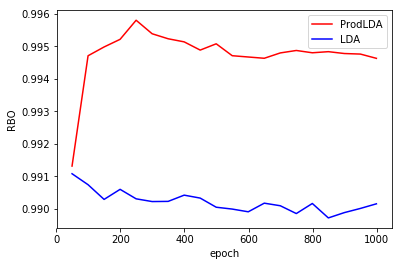

In [8]:
import matplotlib.pyplot as plt
scores_LDA_2k_50 = pd.read_csv('results/scores_50_1000_LDA_2k.csv')
scores_ProdLDA_2k_50 = pd.read_csv('results/scores_50_1000_prodLDA_2k.csv')

plt.plot(scores_ProdLDA_2k_50['epoch'].tolist(), scores_ProdLDA_2k_50['rbo'].tolist(), color='r', linestyle='-', label = 'ProdLDA')

plt.plot(scores_LDA_2k_50['epoch'].tolist(), scores_LDA_2k_50['rbo'].tolist(), color='b', linestyle='-', label = 'LDA')
# plt.plot(scores_LDA['epoch'].tolist(), scores_LDA['train_loss'].tolist(), color='b', linestyle='-', label = 'LDA')
plt.xlabel('epoch')
plt.ylabel('RBO')

plt.legend(loc="figs/lower right")
# plt.title('')
plt.savefig('figs/compare_rbo_50_1000_2k.png')

plt.show()

## 2.  compare vocab sizes and ntopics

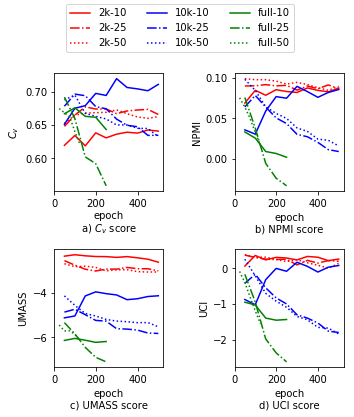

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

scores_ProdLDA_2k_10 = pd.read_csv('results/scores_10_1000_prodLDA_2k.csv')[0:10]
scores_ProdLDA_2k_25 = pd.read_csv('results/scores_25_1000_prodLDA_2k.csv')[0:10]
scores_ProdLDA_2k_50 = pd.read_csv('results/scores_50_1000_prodLDA_2k.csv')[0:10]

scores_ProdLDA_10k_10 = pd.read_csv('results/scores_10_1000_prodLDA_10k.csv')[0:10]
scores_ProdLDA_10k_25 = pd.read_csv('results/scores_25_1000_prodLDA_10k.csv')[0:10]
scores_ProdLDA_10k_50 = pd.read_csv('results/scores_50_1000_prodLDA_10k.csv')[0:10]

scores_ProdLDA_all_10 = pd.read_csv('results/scores_10_500_prodLDA_all.csv')[0:5]
scores_ProdLDA_all_25 = pd.read_csv('results/scores_25_500_prodLDA_all.csv')[0:5]
scores_ProdLDA_all_50 = pd.read_csv('results/scores_50_250_prodLDA_all.csv')[0:5]

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5,5))


# axs = []
# for row in ax:
#     for col in row:
#         axs.append(row)

score= 'npmi'
for ax, score, alpha, name in zip(axs.flatten(), ['cv', 'npmi', 'umass', 'uci'], ['a', 'b', 'c', 'd'], ['$C_v$', 'NPMI', 'UMASS', 'UCI']):
# for ax, score, alpha in zip(axs, ['rbo', 'td'], ['a', 'b']):
#     ax.set_xlabel('epoch'+ '\n'+ alpha+') '+ score.upper() + ' score')
    ax.set_xlabel('epoch'+ '\n'+ alpha+') '+ name + ' score')
    ax.set_ylabel(name)
    ax.plot(scores_ProdLDA_2k_10['epoch'].tolist(), scores_ProdLDA_2k_10[score].tolist(), color='r', linestyle='-', label = '2k-10')
    ax.plot(scores_ProdLDA_2k_25['epoch'].tolist(), scores_ProdLDA_2k_25[score].tolist(), color='r', linestyle='-.', label = '2k-25')
    ax.plot(scores_ProdLDA_2k_50['epoch'].tolist(), scores_ProdLDA_2k_50[score].tolist(), color='r', linestyle=':', label = '2k-50')


    ax.plot(scores_ProdLDA_10k_10['epoch'].tolist(), scores_ProdLDA_10k_10[score].tolist(), color='b', linestyle='-', label = '10k-10')
    ax.plot(scores_ProdLDA_10k_25['epoch'].tolist(), scores_ProdLDA_10k_25[score].tolist(), color='b', linestyle='-.', label = '10k-25')
    ax.plot(scores_ProdLDA_10k_50['epoch'].tolist(), scores_ProdLDA_10k_50[score].tolist(), color='b', linestyle=':', label = '10k-50')

    ax.plot(scores_ProdLDA_all_10['epoch'].tolist(), scores_ProdLDA_all_10[score].tolist(), color='g', linestyle='-', label = 'full-10')
    ax.plot(scores_ProdLDA_all_25['epoch'].tolist(), scores_ProdLDA_all_25[score].tolist(), color='g', linestyle='-.', label = 'full-25')
    ax.plot(scores_ProdLDA_all_50['epoch'].tolist(), scores_ProdLDA_all_50[score].tolist(), color='g', linestyle=':', label = 'full-50')

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='lower center', ncol = 3, bbox_to_anchor=(0.5, 1))
fig.tight_layout(pad=1.0)
# plt.title(score)

# plt.savefig('samplefigure', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.savefig('figs/vocab.png',  bbox_extra_artists=(lgd, ), dpi = 300 , bbox_inches='tight')

# plt.savefig('figs/vocab_td.png',  bbox_extra_artists=(lgd, ), dpi = 300 , bbox_inches='tight')

plt.show()

## 3. Compare internal and external topic coherence vs ntopics

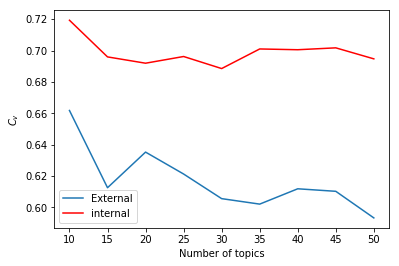

In [24]:
import matplotlib.pyplot as plt

plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [cv_ext_10_10k_, cv_ext_15_10k_, cv_ext_20_10k_, cv_ext_25_10k_, cv_ext_30_10k_, cv_ext_35_10k_ , cv_ext_40_10k_, cv_ext_45_10k_, cv_ext_50_10k_], label = 'External')
plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [cv_int_10_10k_, cv_int_15_10k_, cv_int_20_10k_, cv_int_25_10k_, cv_int_30_10k_, cv_int_35_10k_, cv_int_40_10k_, cv_int_45_10k_, cv_int_50_10k_], label = 'internal', color = 'r')

# plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [npmi_ext_10_10k_, npmi_ext_15_10k_, npmi_ext_20_10k_, npmi_ext_25_10k_, npmi_ext_30_10k_, npmi_ext_35_10k_ , npmi_ext_40_10k_, npmi_ext_45_10k_, npmi_ext_50_10k_], label = 'External')
# plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [npmi_int_10_10k_, npmi_int_15_10k_, npmi_int_20_10k_, npmi_int_25_10k_, npmi_int_30_10k_, npmi_int_35_10k_, npmi_int_40_10k_, npmi_int_45_10k_, npmi_int_50_10k_], label = 'internal', color = 'r')

# plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [umass_ext_10_10k_, umass_ext_15_10k_, umass_ext_20_10k_, umass_ext_25_10k_, umass_ext_30_10k_, umass_ext_35_10k_ , umass_ext_40_10k_, umass_ext_45_10k_, umass_ext_50_10k_], label = 'External')
# plt.plot([10, 15, 20, 25, 30, 35, 40, 45, 50], [umass_int_10_10k_, umass_int_15_10k_, umass_int_20_10k_, umass_int_25_10k_, umass_int_30_10k_, umass_int_35_10k_, umass_int_40_10k_, umass_int_45_10k_, umass_int_50_10k_], label = 'internal', color = 'r')

# plt.plot([10,25], [cv_ext_10_2k_, cv_ext_25_2k_])
# plt.plot([10, 25], [cv_int_10_2k_, cv_int_25_2k_], color = 'r')

plt.legend(loc="figs/upper right")
plt.xlabel('Number of topics')
plt.ylabel('$C_v$')
# plt.title('cv')
plt.savefig('figs/ntopics_10k_cv.png')
plt.show()

## dominant topics frequency

In [34]:
topics = ctm.get_topics(25)
scores_prodLDA = pd.read_csv('results/scores_20_250_prodLDA_10k.csv')
regexp = re.compile(r'c\d{7}')

df = pd.DataFrame(columns = ['topic', 'words/entities'])
to_write = ''
for i in range(len(topics)):
    to_write+='topic '+str(i)+':\n'
    new_top =[]
    for w in topics[i]:
        if regexp.search(w):
            try:
                new_top.append('C'+w[1:len(w)] +':'+ linker.umls.cui_to_entity['C'+w[1:len(w)]][1])
            except Exception:
                new_top.append(w)
        else:
            new_top.append(w)
        df.loc[i] =  i, new_top
#     print(topic)
df.head()



/home/dhamzeia/.local/lib/python3.7/site-packages/pandas/core/internals/blocks.py:867: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)
/home/dhamzeia/.local/lib/python3.7/site-packages/pandas/core/internals/blocks.py:867: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)
/home/dhamzeia/.local/lib/python3.7/site-packages/pandas/core/internals/blocks.py:867: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

,topic,words/entities
0,0,"[C0267454:Necrotic enteritis, C0605290:2-chlor..."
1,1,"[C0015967:Fever, C0032285:Pneumonia, C0011900:..."
2,2,"[C0543467:Operative Surgical Procedures, C0025..."
3,3,"[C0032042:Placebos, C0199470:Mechanical ventil..."
4,4,"[policy, crisis, disaster, threat, economic, p..."


In [35]:
topic_doc_dist_test = ctm.get_doc_topic_distribution(dataset=test_set, n_samples = 2)
topic_doc_dist_train = ctm.get_doc_topic_distribution(dataset=dataset, n_samples=2)

In [37]:
mlike_topics = np.argmax(topic_doc_dist_test, axis=1)
diff = np.sort(topic_doc_dist_test, axis = 1)[::-1]
diff = (diff[:, len(df)-1]- diff[:, len(df)-2])/diff[:, len(df)-2]*100
test_df['diff'] = diff
test_df['dominant_topic'] = mlike_topics
freq = pd.Series(mlike_topics).value_counts(sort = False)
freq = freq/sum(freq)*100

In [40]:
test_df['dominant_topic_words'] = ''
for i in range(len(df)):
#     test_df.loc[test_df['dominant_topic']==i, 'dominant_topic_words'].set_value( df.loc[i, 'words/entities'])
    test_df.loc[np.where(test_df['dominant_topic']==i)[0], 'dominant_topic_words'] =  ', '.join(df.loc[i, 'words/entities'])

In [61]:
test_df.to_csv('manual_validation_df.csv')

In [57]:
test_df.loc[test_df['dominant_topic']==2, ].to_csv('mv_test_2.csv')

In [71]:
df.to_csv('topics_words.csv')

Text(0, 0.5, 'Percentage of Documents')

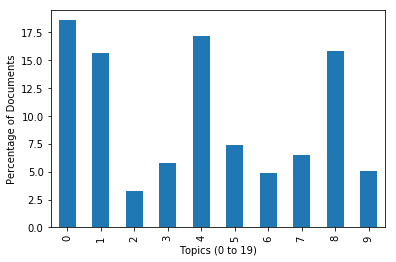

In [38]:
import matplotlib.pyplot as plt
freq.plot.bar()
plt.xlabel('Topics (0 to 19)')
plt.ylabel('Percentage of Documents')
# plt.savefig('figs/freq_topic.png')